# i Business Understanding

---

## i.i Insurance Company for Fraud Detection

Perusahaan Asuransi bertugas dalam mendeteksi dan mencegah <b>fraud</b> pada klaim asuransi. Dengan meningkatnya fraud dalam klaim penipuan dapat menyebabkan kerugian finansial signifikan baik untuk perusahaan maupun nasabah. Perusahaan melakukan sebuah analisis untuk mengidentifikasi klaim yang mencurigakan atau <b>fraud</b>.


### i.i.i Expansion Problems 

Ada beberapa strategi perusahaan dalam mengatasi kerugian finansial diantaranya sebagai berikut:
1. <b>Jika klaim fraud terdeteksi dengan benar</b> (dikenal sebagai <b>True Positive</b>), perusahaan akan mendapatkan 15% hingga 30% dari nilai klaim tersebut.
2. <b>Jika klaim penipuan terdeteksi tetapi ternyata bukan penipuan</b> (ini disebut <b>False Positive</b>), perusahaan hanya mendapatkan 2% hingga 5% dari nilai klaim tersebut.
3. <b>Jika klaim yang sah malah dianggap penipuan</b> (ini disebut <b>False Negative</b>), perusahaan harus mengembalikan 100% dari nilai klaim kepada pelanggan, karena klaim tersebut sebenarnya sah fraud.

### i.ii.i Business Question

1. Kinerja Model
- Berapa nilai Precision dan Accuracy dari model yang digunakan? (Precision: Seberapa baik model mengurangi kesalahan deteksi penipuan pada klaim yang sah? Accuracy: Seberapa sering model membuat keputusan yang benar?)

2. Keandalan Model
- Seberapa konsisten model dalam mengklasifikasikan klaim sebagai fraudulent atau legitimate?

3. Proyeksi Keuangan
- Berapa pendapatan yang diharapkan perusahaan?
- Berapa kerugian yang mungkin dialami perusahaan?
- Berapa keuntungan bersih perusahaan?

4. Keputusan Strategis
- Bagaimana optimalisasi model dapat meningkatkan keuntungan perusahaan dan mengurangi risiko kerugian?
- Apakah diperlukan kebijakan tambahan untuk meningkatkan tingkat deteksi yang lebih baik?

# 0.0 Imports and Helper Functions

---

## 0.1 Imports

In [2]:
#library(knitr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(RColorBrewer)

library(vcd)
library(corrplot)

library(fastDummies)
library(e1071)
library(caret)
library(class)
library(randomForest)
library(xgboost)
library(lightgbm)

library(MLmetrics)
library(ModelMetrics)
library(PRROC)
library(pROC)
library(kernlab)

library(smotefamily)

## 0.2 Helper Function

#### Plot Settings

In [3]:
#Ignore warnings
options(warn = -1)
set.seed(42)

In [4]:
jupyter_settings <- function() {
  # Menampilkan grafik dalam notebook (RStudio akan menampilkan grafik secara otomatis)
  options(repr.plot.width = 25, repr.plot.height = 12)  # Set figure size for RStudio
  
  # Mengatur ggplot2 dan theme
  ggplot2::theme_set(theme_minimal(base_size = 16))  # Default theme with font size
  
  # Menyesuaikan tampilan dataframe
  options(width = 150)  # Menyesuaikan lebar tampilan console
  options(dplyr.print_max = Inf)  # Menampilkan seluruh kolom dataframe
  options(dplyr.print_n   = Inf)  # Menampilkan seluruh baris dataframe
}

# Memanggil fungsi
jupyter_settings()

#### EDA Plot

In [5]:
univariate_plot <- function(data, type_attributes) {
  
  # Pilih jenis kolom numerik dan kategorikal
  num_attributes <- data[, sapply(data, is.numeric)]
  cat_attributes <- data[, sapply(data, is.factor) | sapply(data, is.character)]
  
  if (type_attributes == "numeric") {
    # Mengatur jumlah baris dan kolom dari attributes
    n     <- ncol(num_attributes)
    ncols <- 5
    nrows <- ceiling(n / ncols)
    
    par(mfrow = c(nrows, ncols))  # Mengatur layout grafik
    
    for (j in 1:n) {
      hist(num_attributes[[j]], main = colnames(num_attributes)[j], xlab = colnames(num_attributes)[j], col = "skyblue", border = "white")
    }
    
  } else if (type_attributes == "categorical") {
    # Mengatur jumlah baris dan kolom dari attribute
    n     <- ncol(cat_attributes)
    ncols <- 5
    nrows <- ceiling(n / ncols)
    
    par(mfrow = c(nrows, ncols))  # Mengatur layout grafik
    
    for (j in 1:n) {
      counts <- table(cat_attributes[[j]])
      palet  <- brewer.pal(9, "Set1")
      barplot(counts, main = colnames(cat_attributes)[j], col = palet, las = 2)
      total  <- sum(counts)
      text(x = seq_along(counts), y = counts, labels = paste0(round(100 * counts / total, 1), "%"), pos = 3)
    }
    
  } else {
    stop("Invalid 'type_attributes' value. It should be either 'numeric' or 'categorical'.")
  }
  
  par(mfrow = c(1, 1))  # Reset layout
}

In [6]:
# Fungsi untuk menghitung Cramér's V
cramers_v <- function(x, y) {
  # Membuat tabel kontingensi
  contingency_table <- table(x, y)
  
  # Menghitung statistik chi-square dan nilai p
  chi2    <- chisq.test(contingency_table)$statistic
  n       <- sum(contingency_table)
  min_dim <- min(dim(contingency_table)) - 1
  
  # Menghitung Cramér's V
  return(sqrt(chi2 / (n * min_dim)))
}

# Fungsi untuk menghitung matriks Cramér's V untuk variabel kategori
cramers_v_matrix <- function(data) {
  # Memilih data kategori
  df_cat   <- data[, sapply(data, is.factor) | sapply(data, is.character)]
  
  # Inisialisasi matriks untuk menyimpan nilai Cramér's V
  corr_cat <- matrix(NA, nrow = ncol(df_cat), ncol = ncol(df_cat))
  
  # Menghitung Cramér's V untuk setiap pasangan variabel kategori
  for (i in 1:ncol(df_cat)) {
    for (j in 1:ncol(df_cat)) {
      corr_cat[i, j] <- cramers_v(df_cat[[i]], df_cat[[j]])
    }
  }
  
  # Menetapkan nama baris dan kolom
  colnames(corr_cat) <- colnames(df_cat)
  rownames(corr_cat) <- colnames(df_cat)
  
  # Mengembalikan matriks Cramér's V
  return(corr_cat)
}


#### ML Scores

In [7]:
calculate_metrics <- function(x, y, z, ml) {
  # x : Nilai aktual (y_true)
  # y : Nilai prediksi (y_pred)
  # z : Probabilitas prediksi (y_pred_prob)
  # ml : Jenis ML (Klasifikasi atau Klasifikasi_Imbalanced)
  
  if (ml == "Classification") {
    # Perhitungan metrik menggunakan caret dan pROC untuk AUC
    accuracy  <- MLmetrics::Accuracy(y, x)  # Akurasi
    precision <- ModelMetrics::ppv(x, y, cutoff = 0.5)  # Presisi
    recall    <- ModelMetrics::recall(x, y, cutoff = 0.5)  # Recall
    f1        <- ModelMetrics::f1Score(x, y, cutoff = 0.5)  # F1-Score
    auc_score <- ModelMetrics::auc(x, y)  # AUC
    log_loss  <- ModelMetrics::logLoss(y, x)  # Log-Loss

    # Mengembalikan hasil metrik dalam bentuk list
    return(list(
      accuracy  = accuracy,
      precision = precision,
      recall    = recall,
      f1        = f1,
      auc       = auc_score,
      logLoss   = log_loss
    ))

  } else if (ml == "Imbalanced_Classification") {
    # Perhitungan metrik untuk klasifikasi tidak seimbang
    sensitivity <- MLmetrics::Sensitivity(x, y, positive = 1)  # Sensitivitas
    specificity <- MLmetrics::Specificity(x, y, positive = 1)  # Spesifisitas
    balance     <- (sensitivity + specificity) / 2  # Keseimbangan
    precision   <- ModelMetrics::ppv(x, y, cutoff = 0.5)  # Presisi
    recall      <- ModelMetrics::recall(x, y, cutoff = 0.5)  # Recall
    f1_mino     <- ModelMetrics::f1Score(x, y, cutoff = 0.5)  # F1-Score
    mcc         <- ModelMetrics::mcc(x, y, cutoff = 0.5)  # Matthews Correlation Coefficient (MCC)
    kappa       <- ModelMetrics::kappa(x, y, cutoff = 0.5)  # Kappa statistic
    auc_pr      <- PRROC::pr.curve(scores.class0 = z, weights.class0 = x, curve = TRUE)  # AUC PR Curve
    auc_pr      <- auc_pr$auc.integral  # Nilai AUC PR Curve
    
    # Mengembalikan hasil metrik dalam bentuk list
    return(list(
      sensitivity = sensitivity,
      specificity = specificity,
      balance     = balance,
      precision   = precision,
      recall      = recall,
      f1_mino     = f1_mino,
      auc_pr      = auc_pr,
      kappa       = kappa,
      mcc         = mcc
    ))

  } else {
    stop("Metode ml tidak valid")  # Menangani jika metode ml tidak valid
  }
}


In [8]:
create_metrics_dataframe <- function(metrics, model_name, ml) {
    
    #Membuat Dataframe dengan hasil metriks yang diberikan 
    #metrics    : Daftar score metriks
    #model_name : Nama model
    #ml         : Tipe Ml (Classification atau Imbalanced_Classification)
    
    if (ml == "Classification") {
        # Buat dataframe untuk metriks klasifikasi
        results <- data.frame(
            `Accuracy`  = round(metrics$accuracy, 3),
            `Precision` = round(metrics$precision, 3),
            `Recall`    = round(metrics$recall, 3),
            `F1`        = round(metrics$f1, 3),
            `AUC`       = round(metrics$auc, 3),
            `logLoss`   = round(metrics$logLoss, 3)
        )
        
    } else if (ml == "Imbalanced_Classification") {
        # Buat dataframe untuk metriks klasifikasi yang tidak seimbang
        results <- data.frame(
            `Balance Accuracy`    = round(metrics$balance, 3),
            `Precision`           = round(metrics$precision, 3),
            `Recall`              = round(metrics$recall, 3),
            `F1 Score Minorities` = round(metrics$f1_mino, 3),
            `AUC-PR`              = round(metrics$auc_pr, 3),
            `Kappa`               = round(metrics$kappa, 3),
            `MCC`                 = round(metrics$mcc, 3)
        )
        
    } else {
        stop("Invalid ml method")
    }

    # Mengatur nama model pada baris
    rownames(results) <- model_name
    return(results)
}


In [9]:
ml_scores <- function(model_name, ml, x, y, z) {
    
    # Menghitung metriks
    metrics <- calculate_metrics(x, y, z, ml)
    
    # Membuat DataFrame
    results <- create_metrics_dataframe(metrics, model_name, ml)
    
    # Mengembalikan results
    return(results)
}


#### Function ML CV

In [10]:
initialize_metric_vectors <- function(ml) {
  
    # Menginisialisasi vektor metrik kosong 

    # ml: Tipe Ml ('Classification' atau 'Imbalanced_Classification')
  
  if (ml == "Classification") {
    # Membuat daftar kosong metriks
    metric_vectors <- list(
      accuracy_vals  = numeric(0),
      precision_vals = numeric(0),
      recall_vals    = numeric(0),
      f1_vals        = numeric(0),
      auc_vals       = numeric(0),
      logLoss_vals   = numeric(0)
    )
    
  } else if (ml == "Imbalanced_Classification") {
    # Membuat daftar kosong metriks
    metric_vectors <- list(
      sensitivity_vals = numeric(0),
      specificity_vals = numeric(0),
      balance_vals     = numeric(0),
      precision_vals   = numeric(0),
      recall_vals      = numeric(0),
      f1_mino_vals     = numeric(0),
      auc_pr_vals      = numeric(0),
      kappa_vals       = numeric(0),
      mcc_vals         = numeric(0)
    )
    
  } else {
    stop("Invalid ml method")
  }
  
  return(metric_vectors)
}


In [11]:
create_metrics_vals_dataframe <- function(metric_vectors, model_name, ml) {

    
  #  Membuat DataFrame dengan rata-rata dan standard deviasi

#    metric_vectors : Daftar nilai metriks
#    model_name     : Nama Model
#    ml             : Tipe Ml ('Classification' atau 'Imbalanced_Classification')
    
  if (ml == "Classification") {
    # Buat Dataframe untuk metriks klasifikasi
    results <- data.frame(
      Accuracy  = paste(round(mean(metric_vectors$accuracy_vals), 3),
                        "+/-", round(sd(metric_vectors$accuracy_vals), 3)),
      Precision = paste(round(mean(metric_vectors$precision_vals), 3), 
                        "+/-", round(sd(metric_vectors$precision_vals), 3)),
      Recall    = paste(round(mean(metric_vectors$recall_vals), 3),
                        "+/-", round(sd(metric_vectors$recall_vals), 3)),
      F1        = paste(round(mean(metric_vectors$f1_vals), 3),
                        "+/-", round(sd(metric_vectors$f1_vals), 3)),
      AUC       = paste(round(mean(metric_vectors$auc_vals), 3),
                        "+/-", round(sd(metric_vectors$auc_vals), 3)),
      logLoss   = paste(round(mean(metric_vectors$logLoss_vals), 3),
                        "+/-", round(sd(metric_vectors$logLoss_vals), 3))
    )
    
  } else if (ml == "Imbalanced_Classification") {
    # Buat Dataframe untuk metriks klasifikasi tidak seimbang
    results <- data.frame(
      `Balanced Accuracy` = paste(round(mean(metric_vectors$balance_vals), 3),
                                  "+/-", round(sd(metric_vectors$balance_vals), 3)),
      Precision           = paste(round(mean(metric_vectors$precision_vals), 3),
                                  "+/-", round(sd(metric_vectors$precision_vals), 3)),
      Recall              = paste(round(mean(metric_vectors$recall_vals), 3),
                                  "+/-", round(sd(metric_vectors$recall_vals), 3)),
      `F1 Minorities`     = paste(round(mean(metric_vectors$f1_mino_vals), 3),
                                  "+/-", round(sd(metric_vectors$f1_mino_vals), 3)),
      `AUC-PR`            = paste(round(mean(metric_vectors$auc_pr_vals), 3),
                                  "+/-", round(sd(metric_vectors$auc_pr_vals), 3)),
      Kappa               = paste(round(mean(metric_vectors$kappa_vals), 3),
                                  "+/-", round(sd(metric_vectors$kappa_vals), 3)),
      MCC                 = paste(round(mean(metric_vectors$mcc_vals), 3),
                                  "+/-", round(sd(metric_vectors$mcc_vals), 3))
    )
    
  } else {
    stop("Invalid ml method")
  }
  
  #Mengatur nama model pada baris
  rownames(results) <- model_name
  return(results)
}


In [12]:
model_cv <- function(model, x, y, a, b) {
    
    if (model == "dummy") {
        
        smote_data <- smotefamily::SMOTE(x, y, K = 5)  
        # Pisahkan kembali hasil SMOTE menjadi fitur dan target
        x_res <- smote_data$data[, -ncol(smote_data$data)]  # Memisahkan data fitur
        y_res <- smote_data$data[, ncol(smote_data$data)]   # Memisahkan label
        
        # Latih model DummyClassifier (menggunakan model yang sudah dilatih sebelumnya)
        model_cv <- caret::train(
            x = x_res,
            y = y_res,
            method = "rf", # Sama seperti sebelumnya, menggunakan RandomForest
            trControl = caret::trainControl(method = "cv", number = 5),
            tuneGrid = data.frame(mtry = 1)
        )

        return(model_cv)
        
    } else if (model == "lg") {
        
        # Latih model Logistic Regression menggunakan data pelatihan
        # 'y' adalah target (variabel dependen), dan '.' menunjukkan semua fitur yang ada dalam data 'x'
        model_cv <- glm(y ~ ., data = x, family = binomial)

        return(model_cv)
        
    } else if (model == "knn") {

        # Menggunakan metode SMOTE untuk melakukan oversampling pada data yang tidak seimbang
        smote_data <- smotefamily::SMOTE(x, y, K = 5)  
        
        # Pisahkan kembali hasil SMOTE menjadi fitur dan target
        x_res <- smote_data$data[, -ncol(smote_data$data)]  # Memisahkan data fitur (semua kolom kecuali kolom terakhir)
        y_res <- smote_data$data[, ncol(smote_data$data)]   # Memisahkan label (kolom terakhir)

        # Latih model K Nearest Neighbor
        model_cv <- class::knn(
            train = x_res,
            test  = a,
            cl    = y_res,
            l     = 0,
            k     = 5,
            prob  = TRUE
        )
        
        return(model_cv)
        
    } else if (model == "svm") {
        
        # Inisialisasi Support Vector Machine (SVM) dengan penyesuaian bobot kelas (balanced) dan probabilitas
        model_cv <- e1071::svm(
            x             = x,  # Data fitur untuk pelatihan
            y             = as.factor(y),  # Pastikan y_train diubah menjadi faktor untuk klasifikasi
            type          = "C-classification",  # Menentukan jenis model untuk klasifikasi
            kernel        = "radial",  # Menggunakan kernel Radial Basis Function (RBF)
            class.weights = list('1' = 1, '0' = 1),  # Menyesuaikan bobot kelas untuk penyeimbangan kelas
            probability   = TRUE  # Mengaktifkan perhitungan probabilitas untuk prediksi
        )
        
        return(model_cv)

    } else if (model == "rf") {

        # Inisialisasi model Random Forest dengan penyesuaian bobot kelas dan pengukuran pentingnya variabel
        model_cv <- randomForest::randomForest(
            x          = x,  # Data fitur untuk pelatihan
            y          = as.factor(y),  # Pastikan y_train diubah menjadi faktor untuk klasifikasi
            importance = TRUE,  # Mengukur pentingnya variabel (fitur) dalam model
            classwt    = c('0' = 1, '1' = 1),  # Menyesuaikan bobot kelas untuk penyeimbangan kelas
            ntree      = 100,  # Jumlah pohon (trees) yang digunakan dalam model Random Forest
            proximity  = TRUE  # Mengaktifkan pengukuran kedekatan (proximity) antar sampel
        )

        return(model_cv)
        
    } else if (model == "xgb") {

        # Menyusun parameter untuk model XGBoost
        params_cv <- list(
            objective        = "binary:logistic",  # Menentukan tujuan klasifikasi biner dengan logistik
            eval_metric      = "auc",  # Metrik evaluasi menggunakan AUC
            max_depth        = 6,  # Kedalaman maksimum pohon
            max_delta_step   = 1,
            eta              = 0.1,  # Kecepatan pembelajaran (learning rate)
            subsample        = 0.8,
            min_child_weight = 1,
            colsample_bytree = 0.8
        )
        
        # Menyusun data dalam format yang diperlukan untuk XGBoost (DMatrix)
        dtrain_cv <- xgboost::xgb.DMatrix(data = as.matrix(x), label = y)  # Mengonversi data fitur 'x' dan label 'y' ke dalam format DMatrix
        
        # Melatih model XGBoost dengan parameter yang sudah ditentukan
        model_cv <- xgboost::xgb.train(
            params  = params_cv,  # Parameter yang sudah disusun
            data    = dtrain_cv,  # Data pelatihan dalam format DMatrix
            nrounds = 100,  # Jumlah iterasi (epoch) untuk pelatihan
        )

        return(model_cv)
        
    } else if (model == "lgb") {

        # Menentukan parameter untuk pelatihan model LightGBM
        params_cv <- list(
            objective        = "binary",         # Klasifikasi biner (untuk dua kelas)
            metric           = "binary_error",      # Metrik evaluasi menggunakan error biner
            learning_rate    = 1,            # Kecepatan belajar yang lebih tinggi untuk pelatihan lebih cepat
            num_leaves       = 31,              # Jumlah daun pada setiap pohon dalam model
            max_depth        = -1,               # Tidak ada batas kedalaman, LightGBM akan memutuskan secara otomatis
            is_unbalance     = TRUE,          # Penanganan kelas yang tidak seimbang dalam dataset
            min_data_in_leaf = 20,        # Jumlah minimum data dalam setiap daun
            feature_fraction = 0.8,       # Proporsi fitur yang digunakan dalam setiap iterasi
            bagging_fraction = 0.8,       # Proporsi data yang digunakan dalam setiap iterasi
            bagging_freq     = 5              # Frekuensi bagging, berapa banyak iterasi yang menggunakan subsample data
        )
        
        # Menyusun data pelatihan dan validasi dalam format LightGBM (lgb.Dataset)
        dtrain_cv <- lightgbm::lgb.Dataset(data = as.matrix(x), label = y)  # Data pelatihan (fitur dan label)
        dvalid_cv <- lightgbm::lgb.Dataset(data = as.matrix(a), label = b)  # Data validasi (fitur dan label)
        
        # Melatih model LightGBM dengan mekanisme early stopping untuk menghindari overfitting
        model_cv <- lightgbm::lgb.train(
            params  = params_cv,               # Parameter yang sudah disusun sebelumnya
            data    = dtrain_cv,                  # Data pelatihan
            valids  = list(valid = dvalid_cv),  # Data validasi untuk memonitor performa selama pelatihan
            nrounds = 100,                     # Jumlah iterasi (epoch) untuk pelatihan
            early_stopping_rounds = 3L         # Early stopping jika tidak ada perbaikan setelah 3 iterasi
        )

        return(model_cv)
        
    } else if (model == "tuning"){

        # Melatih model SVM menggunakan svm() dari e1071
        model_cv <- e1071::svm(
            x             = x,                      # Fitur data untuk pelatihan
            y             = as.factor(y),                           # Label target untuk pelatihan
            type          = "C-classification",            # Tipe klasifikasi SVM (bisa juga "nu-classification")
            kernel        = "radial",                    # Kernel radial (RBF)
            cost          = best_model$cost,               # Nilai cost dari grid
            gamma         = best_model$gamma,             # Nilai gamma dari grid
            class.weights = list('1' = 1, '0' = 1),
            probability   = TRUE                         # Menonaktifkan scaling, jika perlu (opsional)
        )

        return(model_cv)
        
    }else {
        stop("Invalid model")
    }
}

In [13]:
# Fungsi untuk melakukan cross-validation dan mengembalikan nilai metrik
# model_name : Nama model
# model      : objek model
# x          : Data input (fitur)
# y          : Label target
# verbose    : Atur ke 1 untuk mencetak informasi fold, 0 untuk tidak mencetak

ml_cv_results <- function(model_name, ml, model, x, y, verbose = 1) {
  
  # Normalisasi data masukan menggunakan metode caret 'range' (skala 0-1)
  mm <- caret::preProcess(x, method = "range") # Normalisasi data
  x_ <- predict(mm, x) # Terapkan normalisasi pada data x
    
  # Inisialisasi vektor metrik yang kosong
  metric_vectors <- initialize_metric_vectors(ml)
  
  # Membuat fold untuk cross-validation dengan 5 fold
  folds <- caret::createFolds(y, k = 5, list = TRUE, returnTrain = FALSE)
    
  # Loop untuk setiap fold dalam cross-validation
  for (i in 1:5) {
    if (verbose > 0) {
      cat('Fold K=', i, '\n') # Tampilkan nomor fold jika verbose > 0
    }
    
    # Pisahkan data menjadi set pelatihan dan set uji untuk fold saat ini
    index_test  <- folds[[i]] # Indeks data uji
    index_train <- setdiff(1:length(y), index_test) # Indeks data pelatihan
    
    # Pisahkan data ter-normalisasi dan label ke dalam set pelatihan dan set uji
    x_train <- x_[index_train, ]  # Data pelatihan
    y_train <- y[index_train]     # Label pelatihan
    x_test  <- x_[index_test, ]   # Data uji
    y_test  <- y[index_test]      # Label uji
        
    # Latih model pada data pelatihan dan lakukan prediksi pada data uji
    model_cv <- model_cv(model, x_train, y_train, x_test, y_test)

    # Prediksi berdasarkan model yang dipilih
    if (model == "dummy") {
      # Prediksi kelas menggunakan model dummy
      y_pred_cv      <- predict(model_cv, x_test)

      # Prediksi probabilitas kelas positif untuk data uji
      y_pred_prob_cv <- predict(model_cv, x_test, type = "prob")[, 2]
      
    } else if (model == "lg") {
      # Prediksi kelas menggunakan model Logistic Regression
      y_pred_cv <- predict(model_cv, x_test, type = "response")
      y_pred_cv <- ifelse(y_pred_cv > 0.5, 1, 0)  # Tentukan kelas berdasarkan threshold 0.5

      # Prediksi probabilitas kelas positif untuk data uji
      y_pred_prob_cv <- predict(model_cv, x_test, type = "response")
      
    } else if (model == "knn") {
      # Prediksi kelas menggunakan model K Nearest Neighbor
      y_pred_cv <- as.numeric(model_cv) - 1
      
      # Prediksi probabilitas kelas positif untuk data uji
      y_pred_prob_cv <- attr(model_cv, "prob")
      
    } else if (model == "svm") {
      # Prediksi kelas menggunakan model Support Vector Machine
      y_pred_cv <- predict(model_cv, newdata = x_test, decision.values = TRUE, probability = FALSE, na.action = na.omit)
      y_pred_cv <- as.numeric(y_pred_cv) - 1
        
      # Prediksi probabilitas kelas positif untuk data uji
      y_pred_prob_cv <- predict(model_cv, newdata = x_test, decision.values = TRUE, probability = TRUE, na.action = na.omit)
      y_pred_prob_cv <- attr(y_pred_prob_cv, "probabilities")[, 2]
        
    } else if (model == "rf") {
      # Prediksi kelas menggunakan model Random Forest
      y_pred_cv <- predict(model_cv, x_test, type = "prob")[, 2]
      y_pred_cv <- ifelse(y_pred_cv > 0.5, 1, 0)
        
      # Prediksi probabilitas kelas positif untuk data uji
      y_pred_prob_cv <- predict(model_cv, x_test, type = "prob")[, 2]
      
    } else if (model == "xgb") {
      # Prediksi menggunakan model XGBoost
      dvalid_cv <- xgboost::xgb.DMatrix(data = as.matrix(x_test), label = y_test)
      y_pred_cv <- predict(model_cv, dvalid_cv)
      y_pred_cv <- ifelse(y_pred_cv > 0.5, 1, 0) # Tentukan kelas berdasarkan threshold 0.5

      # Prediksi probabilitas untuk data uji
      y_pred_prob_cv <- predict(model_cv, dvalid_cv, type = "prob")
      
    } else if (model == "lgb") {
      # Prediksi menggunakan model LightGBM
      y_pred_cv <- predict(model_cv, as.matrix(x_test))
      y_pred_cv <- ifelse(y_pred_cv > 0.5, 1, 0) # Tentukan kelas berdasarkan threshold 0.5

      # Prediksi probabilitas untuk data uji
      y_pred_prob_cv <- predict(model_cv, as.matrix(x_test), type = "prob")
      
    } else if (model == "tuning") {

      # Prediksi kelas menggunakan model Support Vector Machine
      y_pred_cv <- predict(model_cv, newdata = x_test, decision.values = TRUE, probability = FALSE, na.action = na.omit)
      y_pred_cv <- as.numeric(y_pred_cv) - 1
        
      # Prediksi probabilitas kelas positif untuk data uji
      y_pred_prob_cv <- predict(model_cv, newdata = x_test, decision.values = TRUE, probability = TRUE, na.action = na.omit)
      y_pred_prob_cv <- attr(y_pred_prob_cv, "probabilities")[, 2]
        
    } else {
      stop("Model tidak valid")  # Jika model tidak dikenali, hentikan proses
    }

    # Hitung metrik evaluasi untuk setiap fold
    metrics <- calculate_metrics(x = y_test, y = y_pred_cv, z = y_pred_prob_cv, ml = "Imbalanced_Classification")
    
    # Simpan metrik hasil evaluasi untuk setiap fold
    metric_vectors$sensitivity_vals[i] <- metrics$sensitivity
    metric_vectors$specificity_vals[i] <- metrics$specificity
    metric_vectors$balance_vals[i]     <- metrics$balance
    metric_vectors$precision_vals[i]   <- metrics$precision
    metric_vectors$recall_vals[i]      <- metrics$recall
    metric_vectors$f1_mino_vals[i]     <- metrics$f1_mino
    metric_vectors$auc_pr_vals[i]      <- metrics$auc_pr
    metric_vectors$kappa_vals[i]       <- metrics$kappa
    metric_vectors$mcc_vals[i]         <- metrics$mcc
  }
  
  # Menyusun hasil metrik menjadi dataframe
  results <- create_metrics_vals_dataframe(metric_vectors, model_name, ml)
  
  return(results)  # Mengembalikan hasil evaluasi metrik
}


#### ML Plot

In [14]:
plot_classification <- function(data, x, y, z, type_plot, model=NULL) {
  if (type_plot == "ROC") {
    # Menghitung ROC AUC
    roc_curve <- roc(y, z)
    
    # Membuat Plot ROC
    ggplot() +
      geom_line(aes(x = roc_curve$fpr, y = roc_curve$tpr), color = 'blue', size = 1) +
      geom_abline(intercept = 0, slope = 1, linetype = 'dashed', color = 'red') +
      labs(x = "False Positive Rate (FPR)", y = "True Positive Rate (TPR)",
           title = paste("ROC Curve (AUC =", round(roc_curve$auc, 3), ")")) +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
    
  } else if (type_plot == "ConfusionMatrix") {
    # Menghitung Confusion Matrix
    cm <- confusionMatrix(as.factor(z), as.factor(y))
    
    # Membuat Plot Confusion Matrix
    cm_table <- as.table(cm)
    ggplot(as.data.frame(cm_table), aes(Var1, Var2, fill = Freq)) +
      geom_tile() +
      geom_text(aes(label = Freq), color = "white", size = 5) +
      scale_fill_gradient(low = "white", high = "blue") +
      labs(title = "Confusion Matrix", x = "Predicted", y = "Actual") +
      theme_minimal()
    
  } else if (type_plot == "Precision-Recall") {
    # Menghitung Precision-Recall AUC
    pr_curve <- pr.curve(scores.class0 = z, weights.class0 = y, curve = TRUE)
    
    # Membuat Plot Precision-Recall Curve
    ggplot() +
      geom_line(aes(x = pr_curve$recall, y = pr_curve$precision), color = 'blue', size = 1) +
      labs(x = "Recall", y = "Precision", title = paste("Precision-Recall Curve (AUC =", round(pr_curve$auc.integral, 3), ")")) +
      theme_minimal() +
      theme(plot.title = element_text(hjust = 0.5))
    
  } else if (type_plot == "DecisionBoundary") {
    # Cek apakah data memiliki dua fitur
    if (ncol(data) == 2) {
      # Buat grid untuk plotting
      data_min <- min(data[, 1]) - 1
      data_max <- max(data[, 1]) + 1
      x_min    <- min(data[, 2]) - 1
      x_max    <- max(data[, 2]) + 1
      xx       <- seq(data_min, data_max, by = 0.1)
      yy       <- seq(x_min, x_max, by = 0.1)
      grid     <- expand.grid(X = xx, Y = yy)
      
      # Prediksi label untuk setiap titik dalam grid
      grid$Z  <- predict(model, grid)
      
      # Membuat Plot Decision Boundary
      ggplot(grid, aes(x = X, y = Y, fill = Z)) +
        geom_tile(alpha = 0.4) +
        geom_point(data = data, aes(x = data[, 1], y = data[, 2], color = factor(y)), size = 2) +
        scale_fill_manual(values = c('red', 'blue')) +
        labs(title = "Decision Boundary", x = "Feature 1", y = "Feature 2") +
        theme_minimal()
      
    } else {
      print("Decision Boundary can only be plotted for 2D data")
    }
    
  } else if (type_plot == "DistributionPlot") {
    # Membuat Plot Distribusi
    ggplot(as.data.frame(x), aes(x = factor(x))) +
      geom_bar(aes(fill = factor(x))) +
      labs(title = "Distributions Plot", x = "Categories", y = "Frequency") +
      theme_minimal()
    
  } else {
    print("Invalid type")
  }
}

In [15]:
plot_imbalanced_classification <- function(data, x, y, z, type_plot, model=NULL) {
  
  if (type_plot == "ROC") {
    # Menghitung ROC-AUC
    library(pROC)
    roc_curve <- roc(x, z)
    roc_auc   <- auc(roc_curve)
    
    # Membuat Plot
    plot(roc_curve, main=paste("ROC Curve (AUC = ", round(roc_auc, 3), ")"), col="blue", lwd=2)
    abline(a=0, b=1, col="red", lty=2, lwd=2) # Baseline
    legend("bottomright", legend=paste("ROC Curve (AUC = ", round(roc_auc, 3), ")"), col="blue", lwd=2)
  }
  
  else if (type_plot == "ConfusionMatrix") {
    # Menghitung Confusion Matrix
    library(caret)
    cm <- confusionMatrix(factor(z), factor(y))
    
    # Membuat Plot
    library(ggplot2)
    cm_table  <- as.table(cm)
    cm_melted <- as.data.frame(cm_table)
    ggplot(cm_melted, aes(Var1, Var2, fill=Freq)) +
      geom_tile() +
      geom_text(aes(label=sprintf("%d", Freq)), vjust=1) +
      scale_fill_gradient(low="white", high="blue") +
      labs(title="Confusion Matrix", x="Predicted", y="Actual") +
      theme_minimal()
  }
  
  else if (type_plot == "Precision-Recall") {
    # Menghitung Precision-Recall AUC
    library(PRROC)
    pr_curve <- pr.curve(scores.class0 = z, weights.class0 = x, curve = TRUE)
    pr_auc   <- pr_curve$auc.integral
    
    # Membuat Plot
    plot(pr_curve, main=paste("Precision-Recall Curve (AUC = ", round(pr_auc, 3), ")"), col="blue", lwd=2)
    legend("bottomleft", legend=paste("Precision-Recall Curve (AUC = ", round(pr_auc, 3), ")"), col="blue", lwd=2)
  }
  
  else if (type_plot == "DistributionPlot") {
    # Membuat Plot
    library(ggplot2)
    ggplot(data, aes(x=factor(x))) +
      geom_bar(fill="steelblue") +
      labs(title="Distributions Plot", x="Categories", y="Frequency") +
      theme_minimal()
  }
  
  else {
    print("Invalid type")
  }
}


In [16]:
plot_ml <- function(data, x, y, z, ml, type_plot, model = NULL) {
  if (ml == "Classification") {
    plot_classification(data, x, y, z, type_plot, model)
  } else if (ml == "Imbalanced_Classification") {
    plot_imbalanced_classification(data, x, y, z, type_plot, model)
  } else {
    print("Invalid ml")
  }
}


# 1.0 Data Description

## 1.1 Loading Data 

In [17]:
# Memuat pustaka yang diperlukan
df1 <- read.csv('insurance_claims.csv')

# Menampilkan 5 baris pertama dari dataset
head(df1, 5)

# Menampilkan 5 baris terakhir dari dataset
tail(df1, 5)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,⋯,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,X_c39
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,⋯,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<lgl>
1,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,⋯,YES,71610,6510,13020,52080,Saab,92x,2004,Y,NA
2,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,⋯,?,5070,780,780,3510,Mercedes,E400,2007,Y,NA
3,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,⋯,NO,34650,7700,3850,23100,Dodge,RAM,2007,N,NA
4,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,⋯,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y,NA
5,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,⋯,NO,6500,1300,650,4550,Accura,RSX,2009,N,NA


,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,⋯,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,X_c39
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,⋯,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<lgl>
996,3,38,941851,1991-07-16,OH,500/1000,1000,1310.80,0,431289,⋯,?,87200,17440,8720,61040,Honda,Accord,2006,N,NA
997,285,41,186934,2014-01-05,IL,100/300,1000,1436.79,0,608177,⋯,?,108480,18080,18080,72320,Volkswagen,Passat,2015,N,NA
998,130,34,918516,2003-02-17,OH,250/500,500,1383.49,3000000,442797,⋯,YES,67500,7500,7500,52500,Suburu,Impreza,1996,N,NA
999,458,62,533940,2011-11-18,IL,500/1000,2000,1356.92,5000000,441714,⋯,YES,46980,5220,5220,36540,Audi,A5,1998,N,NA
1000,456,60,556080,1996-11-11,OH,250/500,1000,766.19,0,612260,⋯,?,5060,460,920,3680,Mercedes,E400,2007,N,NA


## 1.2 Columns

### 1.2.1 Column Descriptions

- **months_as_customer** : Durasi (dalam bulan) sejak nasabah menjadi pelanggan asuransi.
- **age** : Usia dari tertanggung.
- **policy_number** : Nomor identifikasi polis asuransi.
- **policy_bind_date** : Tanggal polis asuransi diikat (dimulai).
- **policy_state** : Negara bagian tempat polis asuransi diterbitkan.
- **policy_csl** : Tipe batas tanggung jawab (Coverage Special Limit) dari polis.
- **policy_deductable** : Jumlah yang harus dibayar oleh tertanggung sebelum klaim dapat diproses.
- **policy_annual_premium** : Premi tahunan yang dibayar untuk polis asuransi.
- **umbrella_limit** : Batas tanggung jawab tambahan atau "payung" untuk klaim di luar polis utama.
- **insured_zip** : Kode pos tempat tertanggung tinggal.
- **insured_sex** : Jenis kelamin tertanggung.
- **insured_education_level** : Tingkat pendidikan tertanggung.
- **insured_occupation** : Pekerjaan tertanggung.
- **insured_hobbies** : Hobi tertanggung yang tercatat dalam polis.
- **insured_relationship** : Hubungan tertanggung dengan pemegang polis (misalnya, suami, istri, anak).
- **capital-gains** : Keuntungan modal yang diperoleh tertanggung.
- **capital-loss** : Kerugian modal yang dialami tertanggung.
- **incident_date** : Tanggal kejadian insiden atau klaim.
- **incident_type** : Jenis insiden atau klaim yang terjadi (misalnya, kecelakaan mobil, kebakaran).
- **collision_type** : Jenis tabrakan (jika relevan untuk klaim kendaraan).
- **incident_severity** : Tingkat keparahan insiden (misalnya, ringan, berat).
- **authorities_contacted** : Otoritas yang dihubungi terkait insiden (misalnya, polisi, pemadam kebakaran).
- **incident_state** : Negara bagian tempat insiden terjadi.
- **incident_city** : Kota tempat insiden terjadi.
- **incident_location** : Lokasi spesifik insiden (misalnya, alamat atau area).
- **incident_hour_of_the_day** : Jam kejadian insiden.
- **number_of_vehicles_involved** : Jumlah kendaraan yang terlibat dalam insiden.
- **property_damage** : Kerusakan properti yang diakibatkan oleh insiden.
- **bodily_injuries** : Cedera tubuh yang dialami dalam insiden.
- **witnesses** : Jumlah saksi yang terlibat atau hadir dalam insiden.
- **police_report_available** : Apakah laporan polisi tersedia untuk insiden tersebut (Ya/Tidak).
- **total_claim_amount** : Jumlah klaim yang diajukan terkait insiden.
- **injury_claim** : Jumlah klaim terkait cedera tubuh.
- **property_claim** : Jumlah klaim terkait kerusakan properti.
- **vehicle_claim** : Jumlah klaim terkait kendaraan yang terlibat.
- **auto_make** : Merek kendaraan yang terlibat dalam insiden.
- **auto_model** : Model kendaraan yang terlibat dalam insiden.
- **auto_year** : Tahun pembuatan kendaraan yang terlibat dalam insiden.
- **fraud_reported** : Indikator apakah klaim ini dilaporkan sebagai penipuan (Ya/Tidak).

### 1.2.2 Column Rename

In [18]:
# Mengambil dan mengonversi nama kolom ke dalam format snake_case
cols_old      <- colnames(df1)
cols_new      <- snakecase::to_snake_case(cols_old)
colnames(df1) <- cols_new

# Menampilkan nama kolom yang baru
colnames(df1)

[1] "months_as_customer"          "age"                         "policy_number"               "policy_bind_date"           
 [5] "policy_state"                "policy_csl"                  "policy_deductable"           "policy_annual_premium"      
 [9] "umbrella_limit"              "insured_zip"                 "insured_sex"                 "insured_education_level"    
[13] "insured_occupation"          "insured_hobbies"             "insured_relationship"        "capital_gains"              
[17] "capital_loss"                "incident_date"               "incident_type"               "collision_type"             
[21] "incident_severity"           "authorities_contacted"       "incident_state"              "incident_city"              
[25] "incident_location"           "incident_hour_of_the_day"    "number_of_vehicles_involved" "property_damage"            
[29] "bodily_injuries"             "witnesses"                   "police_report_available"     "total_claim_amount"         
[33] "injury_claim"                "property_claim"              "vehicle_claim"               "auto_make"                  
[37] "auto_model"                  "auto_year"                   "fraud_reported"              "x_c_39"

## 1.3 Data Dimension 

In [19]:
# Menampilkan jumlah baris dan kolom
cat("Jumlah Baris: ", nrow(df1), "\n")
cat("Jumlah Kolom: ", ncol(df1), "\n")

Jumlah Baris:  1000 
Jumlah Kolom:  40 


## 1.4 Data Types and Structure

In [20]:
str(df1)

'data.frame':	1000 obs. of  40 variables:
 $ months_as_customer         : int  328 228 134 256 228 256 137 165 27 212 ...
 $ age                        : int  48 42 29 41 44 39 34 37 33 42 ...
 $ policy_number              : int  521585 342868 687698 227811 367455 104594 413978 429027 485665 636550 ...
 $ policy_bind_date           : chr  "2014-10-17" "2006-06-27" "2000-09-06" "1990-05-25" ...
 $ policy_state               : chr  "OH" "IN" "OH" "IL" ...
 $ policy_csl                 : chr  "250/500" "250/500" "100/300" "250/500" ...
 $ policy_deductable          : int  1000 2000 2000 2000 1000 1000 1000 1000 500 500 ...
 $ policy_annual_premium      : num  1407 1197 1413 1416 1584 ...
 $ umbrella_limit             : int  0 5000000 5000000 6000000 6000000 0 0 0 0 0 ...
 $ insured_zip                : int  466132 468176 430632 608117 610706 478456 441716 603195 601734 600983 ...
 $ insured_sex                : chr  "MALE" "MALE" "FEMALE" "FEMALE" ...
 $ insured_education_level    : chr  

## 1.5 Check NA & Check "?"

In [21]:
# Menghitung jumlah nilai yang hilang (NA) dan tanda tanya ("?") di setiap kolom
col_na_count            <- sapply(df1, function(x) sum(is.na(x)))
col_question_mark_count <- sapply(df1, function(x) sum(x == "?"))

In [22]:
# Menampilkan jumlah nilai yang hilang (NA) di setiap kolom
cat("Jumlah NA di setiap kolom:\n")
col_na_count

Jumlah NA di setiap kolom:


months_as_customer                         age               policy_number            policy_bind_date                policy_state 
                          0                           0                           0                           0                           0 
                 policy_csl           policy_deductable       policy_annual_premium              umbrella_limit                 insured_zip 
                          0                           0                           0                           0                           0 
                insured_sex     insured_education_level          insured_occupation             insured_hobbies        insured_relationship 
                          0                           0                           0                           0                           0 
              capital_gains                capital_loss               incident_date               incident_type              collision_type 
                          0                           0                           0                           0                           0 
          incident_severity       authorities_contacted              incident_state               incident_city           incident_location 
                          0                           0                           0                           0                           0 
   incident_hour_of_the_day number_of_vehicles_involved             property_damage             bodily_injuries                   witnesses 
                          0                           0                           0                           0                           0 
    police_report_available          total_claim_amount                injury_claim              property_claim               vehicle_claim 
                          0                           0                           0                           0                           0 
                  auto_make                  auto_model                   auto_year              fraud_reported                      x_c_39 
                          0                           0                           0                           0                        1000

In [23]:
# Menampilkan jumlah tanda tanya ("?") di setiap kolom
cat("Jumlah tanda tanya (?) di setiap kolom:\n")
col_question_mark_count

Jumlah tanda tanya (?) di setiap kolom:


months_as_customer                         age               policy_number            policy_bind_date                policy_state 
                          0                           0                           0                           0                           0 
                 policy_csl           policy_deductable       policy_annual_premium              umbrella_limit                 insured_zip 
                          0                           0                           0                           0                           0 
                insured_sex     insured_education_level          insured_occupation             insured_hobbies        insured_relationship 
                          0                           0                           0                           0                           0 
              capital_gains                capital_loss               incident_date               incident_type              collision_type 
                          0                           0                           0                           0                         178 
          incident_severity       authorities_contacted              incident_state               incident_city           incident_location 
                          0                           0                           0                           0                           0 
   incident_hour_of_the_day number_of_vehicles_involved             property_damage             bodily_injuries                   witnesses 
                          0                           0                         360                           0                           0 
    police_report_available          total_claim_amount                injury_claim              property_claim               vehicle_claim 
                        343                           0                           0                           0                           0 
                  auto_make                  auto_model                   auto_year              fraud_reported                      x_c_39 
                          0                           0                           0                           0                          NA

## 1.6 Fill Out NA & "?"

In [24]:
# Mengisi nilai NA dengan 0 dan tanda tanya ("?") dengan "Unknown"
df1[is.na(df1)] <- 0
df1[df1 == "?"] <- "Unknown"

# Menghitung kembali jumlah nilai yang hilang dan tanda tanya setelah pengisian
col_na_count_after            <- sapply(df1, function(x) sum(is.na(x)))
col_question_mark_count_after <- sapply(df1, function(x) sum(x == "?"))

In [25]:
# Menampilkan jumlah nilai yang hilang (NA) setelah pengisian
cat("Jumlah NA setelah pengisian:\n")
col_na_count_after

Jumlah NA setelah pengisian:


months_as_customer                         age               policy_number            policy_bind_date                policy_state 
                          0                           0                           0                           0                           0 
                 policy_csl           policy_deductable       policy_annual_premium              umbrella_limit                 insured_zip 
                          0                           0                           0                           0                           0 
                insured_sex     insured_education_level          insured_occupation             insured_hobbies        insured_relationship 
                          0                           0                           0                           0                           0 
              capital_gains                capital_loss               incident_date               incident_type              collision_type 
                          0                           0                           0                           0                           0 
          incident_severity       authorities_contacted              incident_state               incident_city           incident_location 
                          0                           0                           0                           0                           0 
   incident_hour_of_the_day number_of_vehicles_involved             property_damage             bodily_injuries                   witnesses 
                          0                           0                           0                           0                           0 
    police_report_available          total_claim_amount                injury_claim              property_claim               vehicle_claim 
                          0                           0                           0                           0                           0 
                  auto_make                  auto_model                   auto_year              fraud_reported                      x_c_39 
                          0                           0                           0                           0                           0

In [26]:
# Menampilkan jumlah tanda tanya ("?") setelah pengisian
cat("Jumlah tanda tanya (?) setelah pengisian:\n")
col_question_mark_count_after

Jumlah tanda tanya (?) setelah pengisian:


months_as_customer                         age               policy_number            policy_bind_date                policy_state 
                          0                           0                           0                           0                           0 
                 policy_csl           policy_deductable       policy_annual_premium              umbrella_limit                 insured_zip 
                          0                           0                           0                           0                           0 
                insured_sex     insured_education_level          insured_occupation             insured_hobbies        insured_relationship 
                          0                           0                           0                           0                           0 
              capital_gains                capital_loss               incident_date               incident_type              collision_type 
                          0                           0                           0                           0                           0 
          incident_severity       authorities_contacted              incident_state               incident_city           incident_location 
                          0                           0                           0                           0                           0 
   incident_hour_of_the_day number_of_vehicles_involved             property_damage             bodily_injuries                   witnesses 
                          0                           0                           0                           0                           0 
    police_report_available          total_claim_amount                injury_claim              property_claim               vehicle_claim 
                          0                           0                           0                           0                           0 
                  auto_make                  auto_model                   auto_year              fraud_reported                      x_c_39 
                          0                           0                           0                           0                           0

## 1.7 Change Data Type

In [27]:
# Mengubah nilai pada kolom 'fraud_reported' ('Y' -> 'yes', 'N' -> 'no')
df1 <- df1 %>%
  dplyr::mutate(fraud_reported = dplyr::recode(fraud_reported, 'Y' = 'yes', 'N' = 'no'))

## 1.8 Description Statistics

In [28]:
# Memisahkan kolom numerik dan kategorikal
num_attributes <- data.table::as.data.table(df1[sapply(df1, is.numeric)])
cat_attributes <- data.table::as.data.table(df1[sapply(df1, is.factor) | sapply(df1, is.character)])

### 1.8.1 Numerical Attributes

In [29]:
# Statistik deskriptif untuk kolom numerik
describe1 <- num_attributes[, lapply(.SD, function(x) list(
  count    = sum(!is.na(x)),        # Jumlah nilai non-NA
  mean     = mean(x),                # Rata-rata
  sd       = sd(x),                    # Deviasi standar
  min      = min(x),                  # Nilai minimum
  q1       = quantile(x, 0.25),        # Kuartil pertama (persentil ke-25)
  q2       = quantile(x, 0.5),         # Median (persentil ke-50)
  q3       = quantile(x, 0.75),        # Kuartil ketiga (persentil ke-75)
  max      = max(x),                  # Nilai maksimum
  range    = max(x) - min(x),       # Rentang nilai
  variation_coefficient = sd(x) / mean(x), # Koefisien variasi
  skew     = e1071::skewness(x),           # Kemiringan (skewness)
  kurtosis = e1071::kurtosis(x)        # Kurtosis
))]

# Mendefinisikan nama atribut untuk ringkasan numerik
attributes <- c("count", "mean", "sd", "min", "q1", "q2", "q3", "max", "range", "variation_coefficient", "skew", "kurtosis")

# Mengonversi data ringkasan ke dalam data frame dan mentransposenya
describe <- data.frame(attributes, describe1)
describe <- t(describe)

# Menampilkan ringkasan numerik yang sudah ditranspose
describe

attributes,count,mean,sd,min,q1,q2,q3,max,range,variation_coefficient,skew,kurtosis
months_as_customer,1000,203.954,115.1132,0,115.75,199.5,276.25,479,479,0.5644075,0.361091,-0.4940178
age,1000,38.948,9.140287,19,32,38,44,64,45,0.2346792,0.477552,-0.2704169
policy_number,1000,546238.6,257063,100804,335980.2,533135,759099.8,999435,898631,0.4706057,0.03887375,-1.136709
policy_deductable,1000,1136,611.8647,500,500,1000,2000,2000,1500,0.5386133,0.4764545,-1.379309
policy_annual_premium,1000,1256.406,244.1674,433.33,1089.608,1257.2,1415.695,2047.59,1614.26,0.1943379,0.004388797,0.06139452
umbrella_limit,1000,1101000,2297407,-1000000,0,0,0,10000000,11000000,2.086654,1.801296,1.767586
insured_zip,1000,501214.5,71701.61,430104,448404.5,466445.5,603251,620962,190858,0.1430557,0.8141059,-1.194377
capital_gains,1000,25126.1,27872.19,0,0,0,51025,100500,100500,1.109292,0.4774146,-1.279769
capital_loss,1000,-26793.7,28104.1,-111100,-51500,-23250,0,0,111100,-1.048907,-0.3902983,-1.31668
incident_hour_of_the_day,1000,11.644,6.951373,0,6,12,17,23,23,0.5969918,-0.03547778,-1.19659


### 1.8.2 Categorical Attributes

In [30]:
# Mendefinisikan fungsi kustom untuk menghitung modus (nilai yang paling sering muncul)
mode <- function(x) {
  uniqx <- unique(x)  # Mengambil nilai-nilai unik
  uniqx[which.max(tabulate(match(x, uniqx)))]  # Mencari nilai yang paling sering muncul
}

# Statistik deskriptif untuk kolom kategorikal
describe1 <- cat_attributes[, lapply(.SD, function(x) list(
  count  = sum(!is.na(x)),            # Jumlah nilai non-NA
  unique = length(unique(x)),        # Jumlah nilai unik
  mode   = mode(x),                    # Modus (nilai yang paling sering muncul)
  freq   = sum(x == mode(x))           # Frekuensi modus
))]

# Mendefinisikan nama atribut untuk ringkasan kategorikal
attributes <- c("count", "unique", "mode", "freq")

# Mengonversi data ringkasan ke dalam data frame dan mentransposenya
describe <- data.frame(attributes, describe1)
describe <- t(describe)

# Menampilkan ringkasan kategorikal yang sudah ditranspose
describe

attributes,count,unique,mode,freq
policy_bind_date,1000,951,2006-01-01,3
policy_state,1000,3,OH,352
policy_csl,1000,3,250/500,351
insured_sex,1000,2,FEMALE,537
insured_education_level,1000,7,JD,161
insured_occupation,1000,14,machine-op-inspct,93
insured_hobbies,1000,20,reading,64
insured_relationship,1000,6,own-child,183
incident_date,1000,60,2015-02-02,28
incident_type,1000,4,Multi-vehicle Collision,419


# 2.0 Feature Engineering

In [31]:
# Membuat salinan dari data frame
df2 <- df1

## 2.1 Mind Map

In [32]:
# Menampilkan gambar (peta pikiran terkait penipuan)
#knitr::include_graphics("/home/dimyati197/Notebook/Fraud_insurance-mindmap.png")

![](Fraud_insurance-mindmap.png)

1. Transaction Details
    1. Type
        - Single Vehicle Collision
        - Multi-Vehicle Collision
        - Vehicle Theft
    2. Severity
        - Minor Damage
        - Major Damage
        - Total Loss
    3. Collision Type
        - Front Collision
        - Rear Collision
        - Side Collision
2. User Details
    1. Demografi
        - insured_sex (Male, Female)
        - insured_education_level (High School, PhD, etc.)
        - insured_relationship (Husband, Wife, Own-Child, etc.)
    2. Profil Keuangan
        - capital-gains
        - capital-loss
    3. Durasi Polis
        - months_as_customer
        - policy_bind_date
3. Claim Amount
    1. Total Amount
        - < 10,000
        - 10,000 – 50,000
        - > 50,000
    2. Claim Distribution
        - injury_claim
        - property_claim
        - vehicle_claim
4. Incident Details
    1. Waktu Insiden
        - incident_date
        - incident_hour_of_the_day
    2. Lokasi Insiden
        - incident_state
        - incident_city
        - incident_location
5. Vehicle Details
    1. Jenis Kendaraan
        - auto_make (e.g., Saab, Mercedes, Dodge)
        - auto_model (e.g., 92x, E400, RAM)
    2. Tahun Kendaraan
        - < 2005
        - 2005 – 2015
        - 2015
6. Fraud Classification
    1. Flag Fraud
        - fraud_reported
        - police_report_available
        - property_damage

## 2.2 Hypothesis Creation

### 2.2.1 Transaction Detail

#### 2.2.1.1 Type

- Sekitar 2.000 klaim fraud terjadi setiap tahun akibat Single Vehicle Collision.
- 40% dari klaim terkait Multi-vehicle collision menunjukkan indikasi fraud.
- Setiap tahun, 1.500 klaim fraud teridentifikasi pada insiden yang melibatkan vehicle theft.

#### 2.2.1.2 Severity

- Klaim kerusakan minor cenderung lebih sering valid, dengan 80% klaim kerusakan minor.
- 500 klaim fraud terkait dengan kerusakan total setiap tahun.
- Total Loss memiliki kemungkinan fraud yang sangat tinggi, sekitar 60% klaim.

#### 2.2.1.2 Collision Type

- 40% klaim fraud terjadi pada kecelakaan front collision.
- Kecelakaan side collision terlibat dalam fraud dengan tingkat sekitar 25%.
- Klaim fraud yang melibatkan rear collision memiliki kemungkinan sekitar 35%.

### 2.2.2 User Details

#### 2.2.2.1 Demografi 

- Pria berusia antara 25 hingga 40 tahun lebih cenderung mengajukan klaim fraud.
- Individu berpendidikan PhD hanya memiliki 10% kemungkinan terlibat dalam klaim penipuan.
- Wanita lebih jarang terlibat dalam klaim penipuan, dengan hanya 30% dari klaim yang diajukan oleh wanita yang dapat dikategorikan sebagai penipuan.
- 30% klaim penipuan yang melibatkan pasangan suami-istri mengarah pada kerugian yang sangat tinggi,

#### 2.2.2.2 Profil Keuangan

 - Individu dengan penghasilan tinggi cenderung mengajukan klaim yang sah, dengan 80% klaim mereka terbukti valid.
 - Individu dengan kerugian modal (capital loss) lebih cenderung melakukan klaim penipuan sekitar 35%.
 - Sekitar 3.000 klaim fraud yang dilakukan oleh individu dengan capital loss tercatat setiap tahun.

#### 2.2.2.3 Durasi Polis

- 80% Klaim fraud lebih sering diajukan oleh nasabah yang baru mendaftar
- 

### 2.2.3 Claim Amount

#### 2.2.3.1 Total Amount

- Klaim dengan nilai lebih tinggi (misalnya >50,000) lebih sering terkait dengan fraud.
- 65% klaim besar melibatkan fraud karena besarnya kerugian yang diklaim.
- Klaim dengan jumlah kecil (<10,000) lebih sering valid, dengan sekitar 80% klaim untuk jumlah kecil terbukti sah.

#### 2.2.3.2 Claim Distribution

- Klaim cedera melibatkan fraud sekitar 50%, karena kesulitan dalam membuktikan cedera yang sebenarnya.
- Klaim terkait kerusakan properti di wilayah dengan tingkat kriminalitas tinggi lebih sering terlibat dalam fraud, dengan tingkat fraud mencapai 60%
- Klaim kerusakan properti (property claim) yang melibatkan kerusakan besar lebih sering terlibat fraud, dengan 50% klaim ini berpotensi palsu.

### 2.2.4  Incident Details

####  2.2.4.1 Waktu Insiden

- Klaim fraud lebih sering terjadi pada jam malam atau dini hari, dengan 40% klaim yang diajukan pada waktu tersebut terbukti dipalsukan.
- Insiden yang terjadi pada waktu kerja normal lebih cenderung valid, dengan 70% klaim yang diajukan pada waktu ini sah.
- Waktu insiden pada hari libur menunjukkan tingkat fraud lebih tinggi, sekitar 70%, karena kurangnya pengawasan.

####  2.2.4.2 Lokasi Insiden

- Lokasi dengan tingkat kriminalitas tinggi memiliki kemungkinan fraud lebih tinggi (sekitar 40% klaim fraud).
- Insiden di lokasi dengan pengawasan rendah memiliki tingkat fraud sekitar 45%

### 2.2.5 Vehicle

#### 2.2.5.1 Jenis Kendaraan

- Kendaraan merek premium seperti BMW lebih sering terlibat fraud
- Kendaraan mewah seperti Mercedes lebih sering terlibat klaim fraud sekitar 30%
- Kendaraan seperti Chevrolet memiliki klaim fraud lebih banyak dibandingkan kendaraan honda

#### 2.2.5.2 Tahun Kendaraan

- Klaim untuk kendaraan tahun 2005-2015 lebih sering terkait dengan penipuan
- Klaim dengan jumlah kecil (<2005) lebih sering valid, dengan sekitar 80% klaim untuk jumlah kecil terbukti sah.

### 2.2.6 Fraud Classification

- Klaim tanpa laporan polisi lebih sering fraud sekitar 40% 
- 30% klaim sering fraud terjadi karena kerusakan besar

## 2.3 Hypothesis List

- 40% dari klaim terkait Multi-vehicle collision menunjukkan indikasi fraud.
- 80% Klaim fraud lebih sering diajukan oleh nasabah yang baru mendaftar
- Pria berusia antara 25 hingga 40 tahun lebih cenderung mengajukan klaim fraud.
- Klaim dengan jumlah kecil (<10,000) lebih sering valid, dengan sekitar 80% klaim untuk jumlah kecil terbukti sah.
- Klaim fraud lebih sering terjadi pada jam malam atau dini hari, dengan 40% klaim yang diajukan pada waktu tersebut terbukti dipalsukan.
- Kendaraan sport seperti Porsche memiliki klaim fraud lebih banyak dibandingkan kendaraan sedan.
- Klaim tanpa laporan polisi lebih sering fraud sekitar 40%

## 2.4 Feature Engineering

In [33]:
# Menghapus kolom 'x_c_39' dari data frame 'df2'
df2 <- df2[, !names(df2) %in% c('x_c_39')]

In [34]:
# Menampilkan 10 baris pertama dari data frame 'df2' yang telah dimodifikasi
head(df2, 10)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,⋯,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,⋯,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>
1,328,48,521585,2014-10-17,OH,250/500,1000,1406.91,0,466132,⋯,2,YES,71610,6510,13020,52080,Saab,92x,2004,yes
2,228,42,342868,2006-06-27,IN,250/500,2000,1197.22,5000000,468176,⋯,0,Unknown,5070,780,780,3510,Mercedes,E400,2007,yes
3,134,29,687698,2000-09-06,OH,100/300,2000,1413.14,5000000,430632,⋯,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,no
4,256,41,227811,1990-05-25,IL,250/500,2000,1415.74,6000000,608117,⋯,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,yes
5,228,44,367455,2014-06-06,IL,500/1000,1000,1583.91,6000000,610706,⋯,1,NO,6500,1300,650,4550,Accura,RSX,2009,no
6,256,39,104594,2006-10-12,OH,250/500,1000,1351.10,0,478456,⋯,2,NO,64100,6410,6410,51280,Saab,95,2003,yes
7,137,34,413978,2000-06-04,IN,250/500,1000,1333.35,0,441716,⋯,0,Unknown,78650,21450,7150,50050,Nissan,Pathfinder,2012,no
8,165,37,429027,1990-02-03,IL,100/300,1000,1137.03,0,603195,⋯,2,YES,51590,9380,9380,32830,Audi,A5,2015,no
9,27,33,485665,1997-02-05,IL,100/300,500,1442.99,0,601734,⋯,1,YES,27700,2770,2770,22160,Toyota,Camry,2012,no


# 3.0 Selecting Columns

In [35]:
# Membuat salinan lain dari data frame 'df2' yang telah dimodifikasi
df3 <- df2

# 3.1 Selecting Columns 

Saya gunakan semua kolom untuk data analisis

# 3.2 Selecting Rows

Saya gunakan semua baris untuk data analisis

# 4.0 Exploratory Data analysis

In [36]:
# Membuat salinan lain dari data frame 'df3' yang telah dimodifikasi
df4 <- df3

## 4.1 Univariate Analysis

### 4.1.1 Response Variable 

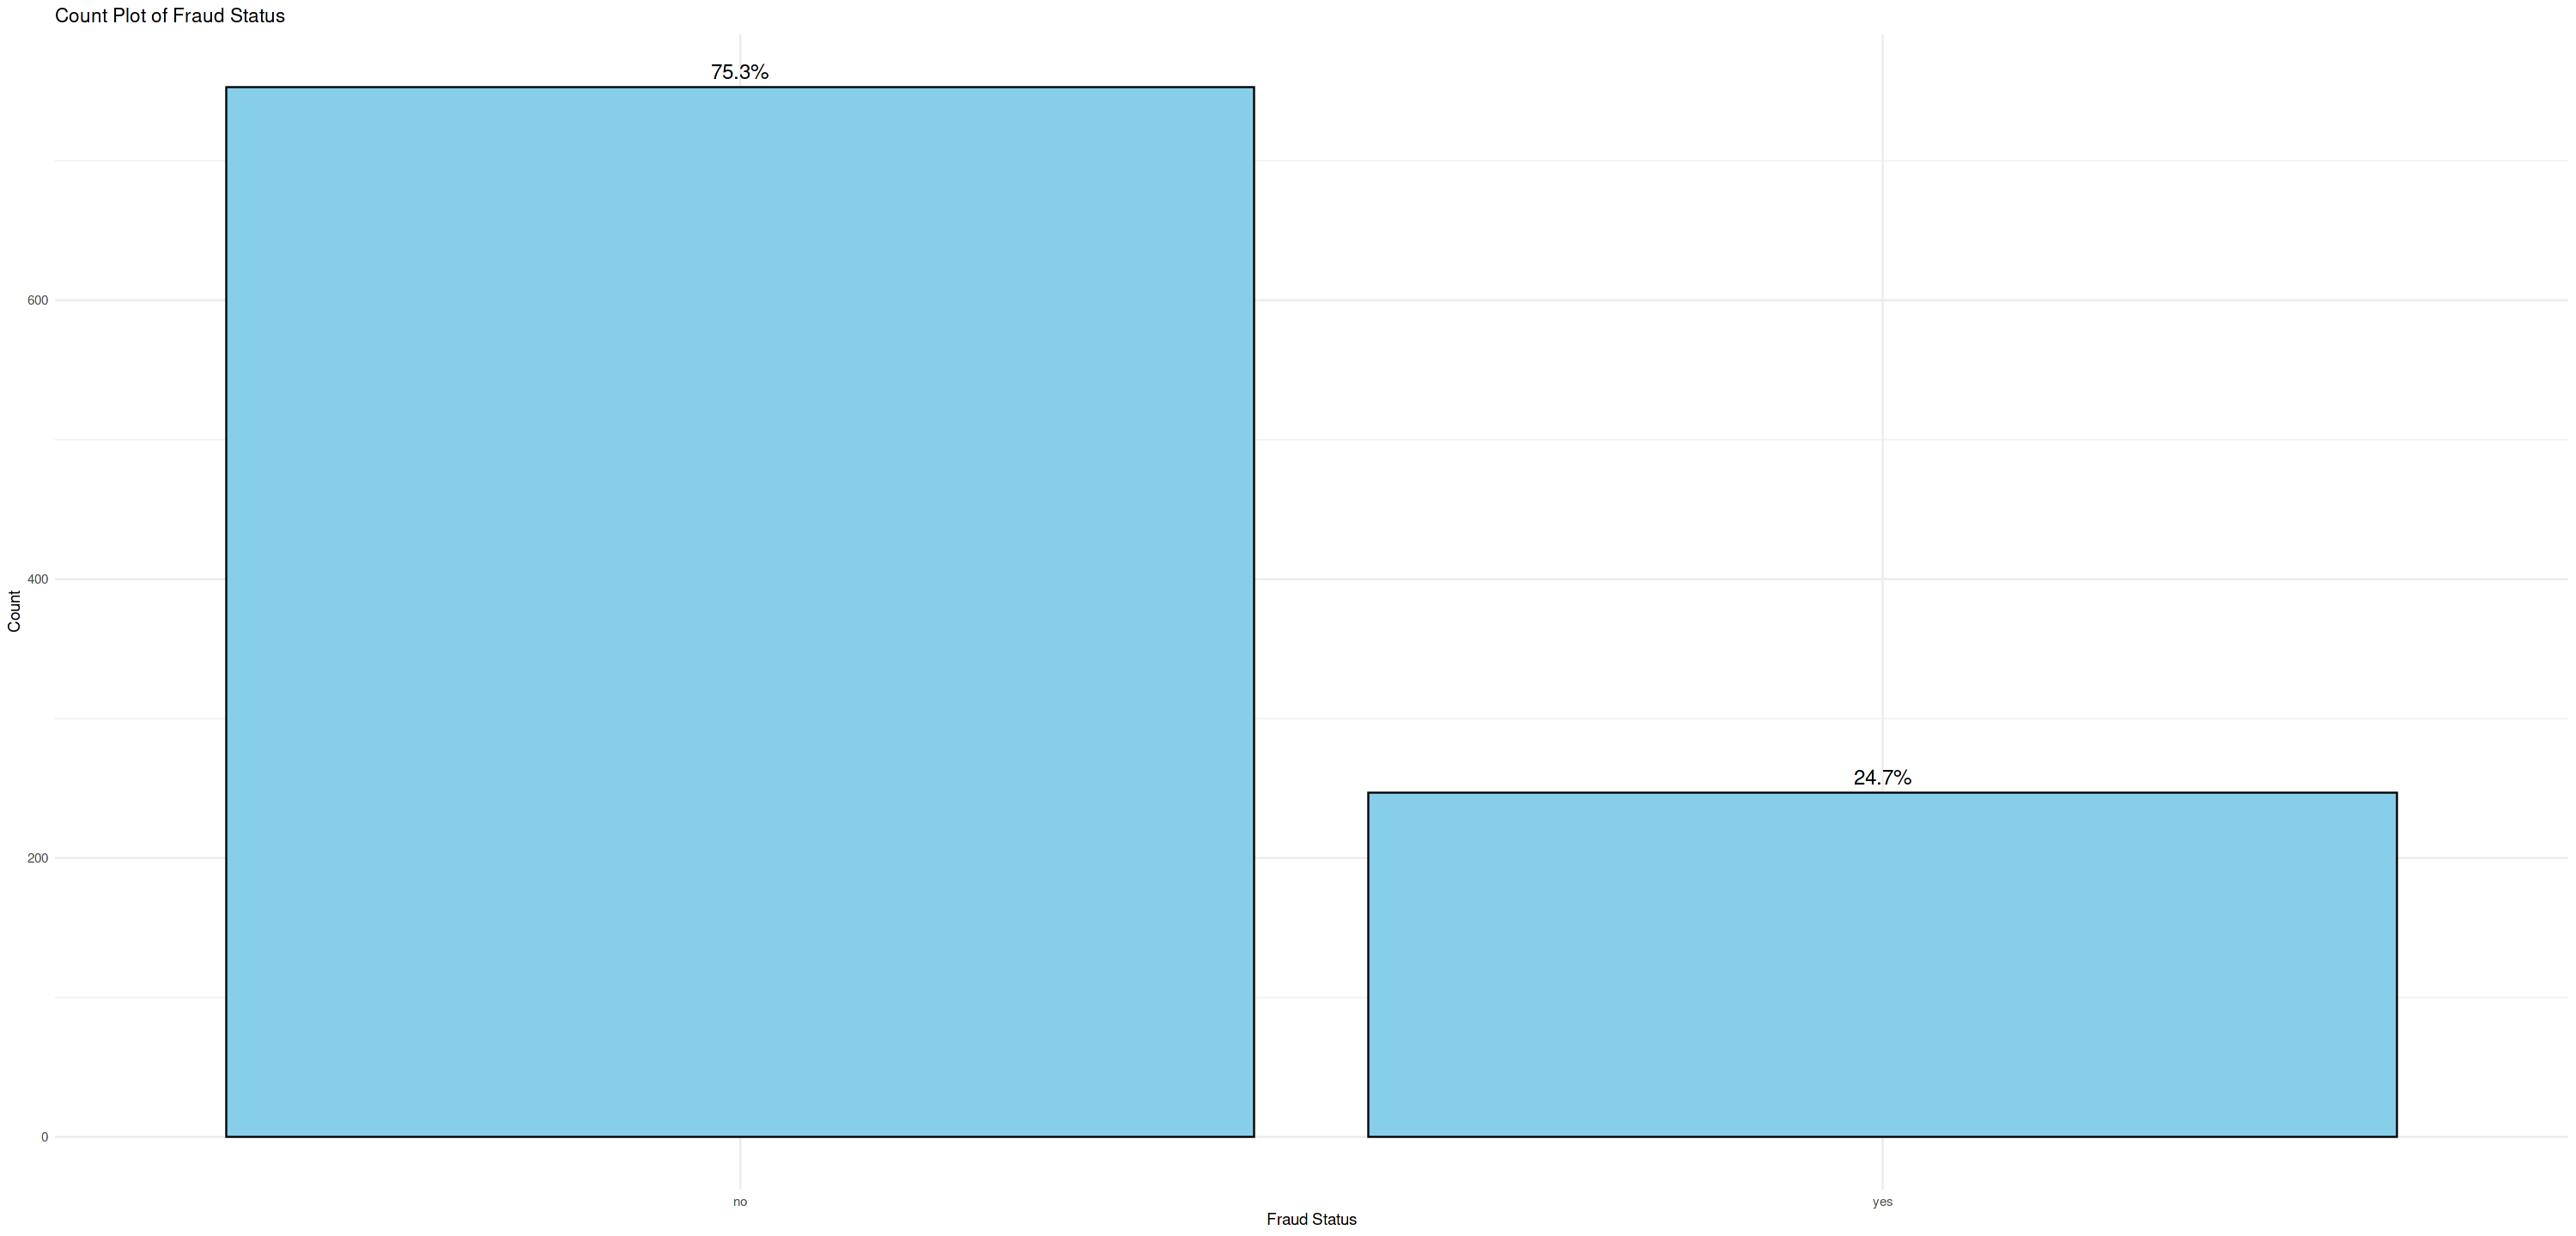

In [37]:
# Membuat diagram batang menggunakan ggplot2 untuk kolom 'fraud_reported'
ggplot(df4, aes(x = fraud_reported)) + 
  geom_bar(aes(y = ..count..), fill = "skyblue", color = "black") +  # Menambahkan geometri batang
  geom_text(aes(label = paste0(round(100 * (..count.. / sum(..count..)), 1), "%"), y = ..count..),
            stat = "count", vjust = -0.5, size = 5) +  # Menambahkan label teks yang menunjukkan persentase
  labs(title = "Count Plot of Fraud Status", x = "Fraud Status", y = "Count") + 
  theme_minimal()  # Tema minimal untuk tampilan yang lebih bersih


### 4.1.2 Numerical Variables 

$mfrow
[1] 4 5

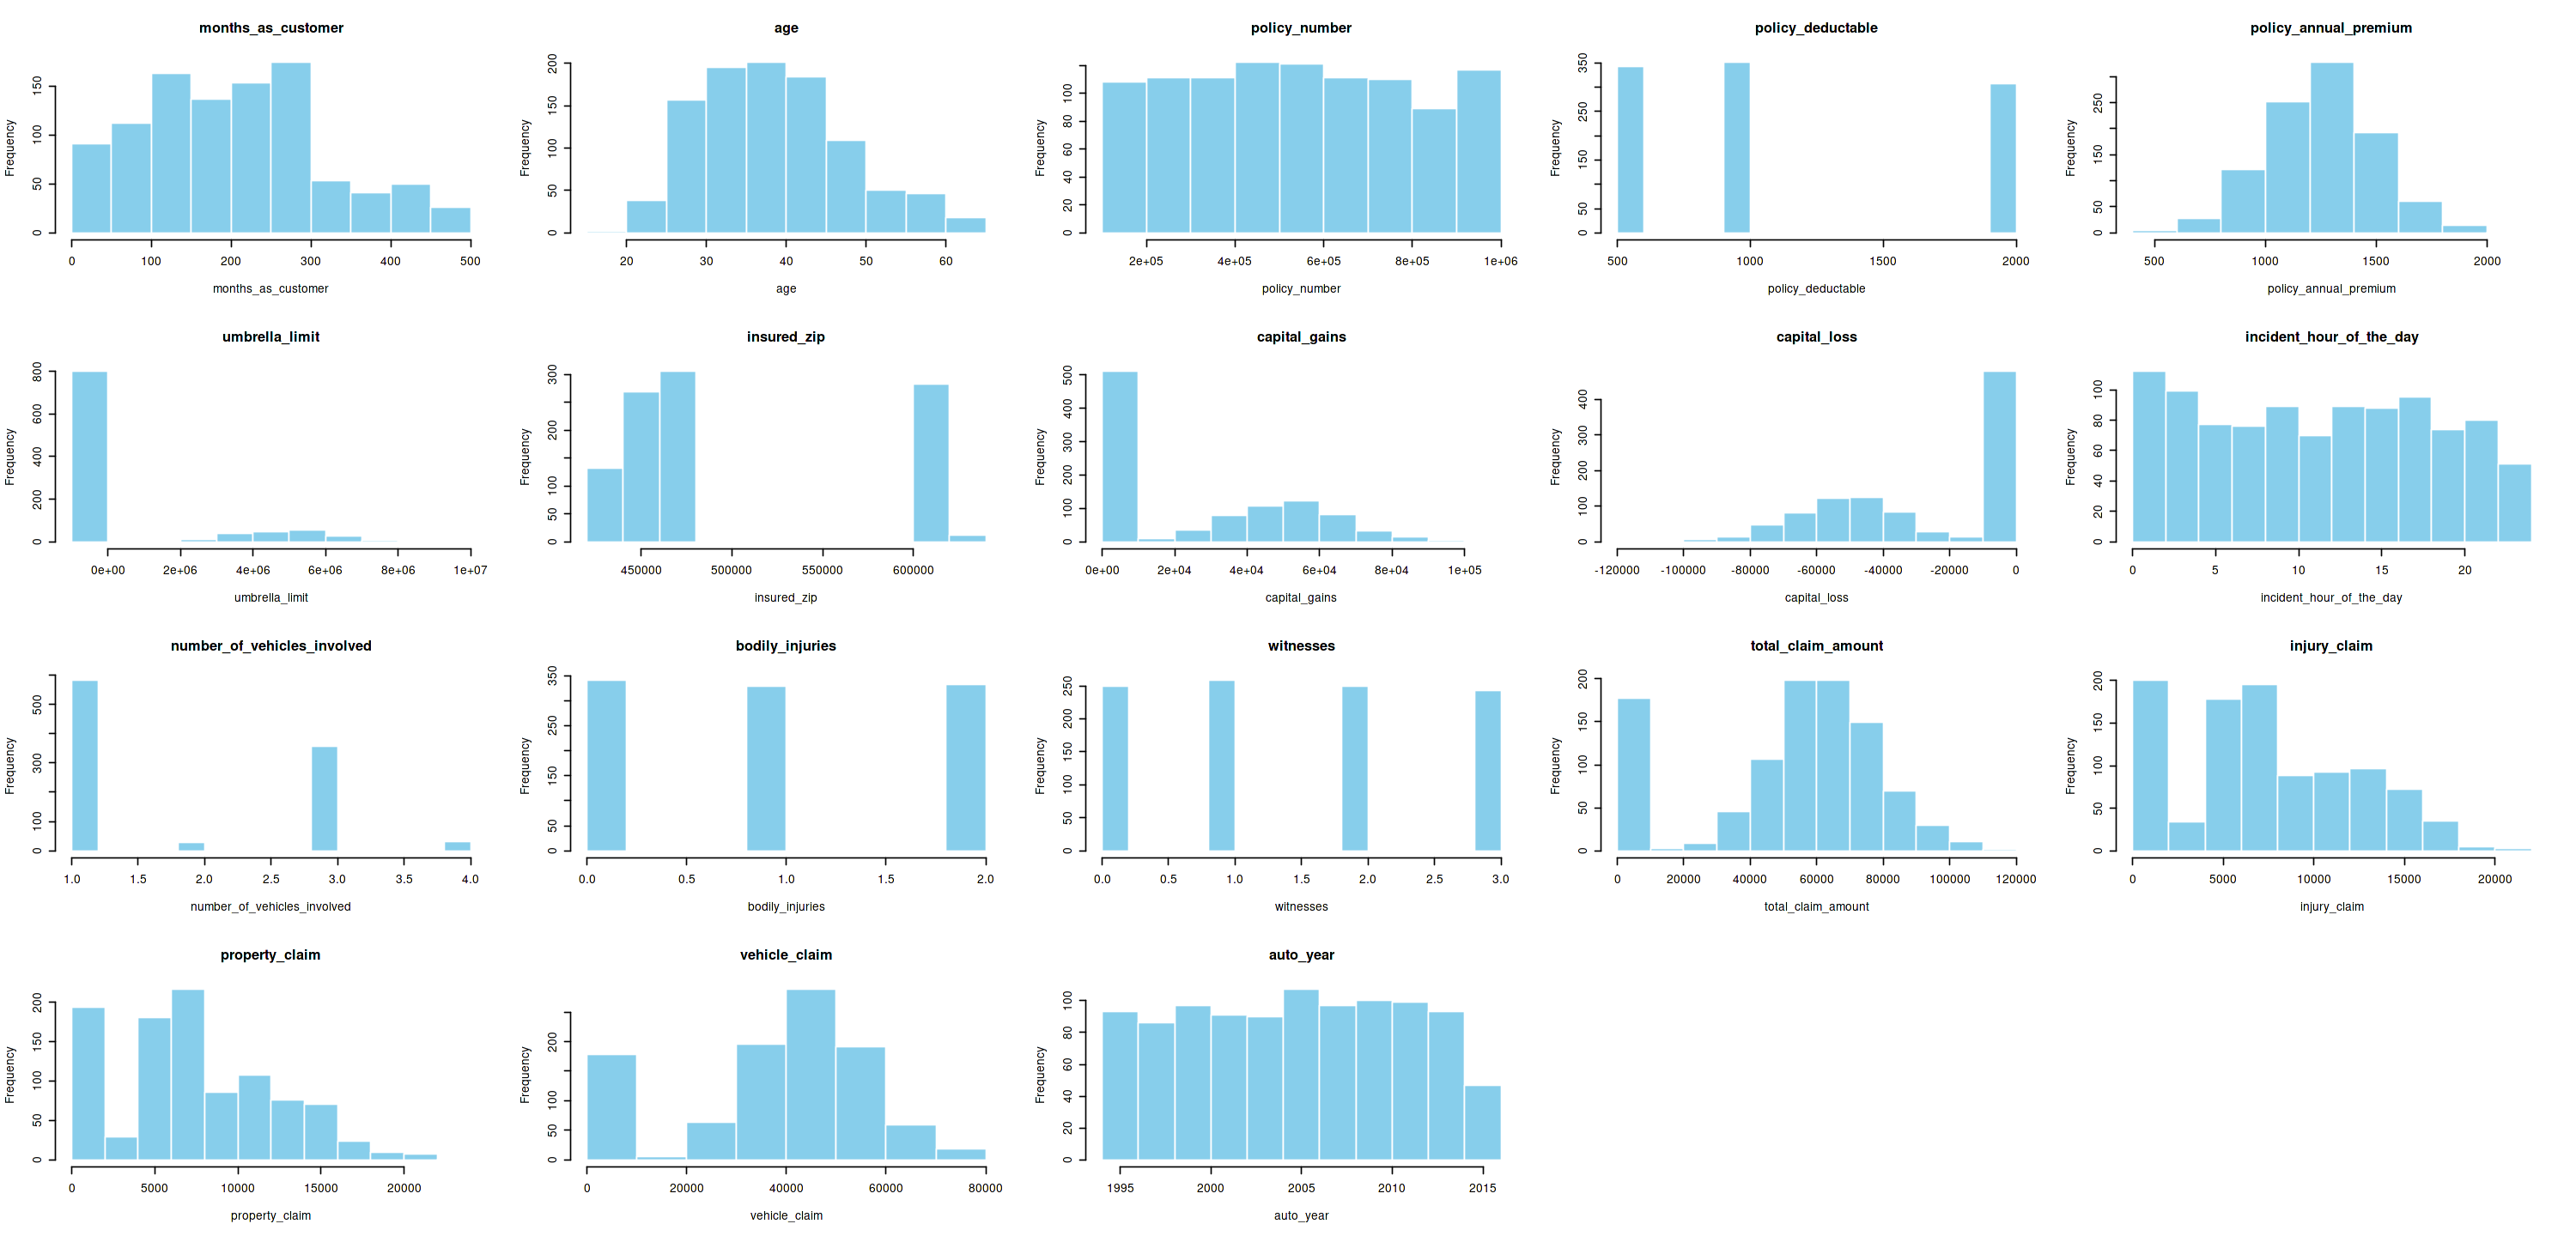

In [38]:
# Plot univariat untuk atribut numerik
Num_plot <- univariate_plot(df4, type_attributes = "numeric")
Num_plot

### 4.1.3 Categorical Variables

$mfrow
[1] 5 5

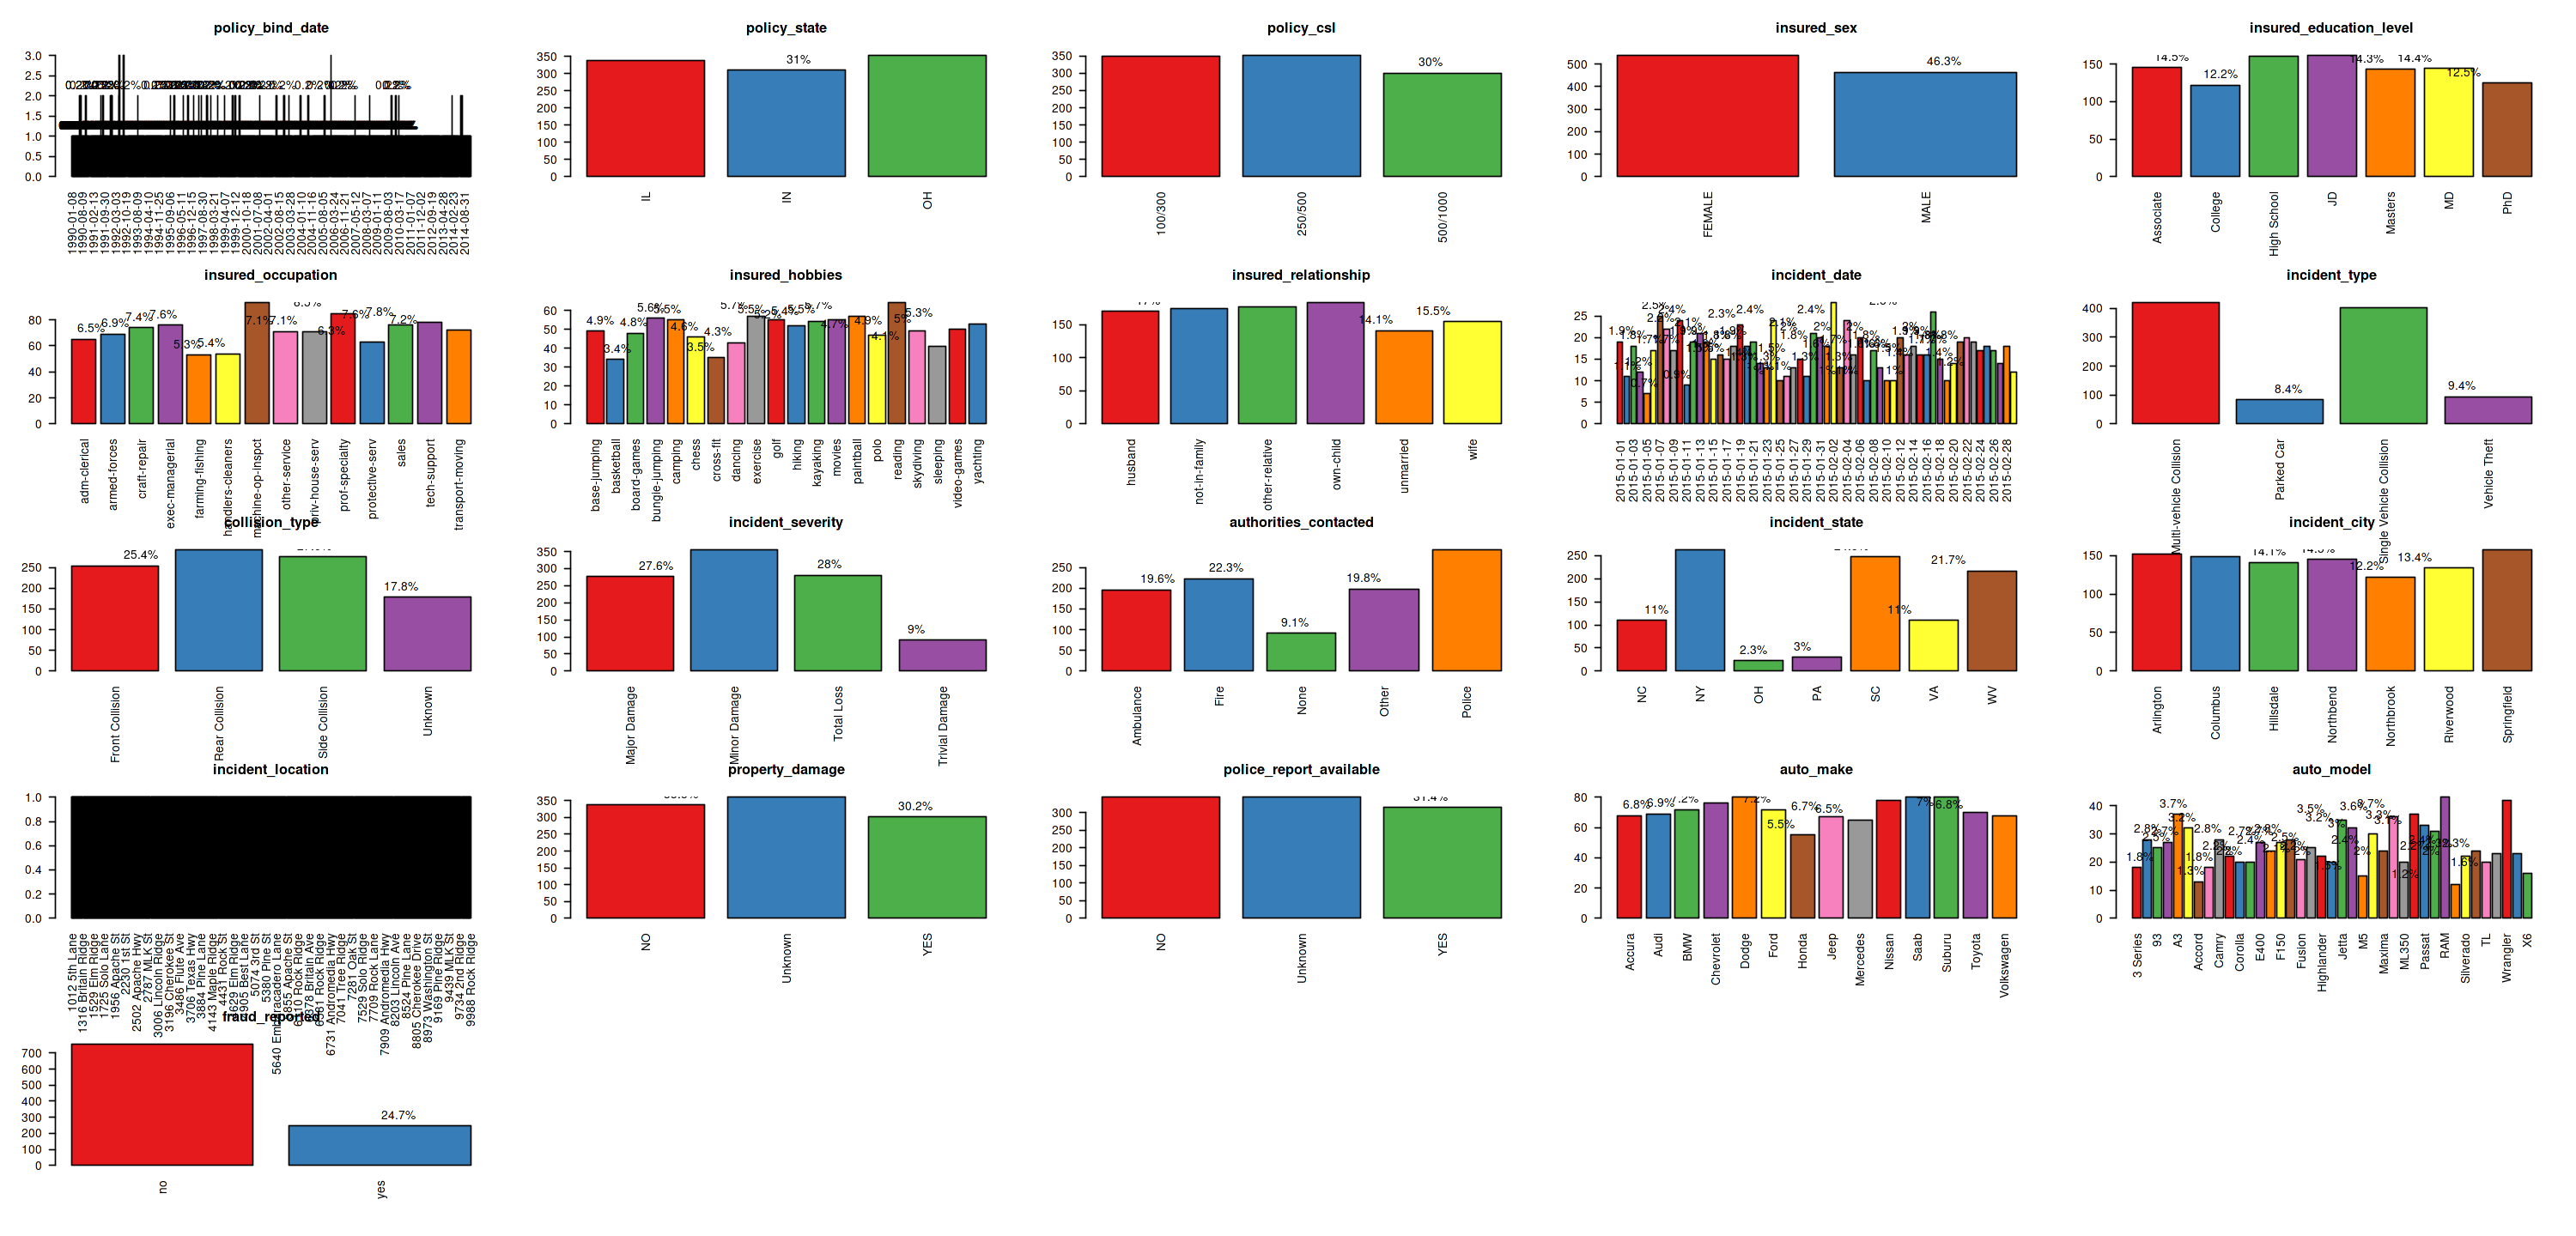

In [39]:
# Plot univariat untuk atribut kategorikal
Cat_plot <- univariate_plot(df4, type_attributes = "categorical")
Cat_plot

## 4.2 Bivariate Analysis 

## H1 40% dari klaim terkait Multi-vehicle collision menunjukkan indikasi fraud.

**FALSE** :

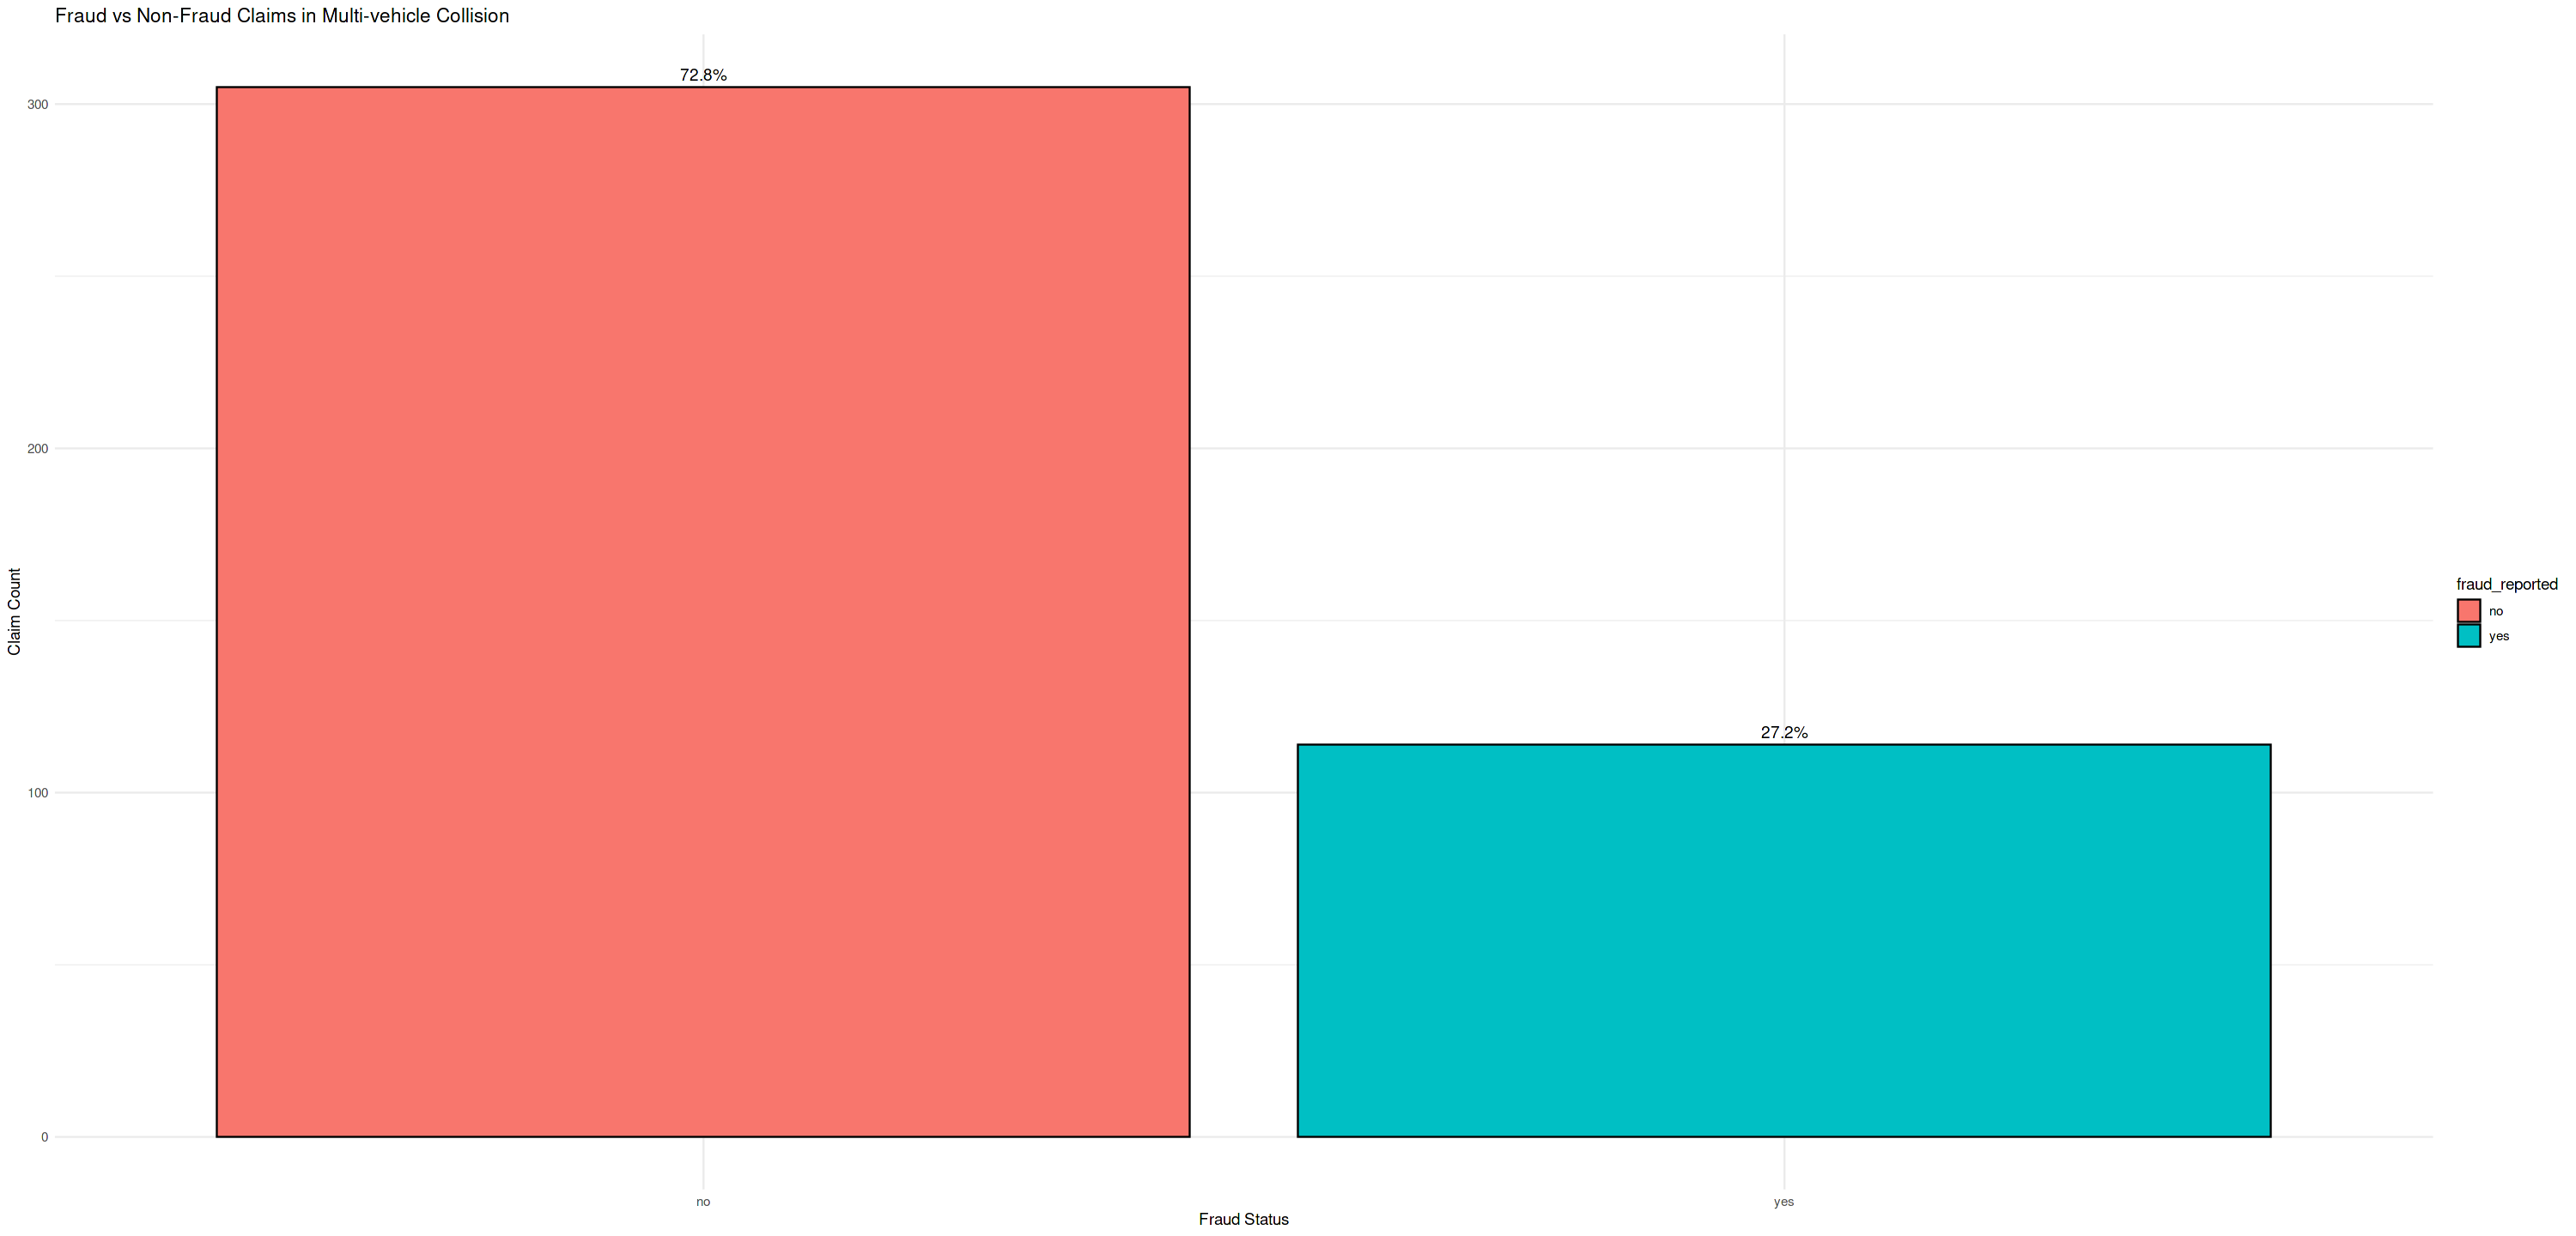

In [40]:
# Memfilter data untuk klaim dengan 'Multi-vehicle Collision'
multi_vehicle_collision_data <- df4 %>% filter(incident_type == "Multi-vehicle Collision")

# Menyusun ringkasan klaim penipuan untuk 'Multi-vehicle Collision' dan membuat plot jumlah klaim
fraud_summary <- multi_vehicle_collision_data %>%
  group_by(fraud_reported) %>%
  summarise(count = n())

ggplot(fraud_summary, aes(x = fraud_reported, y = count, fill = fraud_reported)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = paste0(round((count / sum(count)) * 100, 1), "%")), vjust = -0.5) +
  labs(title = "Fraud vs Non-Fraud Claims in Multi-vehicle Collision", 
       x = "Fraud Status", y = "Claim Count") +
  theme_minimal()

## H2 80% Klaim fraud lebih sering diajukan oleh nasabah yang baru mendaftar ( kurang 12 bulan).

**FALSE** :

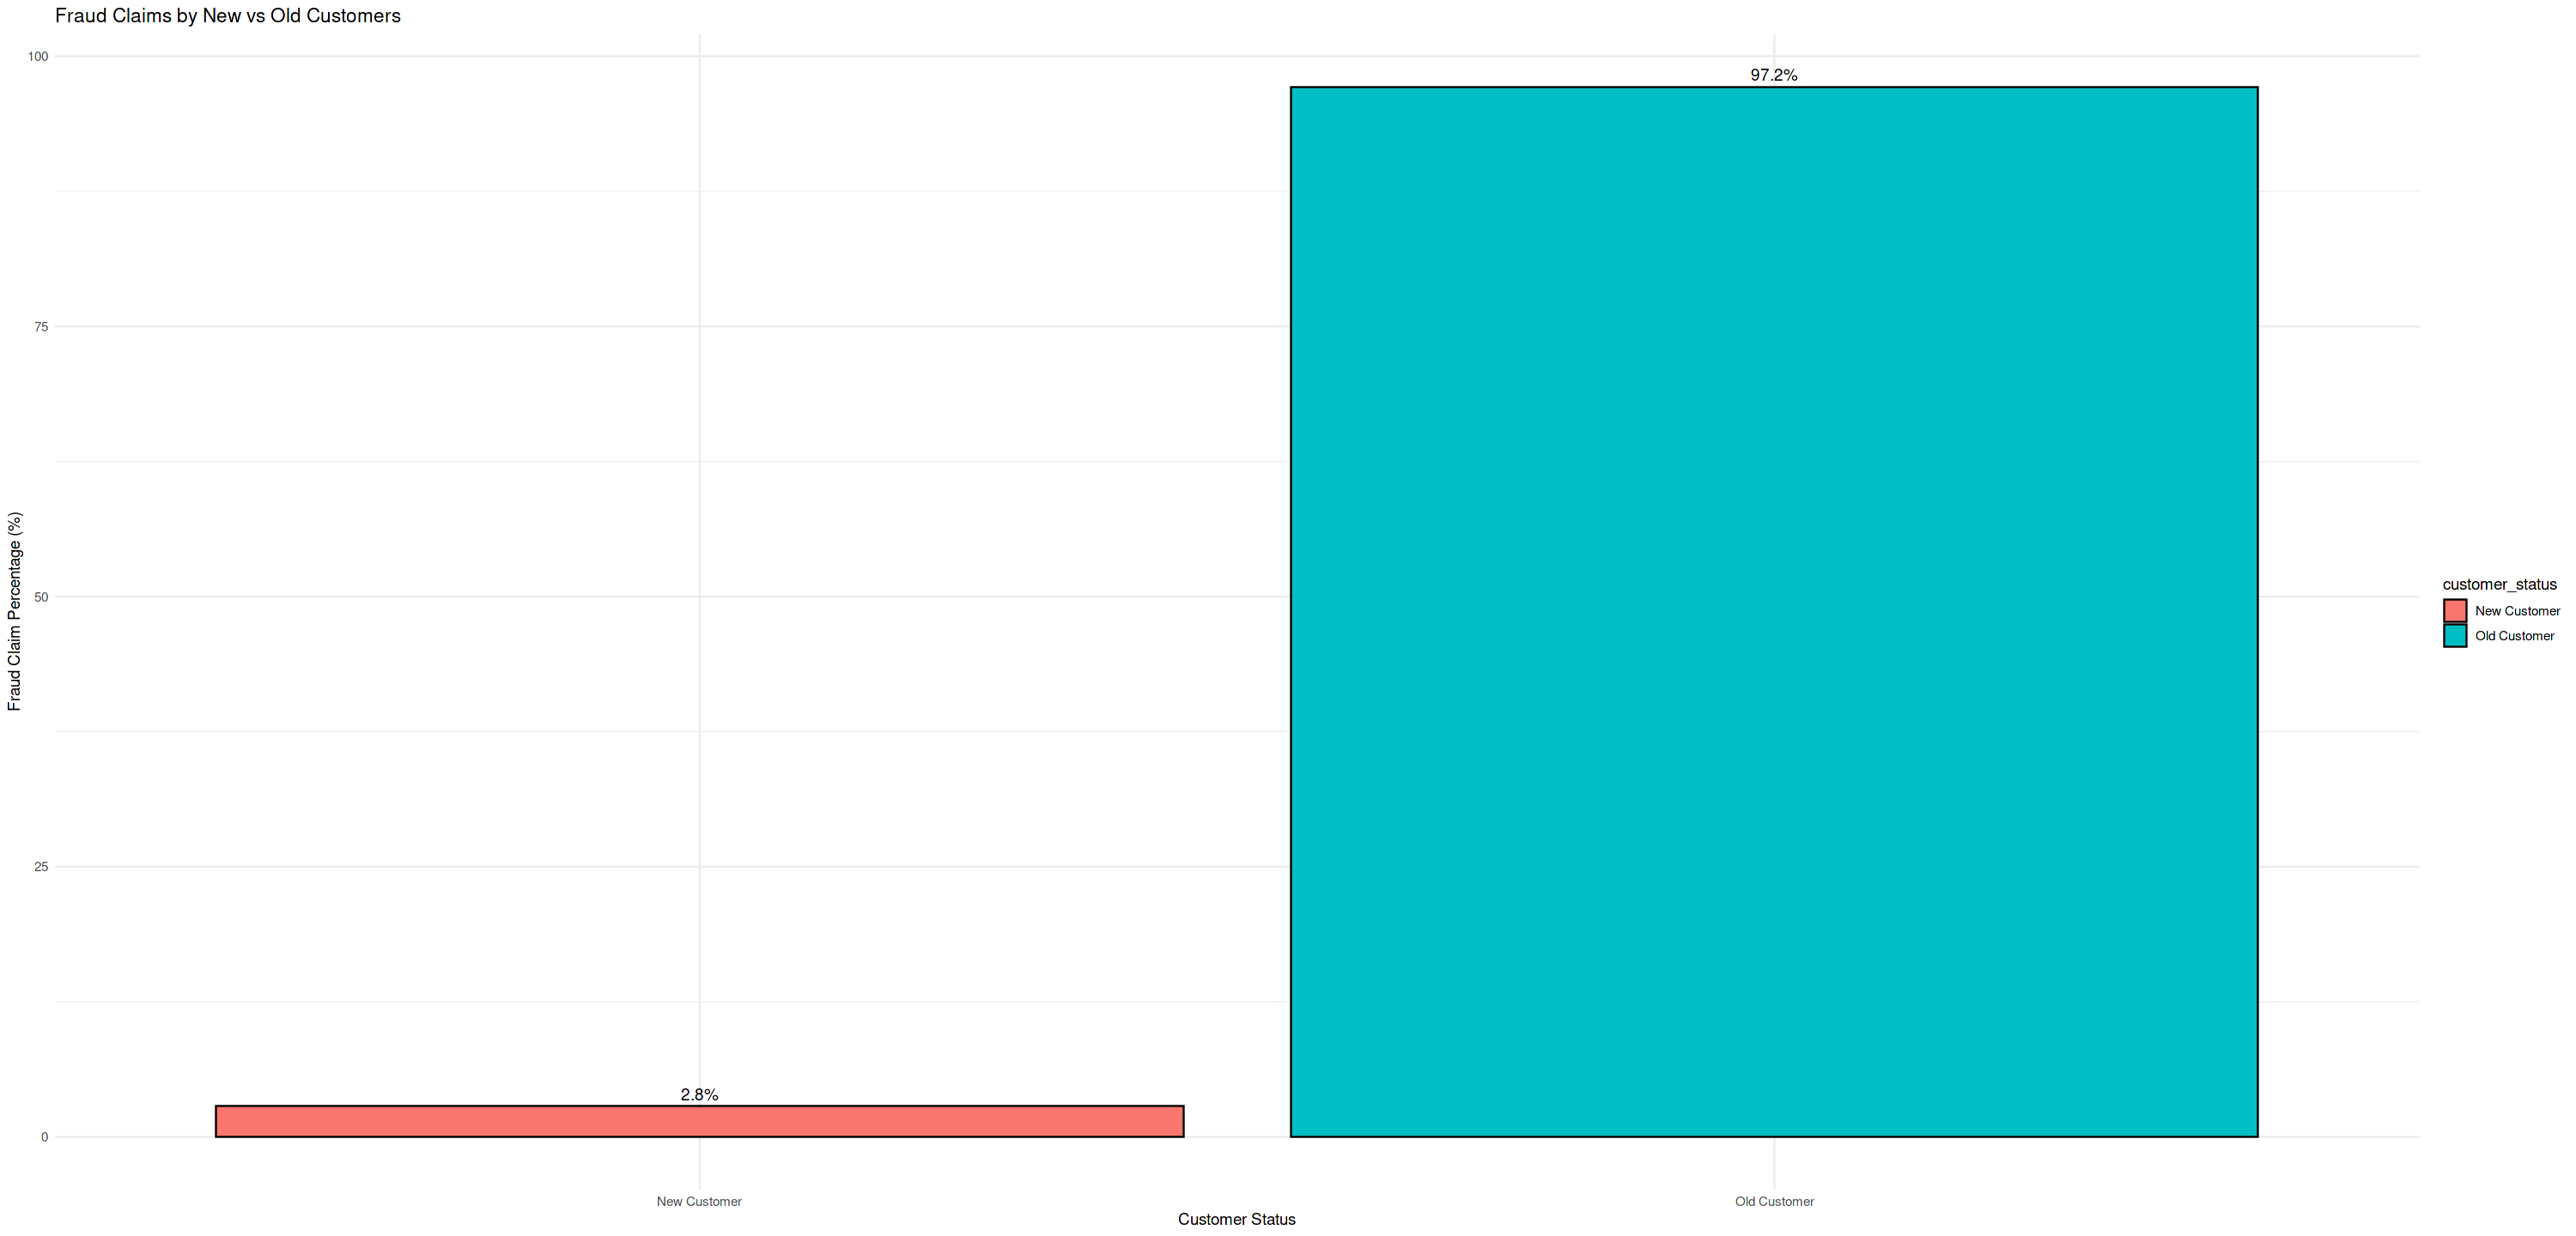

In [41]:
# Memfilter klaim penipuan dan mengkategorikan pelanggan ke dalam "Baru" atau "Lama" berdasarkan masa berlangganan mereka
fraud_by_customer <- df4 %>%
  filter(fraud_reported == "yes") %>%
  mutate(customer_status = ifelse(months_as_customer < 12, "New Customer", "Old Customer")) %>%
  group_by(customer_status) %>%
  summarize(count = n(), .groups = "drop") %>%
  mutate(percentage = (count / sum(count)) * 100)

# Membuat plot klaim penipuan berdasarkan status pelanggan
ggplot(fraud_by_customer, aes(x = customer_status, y = percentage, fill = customer_status)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = paste0(round(percentage, 1), "%")), vjust = -0.5) +
  labs(title = "Fraud Claims by New vs Old Customers", 
       x = "Customer Status", y = "Fraud Claim Percentage (%)") +
  theme_minimal()


## H3 Pria berusia antara 25 hingga 40 tahun lebih cenderung mengajukan klaim fraud.

**TRUE** :

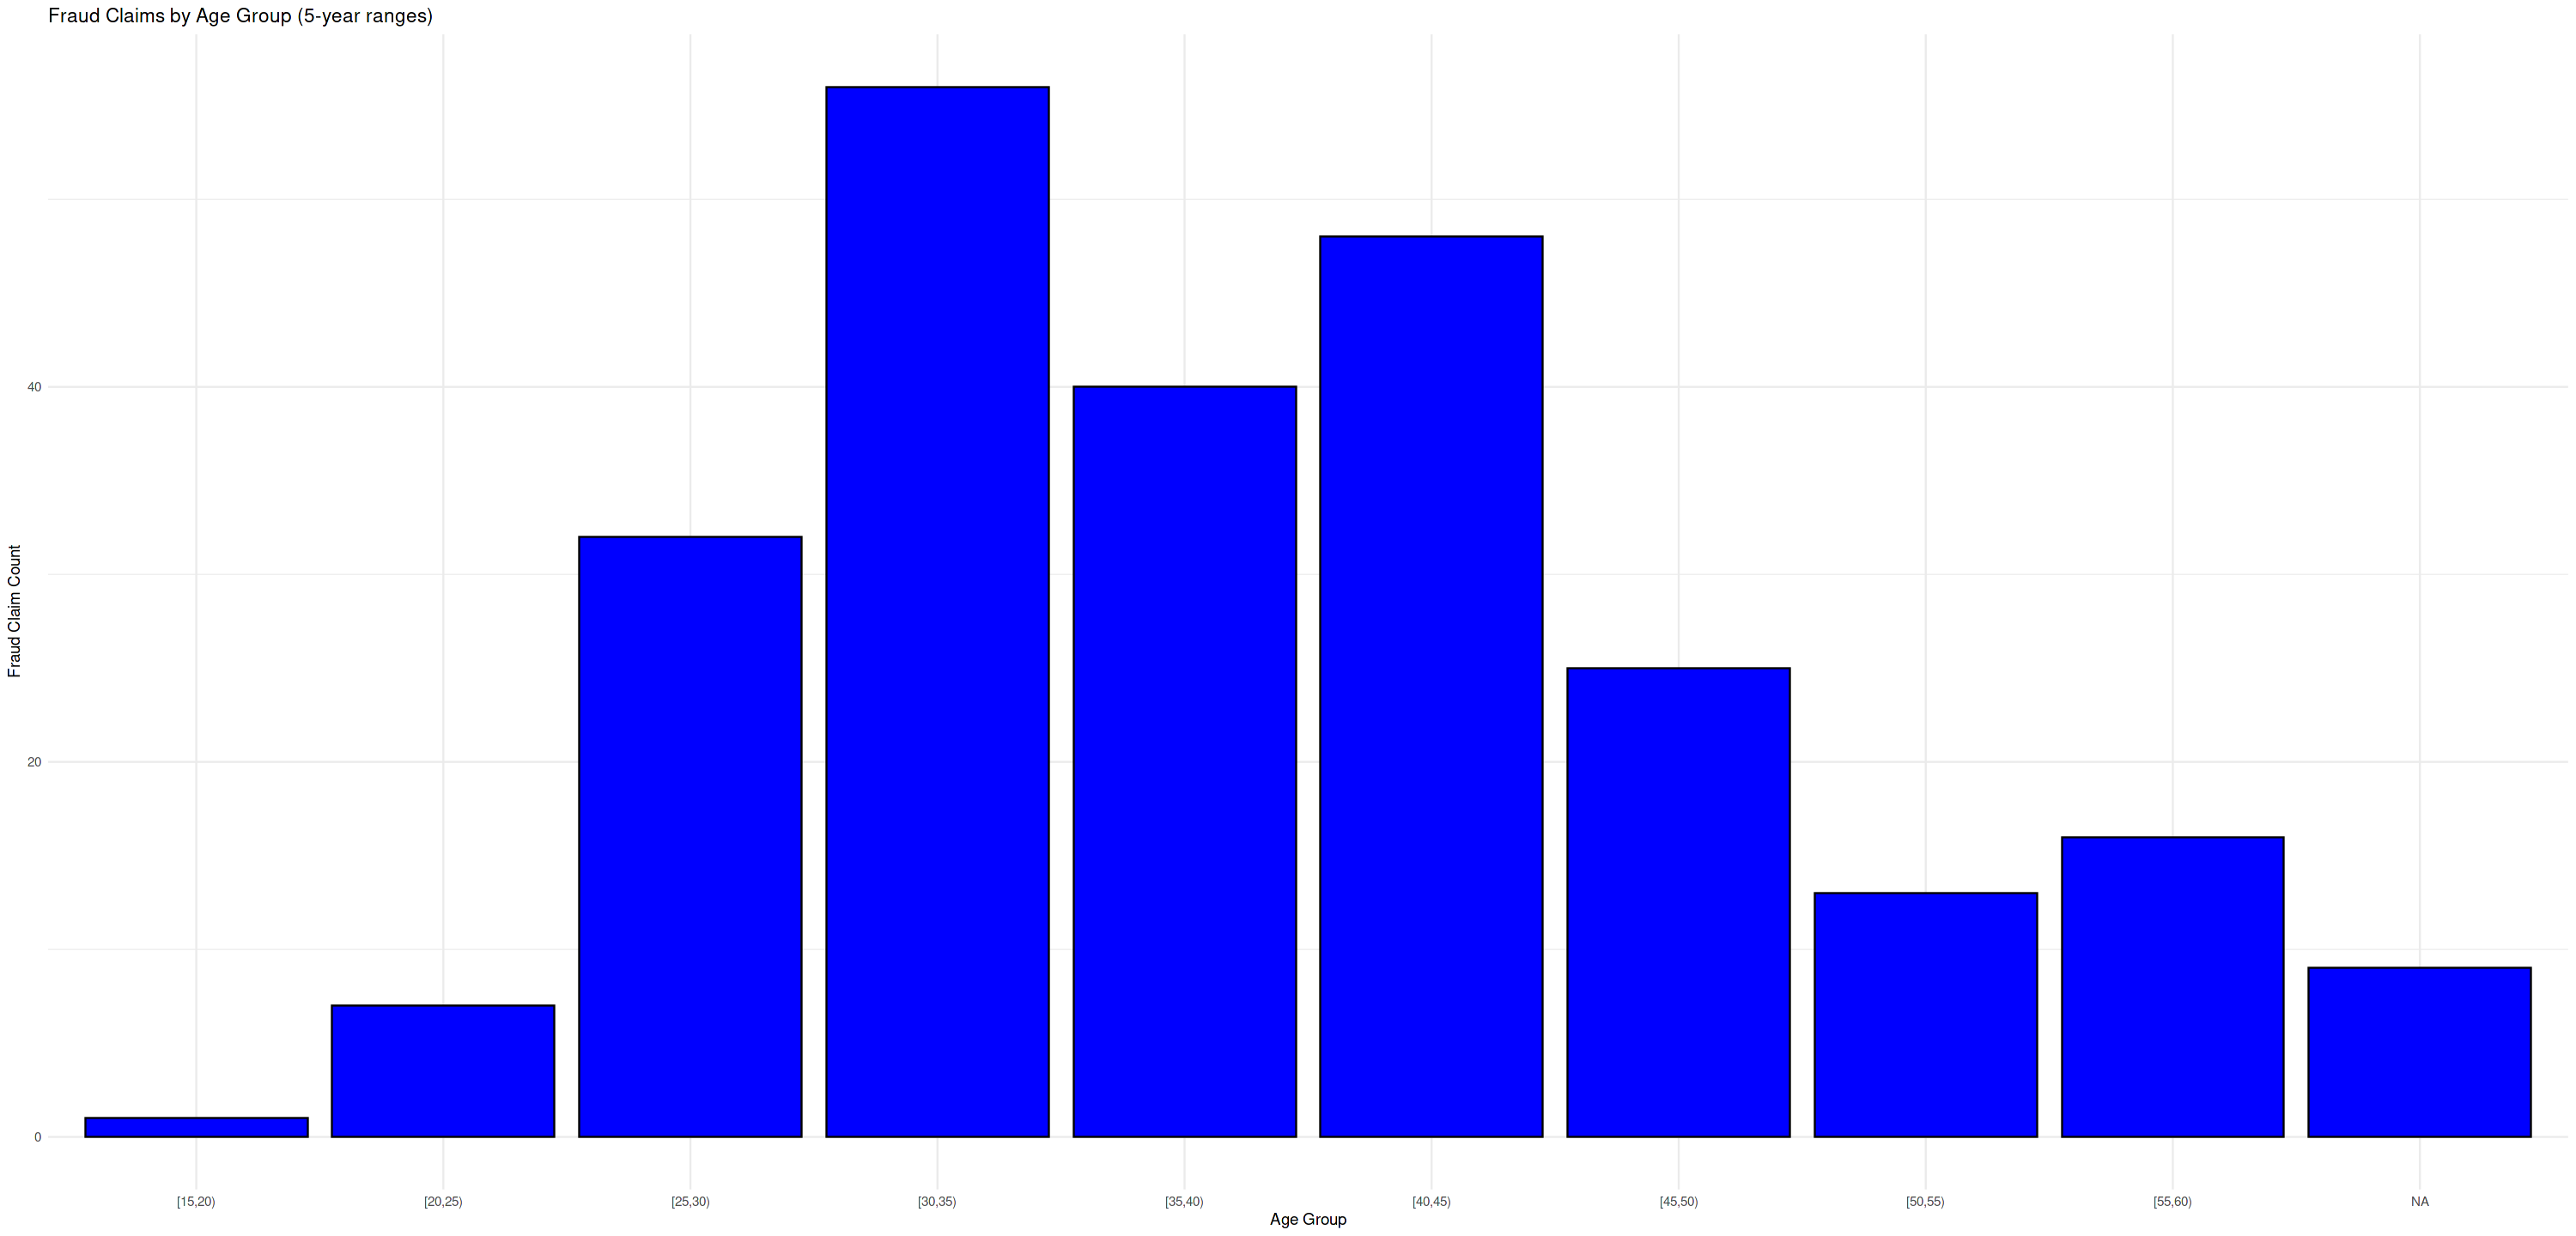

In [42]:
# Memfilter klaim penipuan, mengkategorikan berdasarkan kelompok umur, dan membuat plot distribusi penipuan berdasarkan kelompok umur
fraud_per_age_group <- df4 %>%
  filter(fraud_reported == 'yes') %>%
  mutate(age_group = cut(age, breaks = seq(0, max(age), by = 5), right = FALSE)) %>%
  count(age_group)

ggplot(fraud_per_age_group, aes(x = age_group, y = n)) +
  geom_bar(stat = "identity", fill = "blue", color = "black") + 
  labs(title = "Fraud Claims by Age Group (5-year ranges)", 
       x = "Age Group", y = "Fraud Claim Count") +
  theme_minimal()

## H4 Klaim dengan jumlah kecil (<10,000) lebih sering valid, dengan sekitar 80% klaim untuk jumlah kecil terbukti sah.

**TRUE** :

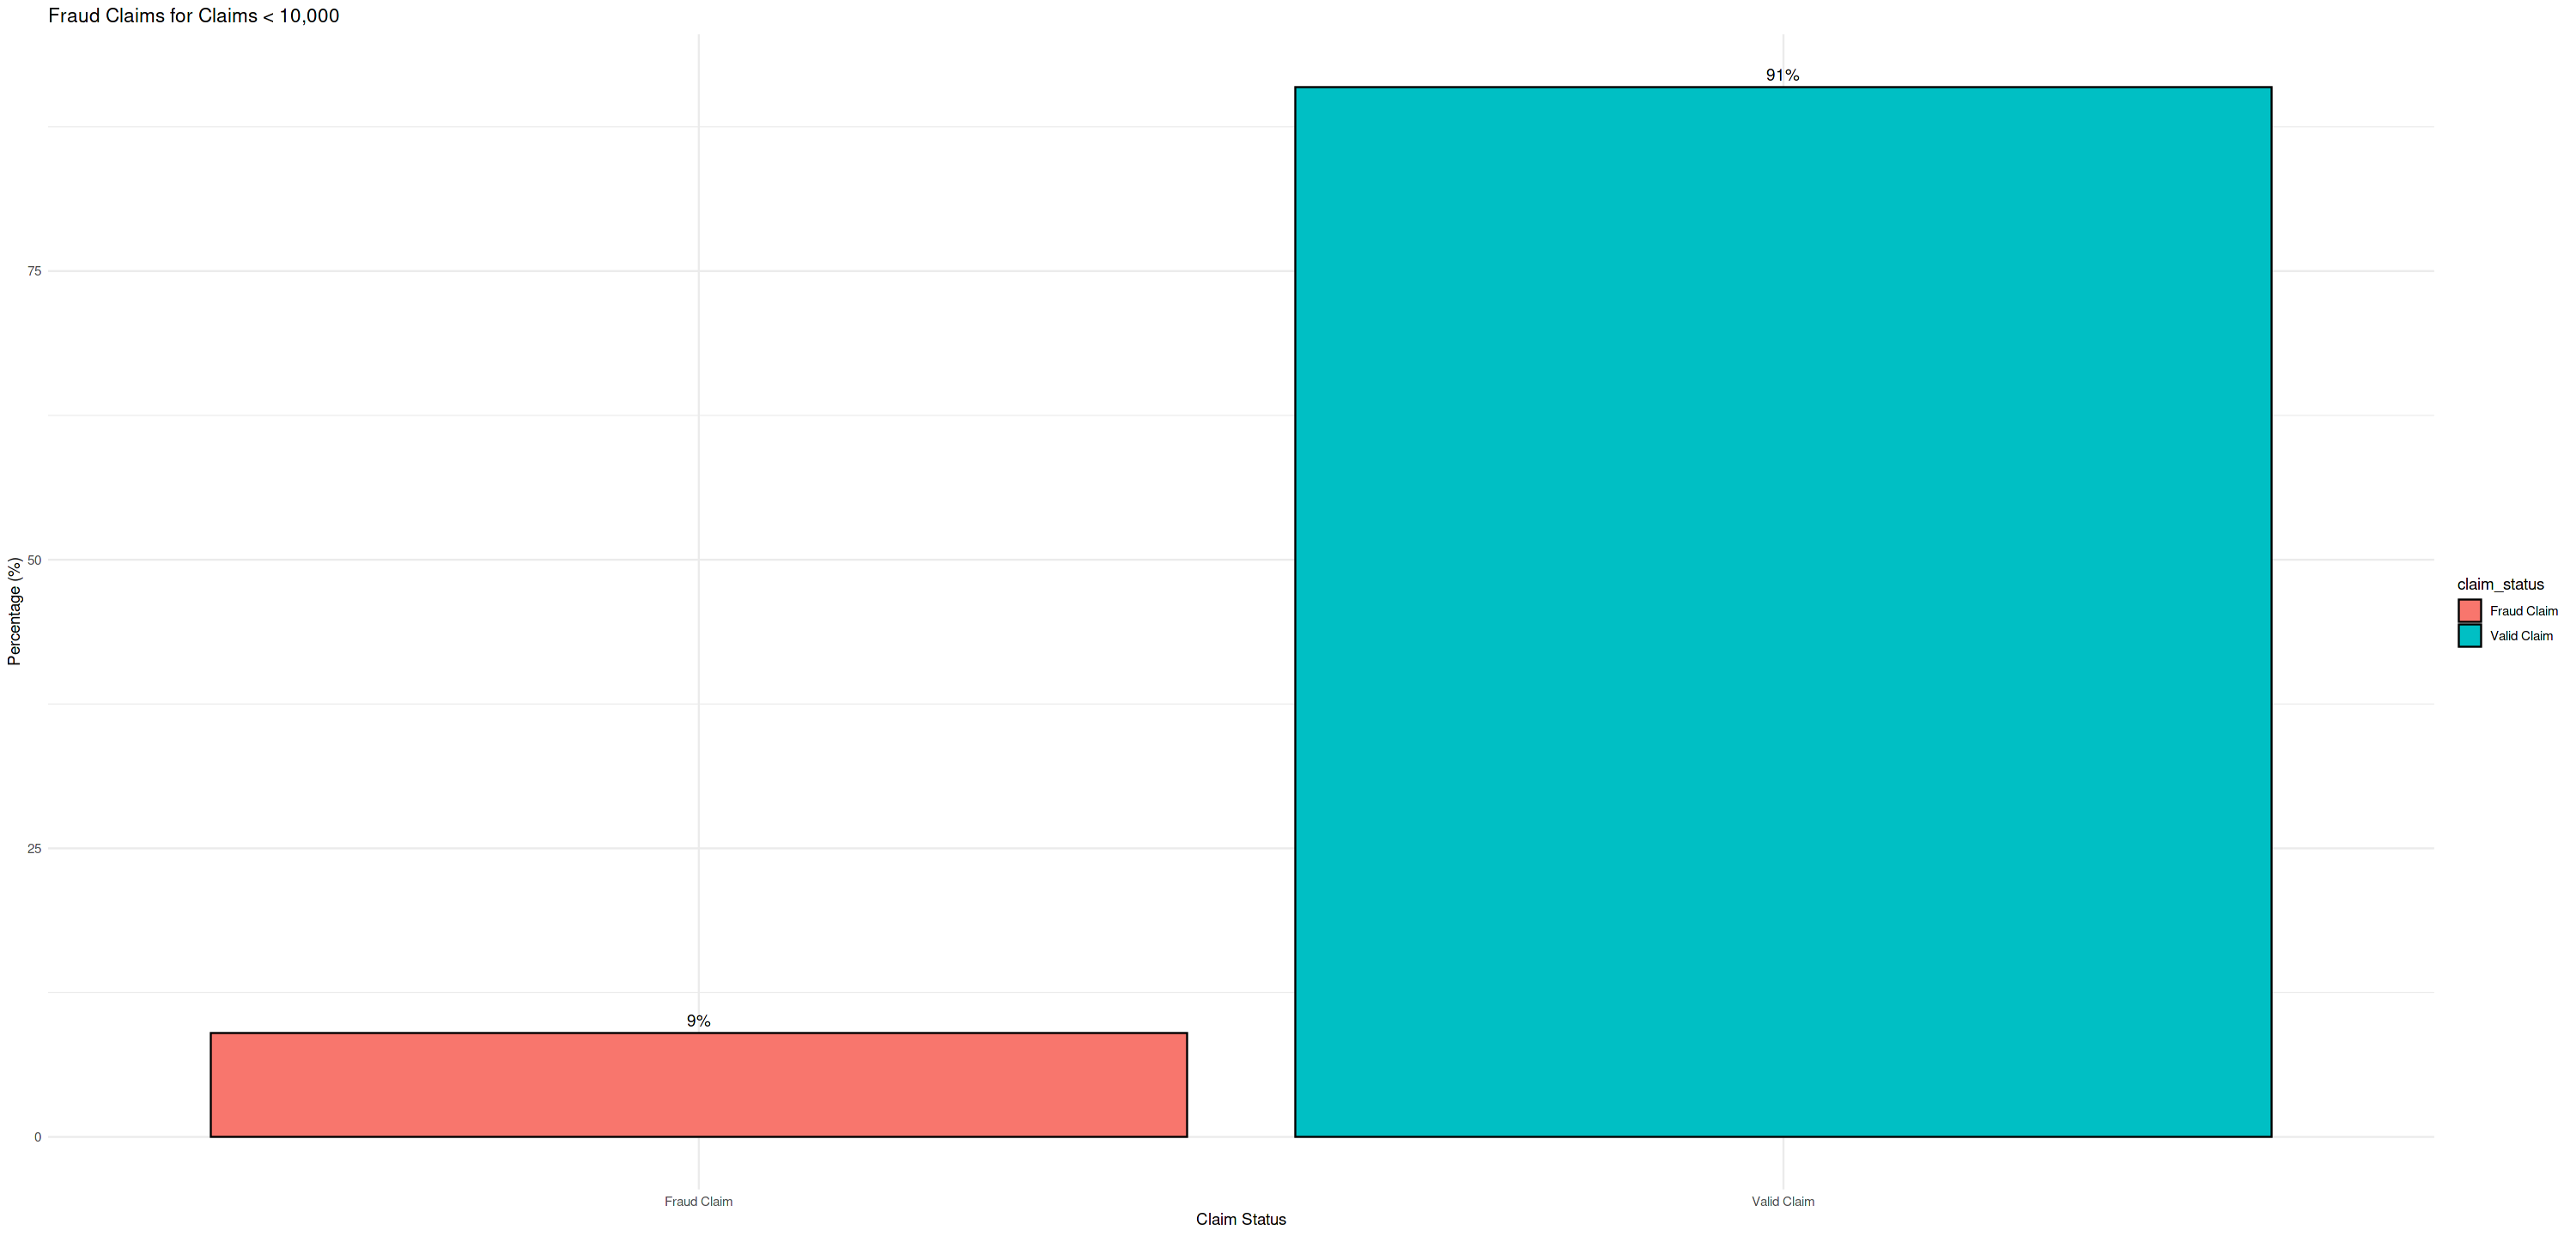

In [43]:
# Menyaring klaim kecil dan mengkategorikannya berdasarkan status penipuan
small_claims_status <- df4 %>%
  filter(total_claim_amount < 10000) %>%
  mutate(claim_status = if_else(fraud_reported == "yes", "Fraud Claim", "Valid Claim")) %>%
  group_by(claim_status) %>%
  summarize(count = n(), .groups = "drop") %>%
  mutate(percentage = (count / sum(count)) * 100)

# Membuat plot klaim penipuan untuk klaim kecil
ggplot(small_claims_status, aes(x = claim_status, y = percentage, fill = claim_status)) +
  geom_bar(stat = "identity", color = "black") +
  geom_text(aes(label = paste0(round(percentage, 1), "%")), vjust = -0.5) +
  labs(title = "Fraud Claims for Claims < 10,000", 
       x = "Claim Status", y = "Percentage (%)") +
  theme_minimal()

## H5 Klaim fraud lebih sering terjadi pada jam malam atau dini hari, dengan 40% klaim yang diajukan pada waktu tersebut terbukti dipalsukan.

**TRUE/FALSE** :

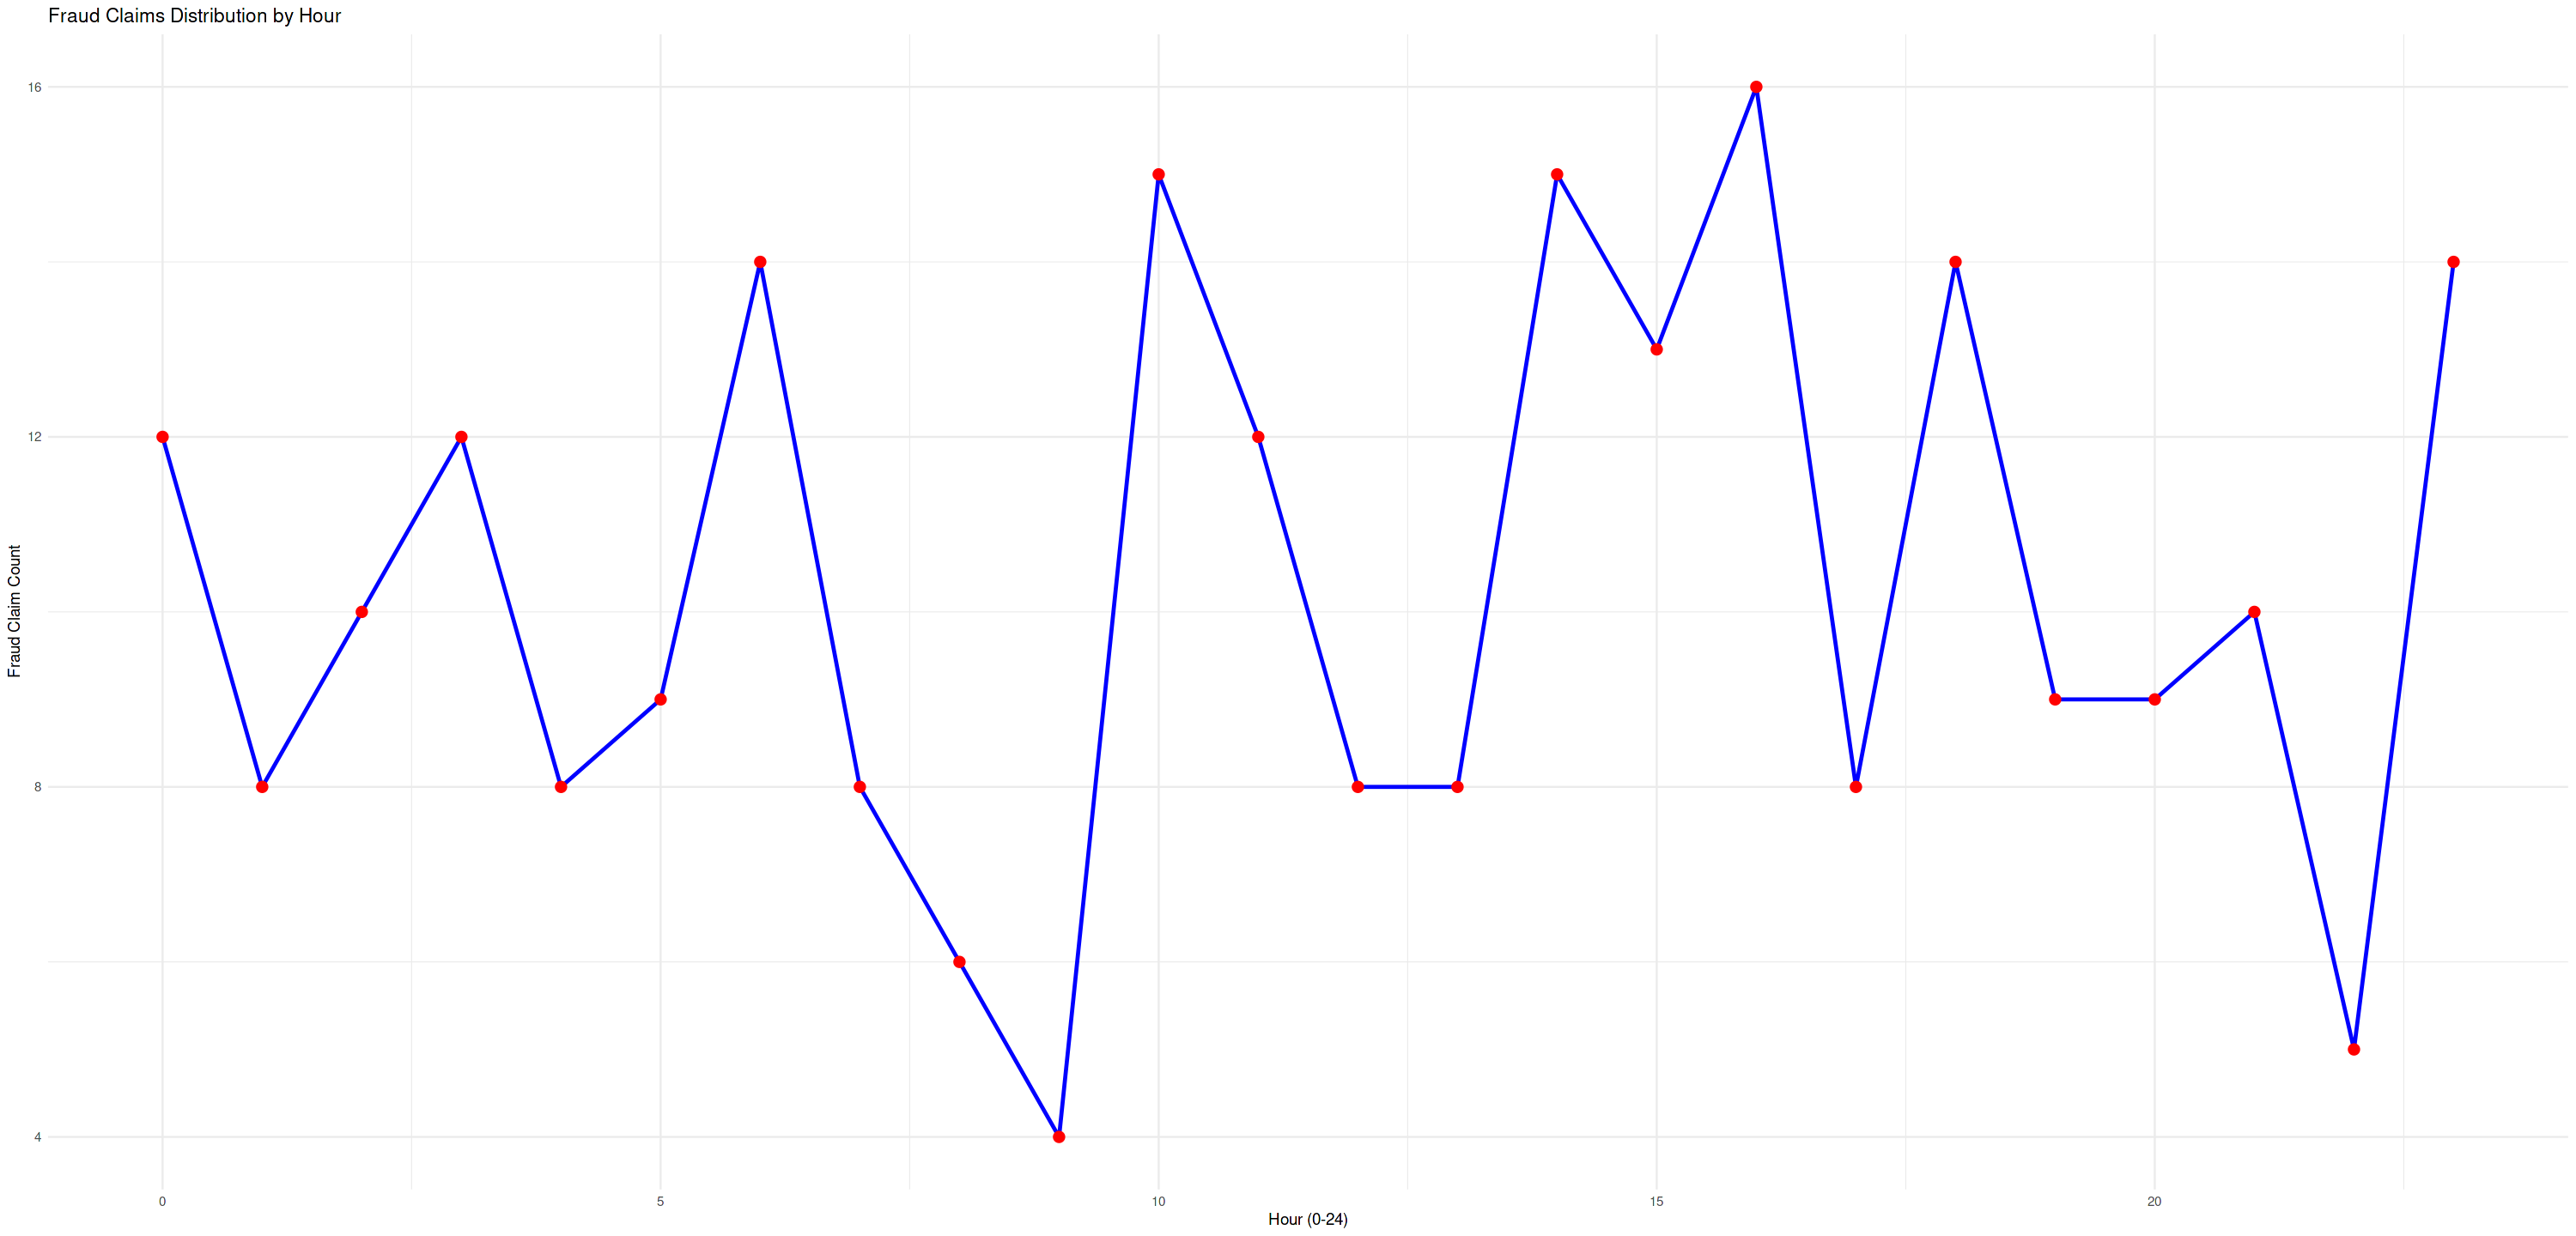

In [44]:
# Menyaring klaim penipuan dan menghitung distribusinya berdasarkan jam kejadian
fraud_data_reported <- df4 %>% filter(fraud_reported == 'yes')

fraud_per_hour <- fraud_data_reported %>%
  group_by(incident_hour_of_the_day) %>%
  summarise(fraud_count = n())

ggplot(fraud_per_hour, aes(x = incident_hour_of_the_day, y = fraud_count)) +
  geom_line(color = "blue", size = 1) + 
  geom_point(color = "red", size = 3) +
  labs(title = "Fraud Claims Distribution by Hour", 
       x = "Hour (0-24)", y = "Fraud Claim Count") +
  theme_minimal()

## H6 Kendaraan seperti Chevrolet memiliki klaim fraud lebih banyak dibandingkan kendaraan honda.

**TRUE** :

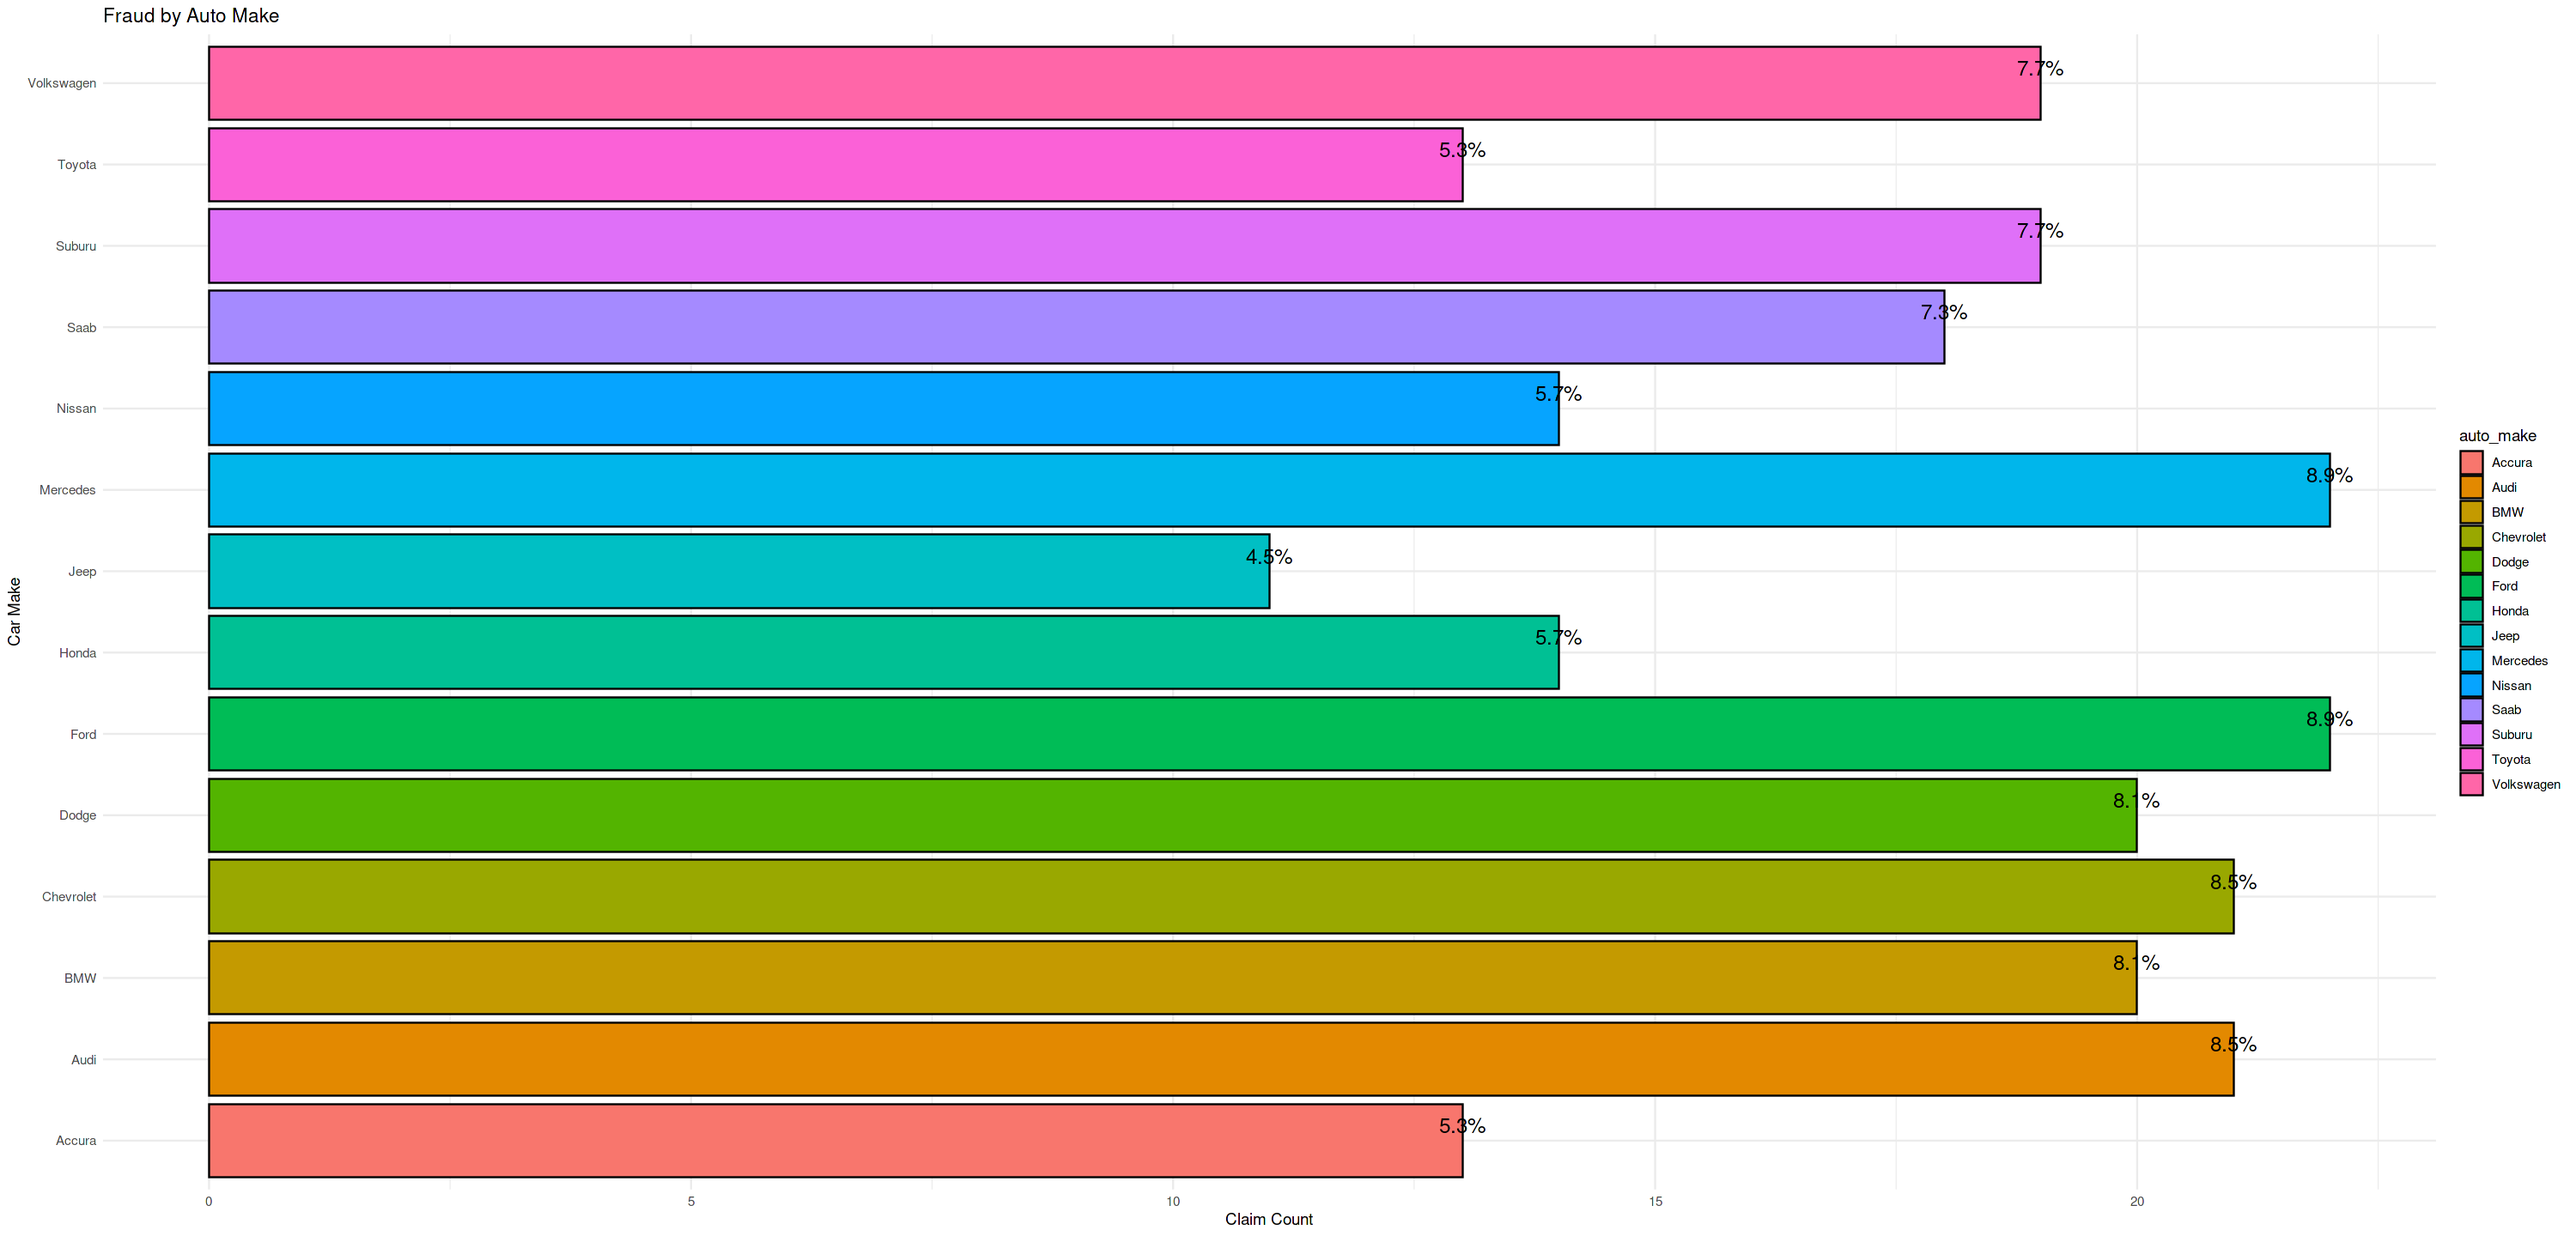

In [45]:
# Menyaring klaim penipuan berdasarkan merek mobil dan membuat plot
df4_fraud <- df4 %>% filter(fraud_reported == "yes")

ggplot(df4_fraud, aes(x = auto_make, fill = auto_make)) +
  geom_bar(position = "dodge", color = "black") +
  geom_text(aes(label = paste0(round(100 * (..count.. / sum(..count..)), 1), "%"), y = ..count..),
            stat = "count", position = position_dodge(width = 0.8), vjust = -0.5, size = 5) +
  labs(title = "Fraud by Auto Make", x = "Car Make", y = "Claim Count") +
  theme_minimal() +
  coord_flip()  # Membalik sumbu untuk grafik batang horizontal

## H7 Klaim tanpa laporan polisi lebih sering fraud sekitar 40%

**FALSE** :

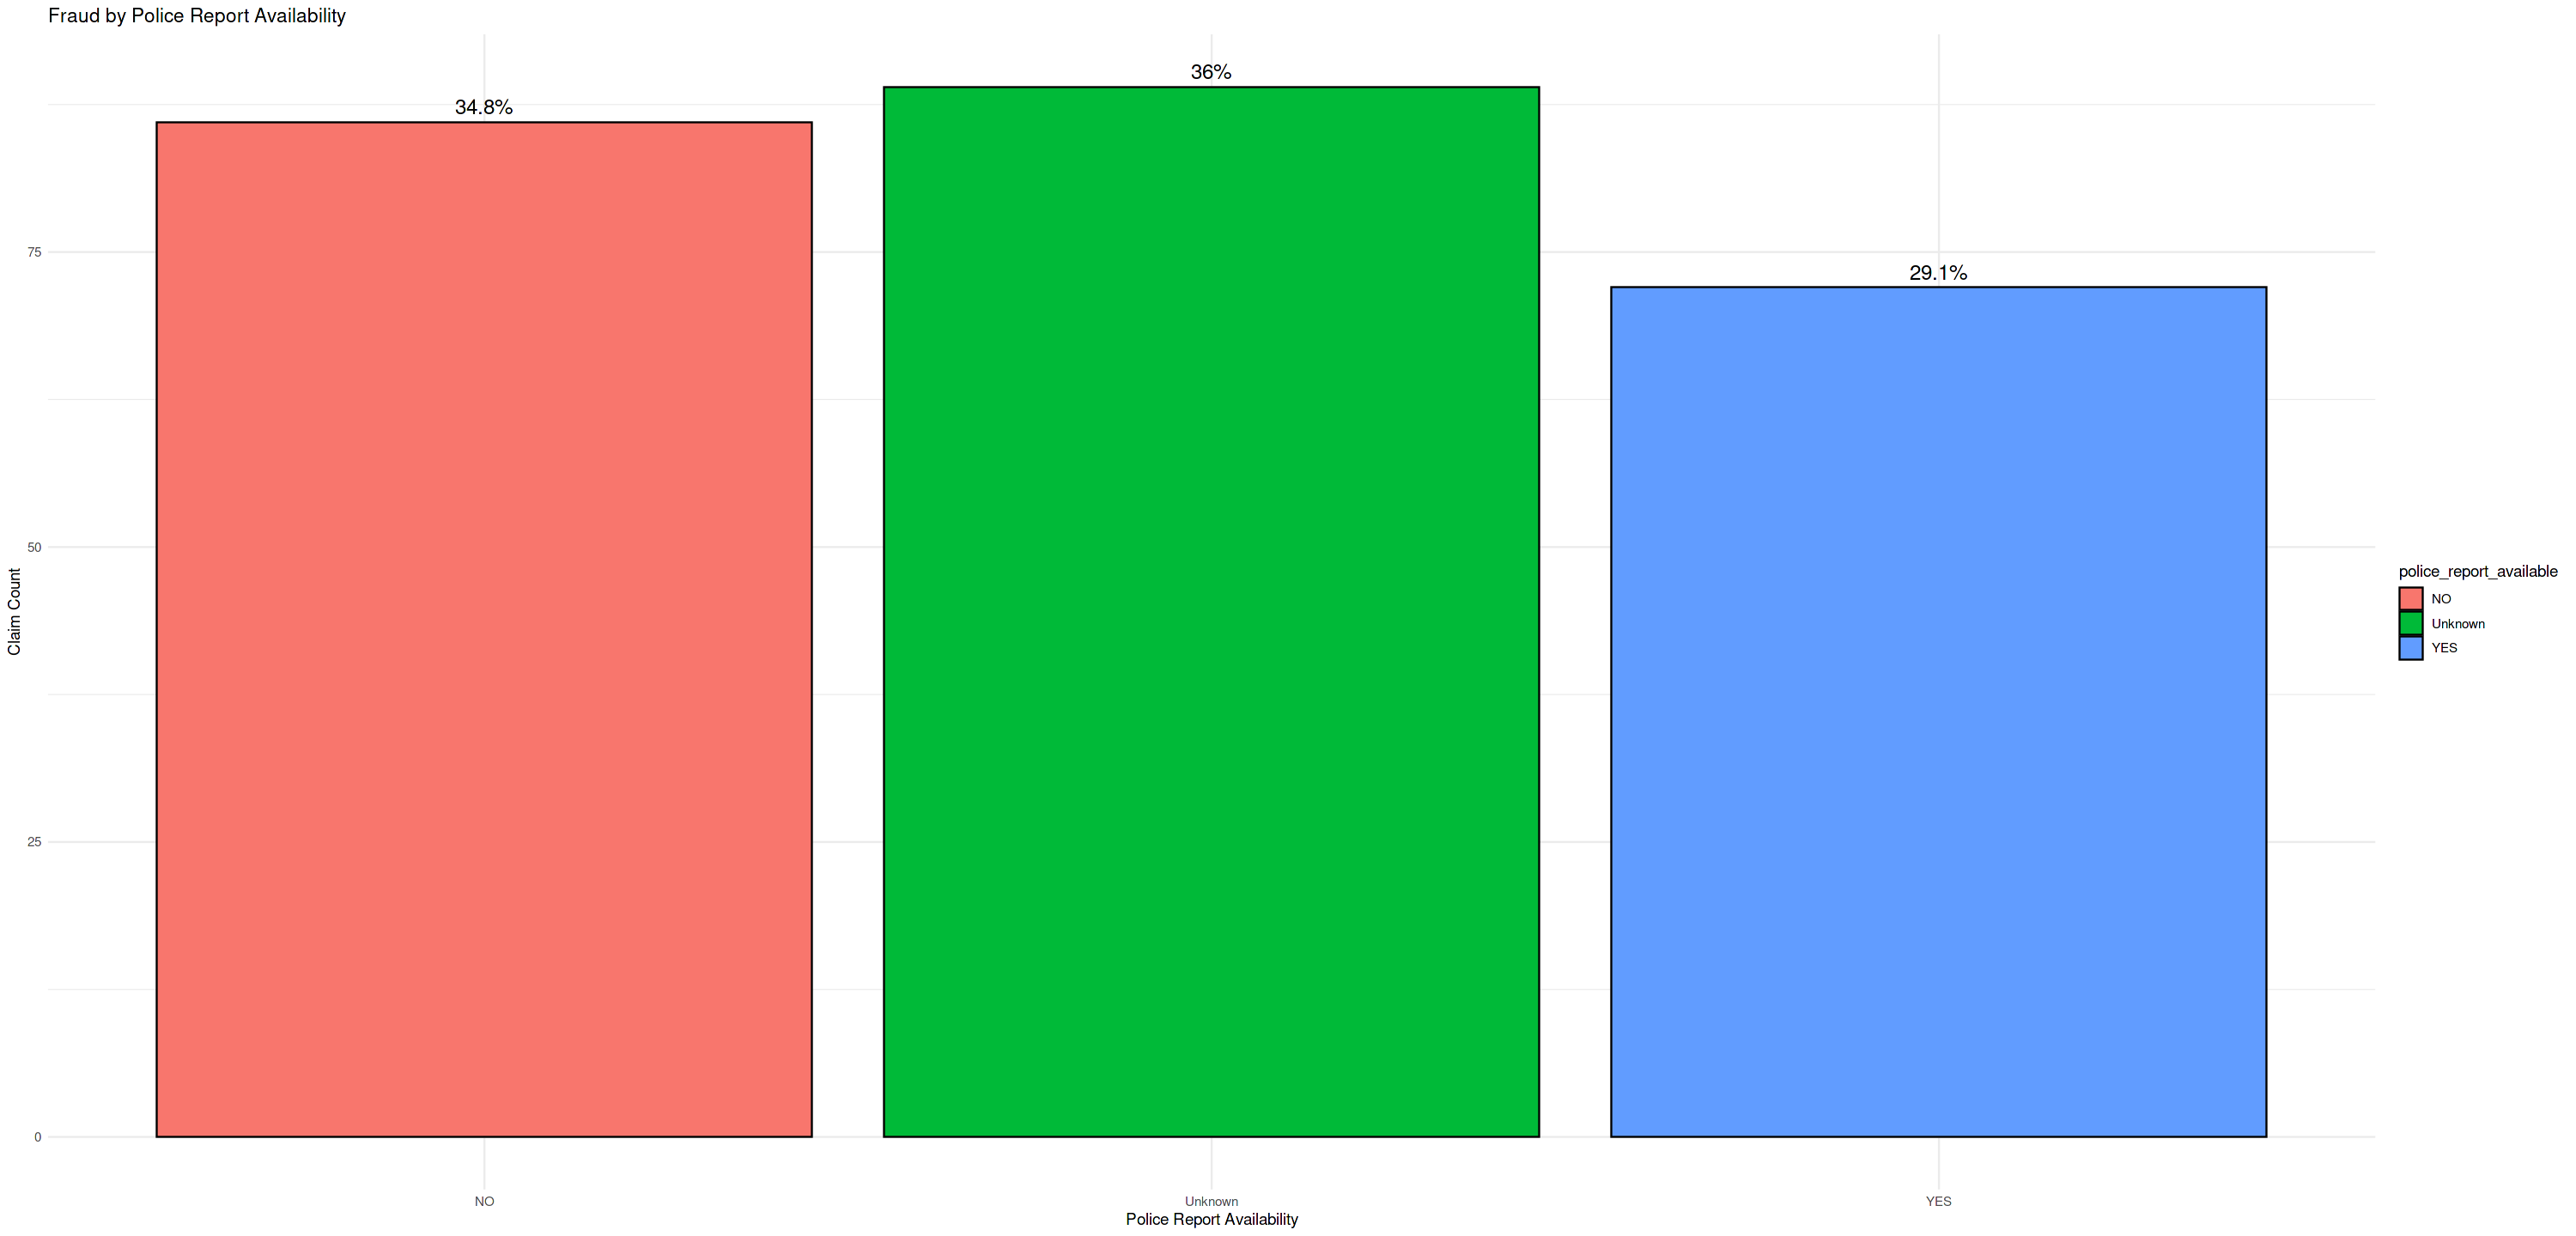

In [46]:
# Menyaring klaim penipuan berdasarkan ketersediaan laporan polisi dan membuat plot
ggplot(df4_fraud, aes(x = police_report_available, fill = police_report_available)) +
  geom_bar(position = "dodge", color = "black") +
  geom_text(aes(label = paste0(round(100 * (..count.. / sum(..count..)), 1), "%"), y = ..count..),
            stat = "count", position = position_dodge(width = 0.8), vjust = -0.5, size = 5) +
  labs(title = "Fraud by Police Report Availability", 
       x = "Police Report Availability", y = "Claim Count") +
  theme_minimal()

## 4.3 Multivariaty Analysis

### 4.3.1 Numerical Analysis

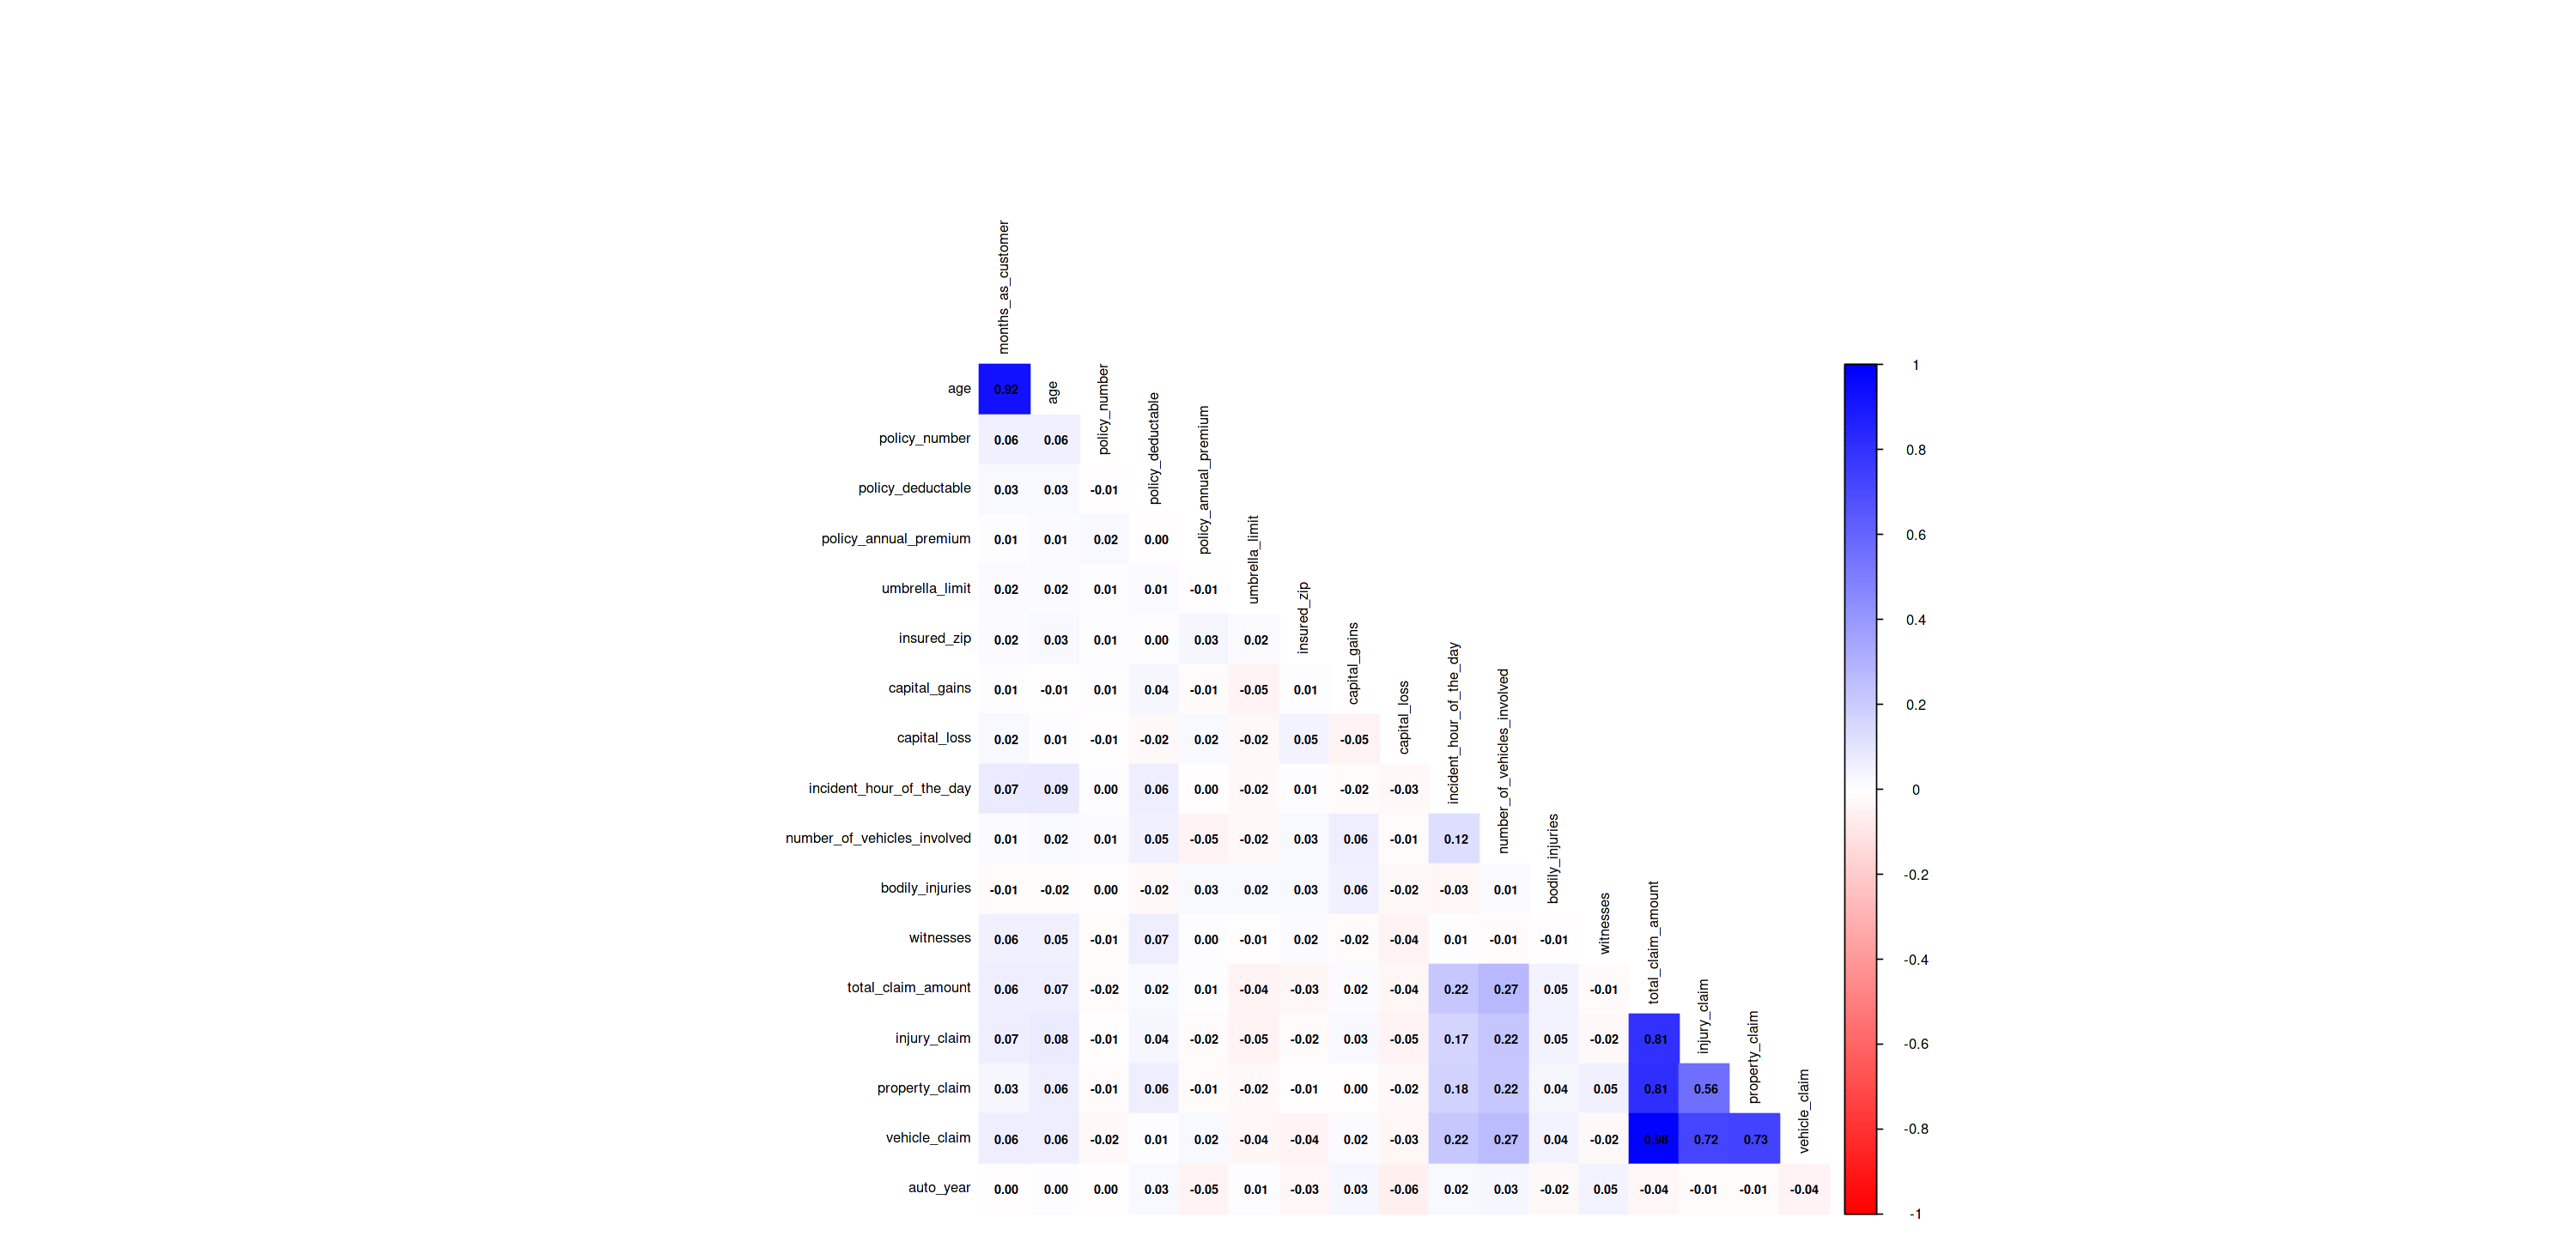

In [47]:
# Menghitung matriks korelasi untuk variabel numerik
corr_num <- cor(df4[, sapply(df4, is.numeric)], use = "complete.obs")

# Membuat plot korelasi dengan segitiga atas yang disembunyikan
corrplot::corrplot(corr_num, 
         method = "color", type = "lower", diag = FALSE, 
         tl.cex = 0.8,  tl.col = "black", number.cex = 0.7, 
         col = colorRampPalette(c("red", "white", "blue"))(200), 
         addCoef.col = "black", cl.lim = c(-1, 1), cl.cex = 0.8, cl.pos = "r")

### 4.3.2 Categorical Variables

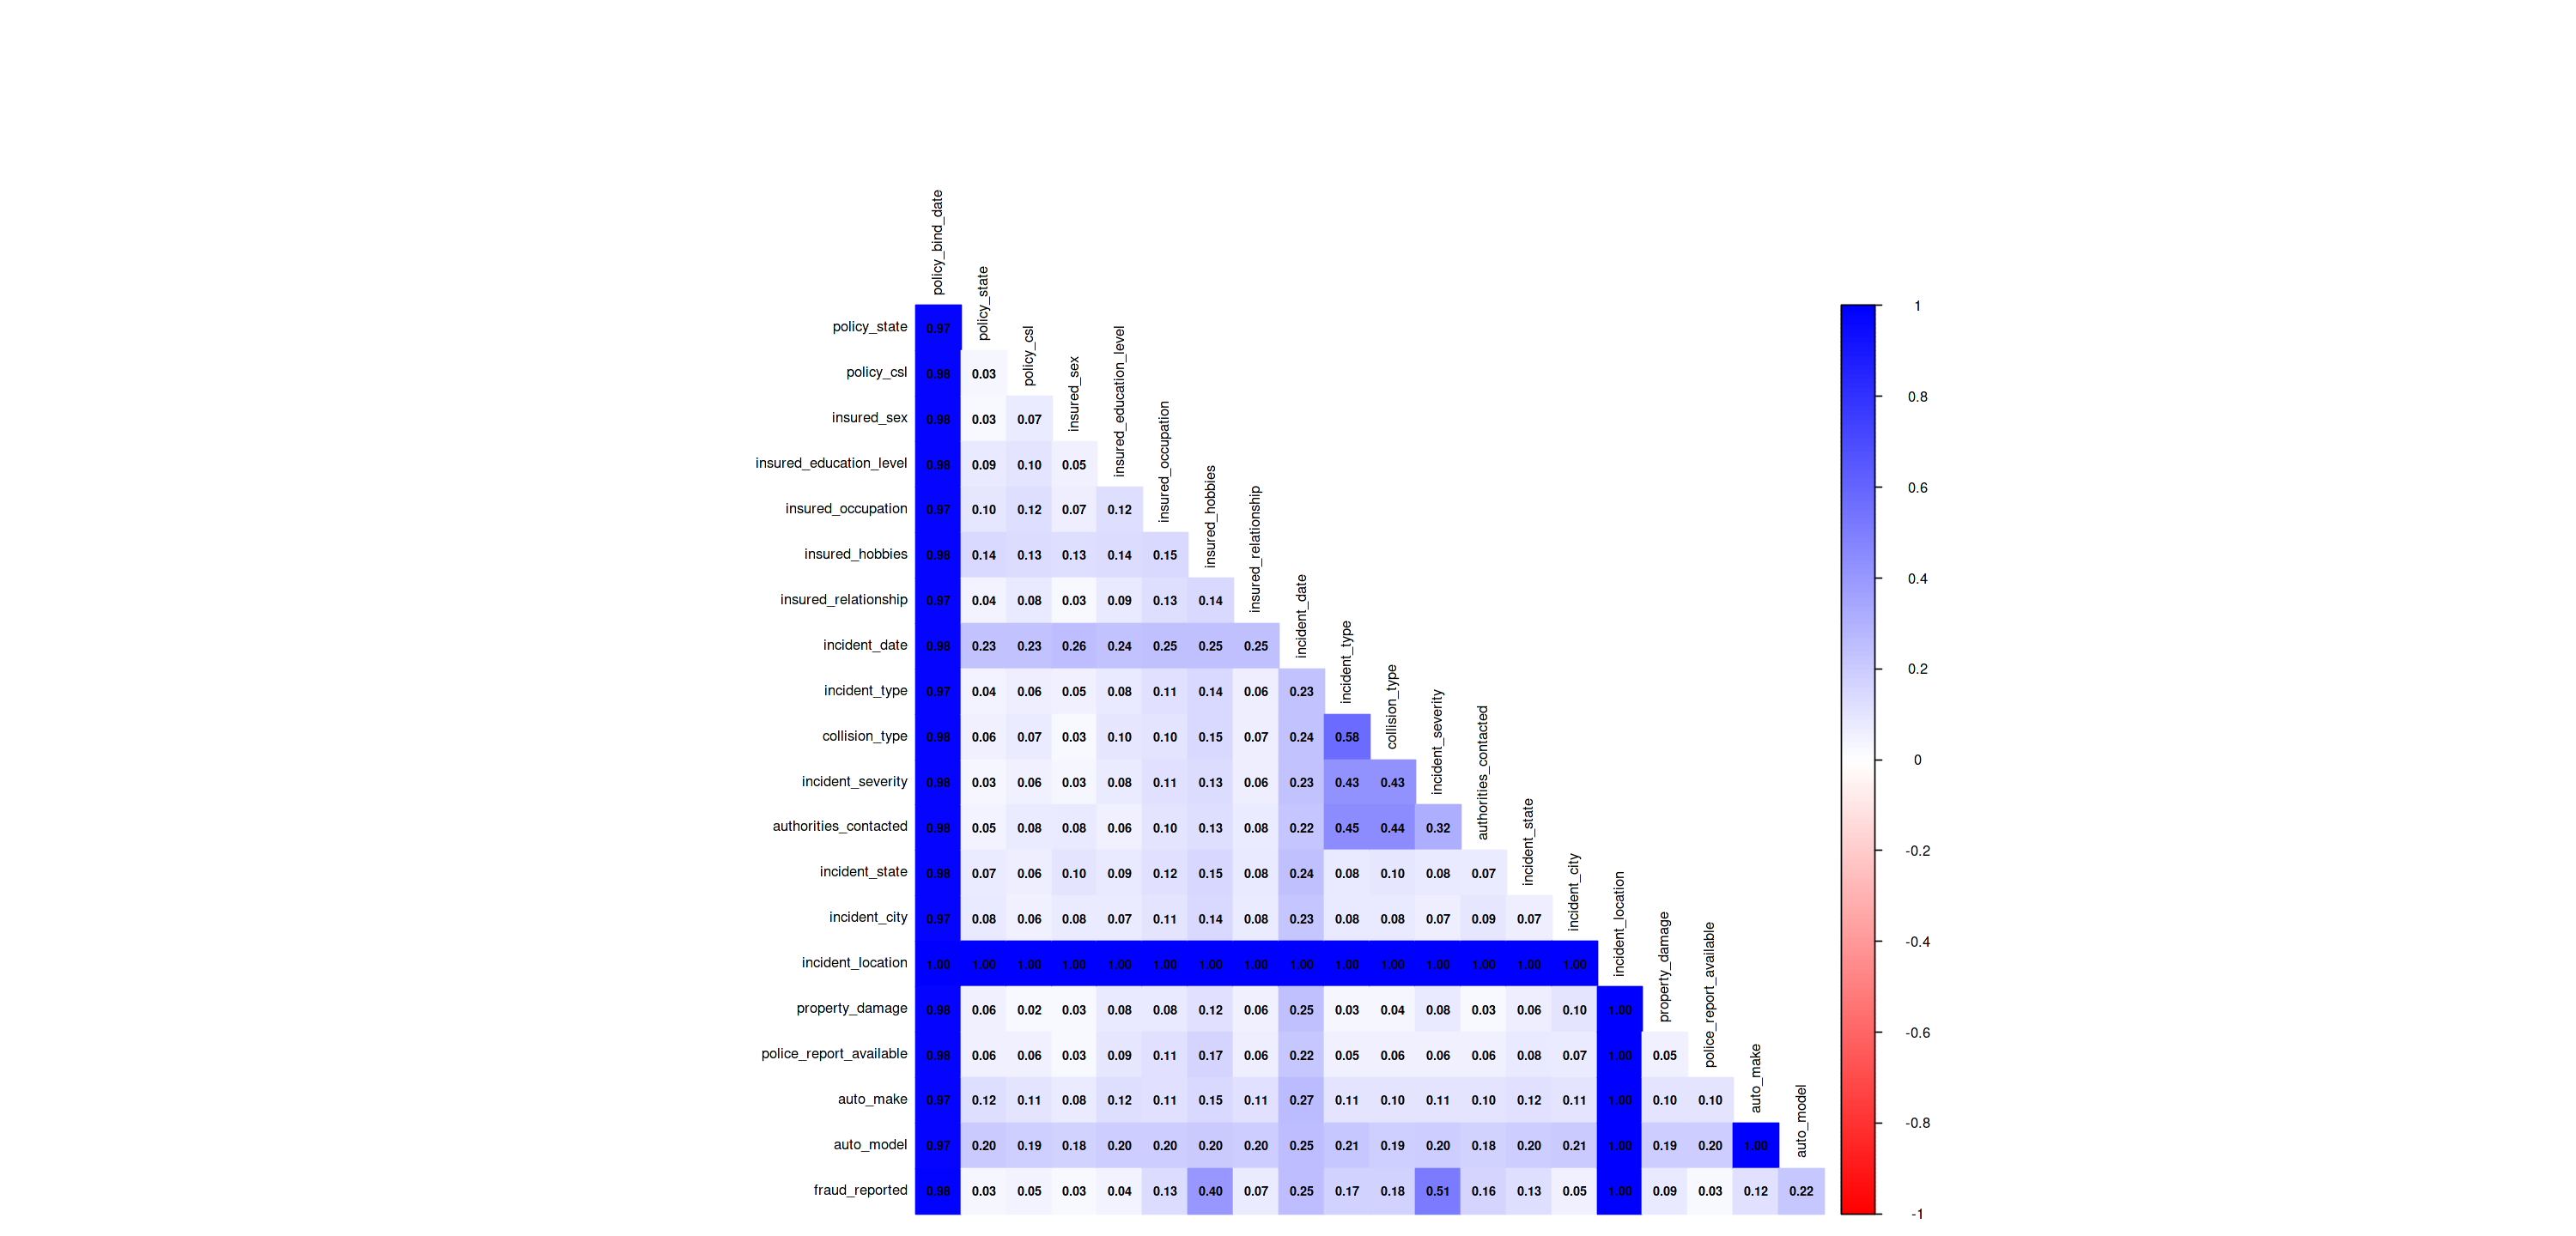

In [48]:
# Menghitung Cramér's V untuk variabel kategori
corr_cat <- cramers_v_matrix(df4)

# Memvisualisasikan matriks korelasi Cramér's V dengan heatmap
corrplot::corrplot(corr_cat, 
         method = "color", type = "lower", diag = FALSE, 
         tl.cex = 0.8, tl.col = "black", number.cex = 0.7, 
         col = colorRampPalette(c("red", "white", "blue"))(200), 
         addCoef.col = "black", cl.cex = 0.8, 
         cl.pos = "r")

# 5.0 Data Preparation

In [49]:
# Membuat salinan lain dari data frame 'df4' yang telah dimodifikasi
df5 <- df4

In [50]:
# Hapus kolom-kolom yang tidak diperlukan dari df5
X <- df5[, !(names(df5) %in% c(
  'policy_csl', 'policy_bind_date', 'policy_number', 'umbrella_limit', 
  'insured_zip', 'incident_date', 'insured_hobbies', 'insured_relationship', 
  'capital_gains', 'capital_loss', 'incident_state', 'incident_location', 
  'incident_hour_of_the_day', 'witnesses', 'injury_claim', 'property_claim', 
  'vehicle_claim', 'auto_make', 'auto_model', 'auto_year', 'fraud_reported'
))]

# Buat vektor target 'y', memetakan 'yes' menjadi 1 dan 'no' menjadi 0
y <- ifelse(df5$fraud_reported == 'yes', 1, 0)

In [51]:
# Atur seed untuk memastikan hasil yang dapat direproduksi
set.seed(123)
trainIndex <- createDataPartition(y, p = 0.8, list = FALSE, times = 1)

# Buat subset data untuk pelatihan dan pengujian
X_temp <- X[trainIndex, ]
X_test <- X[-trainIndex, ]
y_temp <- y[trainIndex]
y_test <- y[-trainIndex]

In [52]:
# Pisahkan data pelatihan menjadi set pelatihan (80%) dan set validasi (20%)
set.seed(123)
trainIndex <- createDataPartition(y_temp, p = 0.8, list = FALSE, times = 1)

# Buat subset untuk pelatihan dan validasi
X_train <- X_temp[trainIndex, ]
X_valid <- X_temp[-trainIndex, ]
y_train <- y_temp[trainIndex]
y_valid <- y_temp[-trainIndex]

## 5.2 One Hot Encoder

In [53]:
# Terapkan one-hot encoding pada kolom kategorikal di data pelatihan
categorical_columns <- c(
  'insured_sex', 'police_report_available', 'property_damage', 'policy_state', 
  'incident_type', 'collision_type', 'incident_severity', 'authorities_contacted', 
  'insured_education_level', 'insured_occupation', 'incident_city'
)

X_train <- fastDummies::dummy_cols(X_train, select_columns = categorical_columns, remove_selected_columns = TRUE)

# Terapkan one-hot encoding pada data validasi menggunakan kolom yang sama
X_valid <- fastDummies::dummy_cols(X_valid, select_columns = categorical_columns, 
  remove_selected_columns = TRUE, ignore_na = TRUE)

# Terapkan one-hot encoding pada data sementara (untuk pengujian atau keperluan lain)
X_temp  <- fastDummies::dummy_cols(X_temp, select_columns = categorical_columns, 
  remove_selected_columns = TRUE, ignore_na = TRUE)

# Terapkan one-hot encoding pada data uji
X_test  <- fastDummies::dummy_cols(X_test, select_columns = categorical_columns, 
  remove_selected_columns = TRUE, ignore_na = TRUE)

## 5.3 Rescaling 

In [54]:
# Tentukan kolom numerik yang akan diskalakan
num_columns <- c('months_as_customer', 'age', 'policy_annual_premium', 'total_claim_amount', 'policy_deductable')

# Salin data sementara untuk proses penskalaan
X_params <- X_temp

# Buat Min-Max scaler menggunakan data pelatihan
min_max_scaler <- preProcess(X_train[, num_columns], method = c("range"))

# Skalakan kolom numerik di data pelatihan
X_train[, num_columns]  <- predict(min_max_scaler, X_train[, num_columns])

# Skalakan kolom numerik di data validasi menggunakan scaler dari data pelatihan
X_valid[, num_columns]  <- predict(min_max_scaler, X_valid[, num_columns])

# Skalakan kolom numerik di data sementara
X_params[, num_columns] <- predict(preProcess(X_temp[, num_columns], method = c("range")), X_temp[, num_columns])

# Skalakan kolom numerik di data uji menggunakan scaler sementara
X_test[, num_columns]   <- predict(preProcess(X_temp[, num_columns], method = c("range")), X_test[, num_columns])

# 6.0 Feature Selection

## 6.1 Boruta

In [55]:
# Menggunakan data dari X_params dan y_temp
# X_boruta <- as.matrix(X_params)  # Mengubah X_params menjadi matriks
# y_boruta <- as.vector(y_temp)   # Mengubah y_temp menjadi vektor

In [56]:
# library(Boruta)

# Menjalankan algoritma Boruta
# set.seed(123)  # Untuk memastikan hasil yang reproducible
# boruta_result <- Boruta(X_boruta, y_boruta, doTrace = 2)

# Menampilkan hasil
# print(boruta_result)

# Memilih fitur penting
# final_boruta <- TentativeRoughFix(boruta_result)

# Menampilkan fitur yang dipilih
# important_features <- getSelectedAttributes(final_boruta, withTentative = FALSE)
# print(important_features)


### 6.1.1 Best Features

In [57]:
# Mendapatkan fitur yang dipilih oleh Boruta
# cols_selected_boruta <- getSelectedAttributes(final_boruta, withTentative = FALSE)

In [58]:
# Mendapatkan nama kolom yang dipilih berdasarkan hasil Boruta
# columns_selected <- colnames(X_params)[colnames(X_params) %in% cols_selected_boruta]

In [59]:
# columns_selected

In [60]:
# Daftar kolom dalam bentuk vektor karakter
# selected_columns <- c(
#  "step",
#  "amount",
#  "oldbalance_org",
#  "newbalance_orig",
#  "oldbalance_dest",
#  "newbalance_dest",
#  "diff_new_old_balance",
#  "diff_new_old_destiny",
#  "type_TRANSFER"
#)


In [61]:
#final_columns_selected <- c('months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'number_of_vehicles_involved', 'bodily_injuries', 'total_claim_amount', 'insured_sex_FEMALE', 'insured_sex_MALE', 'police_report_available_NO', 'police_report_available_Unknown', 'police_report_available_YES', 'property_damage_NO', 'property_damage_Unknown', 'property_damage_YES', 'policy_state_IL', 'policy_state_IN', 'policy_state_OH', 'incident_type_Multi-vehicle Collision', 'incident_type_Parked Car', 'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'collision_type_Front Collision', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'collision_type_Unknown', 'incident_severity_Major Damage', 'incident_severity_Minor Damage', 'incident_severity_Total Loss', 'incident_severity_Trivial Damage', 'authorities_contacted_Ambulance', 'authorities_contacted_Fire', 'authorities_contacted_None', 'authorities_contacted_Other', 'authorities_contacted_Police', 'insured_education_level_Associate', 'insured_education_level_College', 'insured_education_level_High School', 'insured_education_level_JD', 'insured_education_level_Masters', 'insured_education_level_MD', 'insured_education_level_PhD', 'insured_occupation_adm-clerical', 'insured_occupation_armed-forces', 'insured_occupation_craft-repair', 'insured_occupation_exec-managerial', 'insured_occupation_farming-fishing', 'insured_occupation_handlers-cleaners', 'insured_occupation_machine-op-inspct', 'insured_occupation_other-service', 'insured_occupation_priv-house-serv', 'insured_occupation_prof-specialty', 'insured_occupation_protective-serv', 'insured_occupation_sales', 'insured_occupation_tech-support', 'insured_occupation_transport-moving', 'incident_city_Arlington', 'incident_city_Columbus', 'incident_city_Hillsdale', 'incident_city_Northbend', 'incident_city_Northbrook', 'incident_city_Riverwood', 'incident_city_Springfield')

In [62]:
final_columns_selected <- c('months_as_customer', 'age', 'policy_deductable', 'policy_annual_premium', 'number_of_vehicles_involved', 'bodily_injuries', 'total_claim_amount', 'insured_sex_FEMALE', 'insured_sex_MALE', 'police_report_available_NO', 'police_report_available_Unknown', 'police_report_available_YES', 'property_damage_NO', 'property_damage_Unknown', 'property_damage_YES', 'policy_state_IL', 'policy_state_IN', 'policy_state_OH', 'incident_type_Multi-vehicle Collision', 'incident_type_Parked Car', 'incident_type_Single Vehicle Collision', 'incident_type_Vehicle Theft', 'collision_type_Front Collision', 'collision_type_Rear Collision', 'collision_type_Side Collision', 'collision_type_Unknown', 'incident_severity_Major Damage', 'incident_severity_Minor Damage', 'incident_severity_Total Loss', 'incident_severity_Trivial Damage', 'authorities_contacted_Ambulance', 'authorities_contacted_Fire', 'authorities_contacted_None', 'authorities_contacted_Other', 'authorities_contacted_Police', 'insured_education_level_Associate', 'insured_education_level_College', 'insured_education_level_High School', 'insured_education_level_JD', 'insured_education_level_Masters', 'insured_education_level_MD', 'insured_education_level_PhD', 'insured_occupation_adm-clerical', 'insured_occupation_armed-forces', 'insured_occupation_craft-repair', 'insured_occupation_exec-managerial', 'insured_occupation_farming-fishing', 'insured_occupation_handlers-cleaners', 'insured_occupation_machine-op-inspct', 'insured_occupation_other-service', 'insured_occupation_priv-house-serv', 'insured_occupation_prof-specialty', 'insured_occupation_protective-serv', 'insured_occupation_sales', 'insured_occupation_tech-support', 'insured_occupation_transport-moving', 'incident_city_Arlington', 'incident_city_Columbus', 'incident_city_Hillsdale', 'incident_city_Northbend', 'incident_city_Northbrook', 'incident_city_Riverwood', 'incident_city_Springfield')

# 7.0 Machine Learning Modeling

In [63]:
# Pilih kolom yang dipilih dari data frame
X_train_cs  <- X_train[, final_columns_selected]
X_valid_cs  <- X_valid[, final_columns_selected]
X_temp_cs   <- X_temp[, final_columns_selected]
X_test_cs   <- X_test[, final_columns_selected]
X_params_cs <- X_params[, final_columns_selected]

## 7.1 Baseline 

In [64]:
smote_data <- SMOTE(X_train_cs, y_train, K = 5)  

# Pisahkan kembali hasil SMOTE menjadi fitur dan target
X_train_res <- smote_data$data[, -ncol(smote_data$data)]  # Memisahkan data fitur
y_train_res <- smote_data$data[, ncol(smote_data$data)]   # Memisahkan label

# Latih model DummyClassifier (menggunakan model yang sudah dilatih sebelumnya)
dummy_model <- train(
  x         = X_train_res,
  y         = y_train_res,
  method    = "rf", # Sama seperti sebelumnya, menggunakan RandomForest
  trControl = trainControl(method = "cv", number = 5),
  tuneGrid  = data.frame(mtry = 1)
)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model DummyClassifier
y_pred_dummy <- predict(dummy_model, newdata = X_valid_cs)
#y_pred_dummy <- ifelse(y_pred_dummy > 0.5, 1, 0)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_dummy <- predict(dummy_model, newdata = X_valid_cs, type = "prob")[,2]


In [65]:
# Panggil fungsi ml_scores untuk mengevaluasi model dummy
dummy_results <- ml_scores(model_name = "Dummy", x = y_valid, y = y_pred_dummy, z=y_pred_prob_dummy, ml="Imbalanced_Classification")
print(dummy_results)

      Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa MCC
Dummy              0.5     0.225      1               0.367  0.422     0 NaN


### 7.1.1 Classification Report

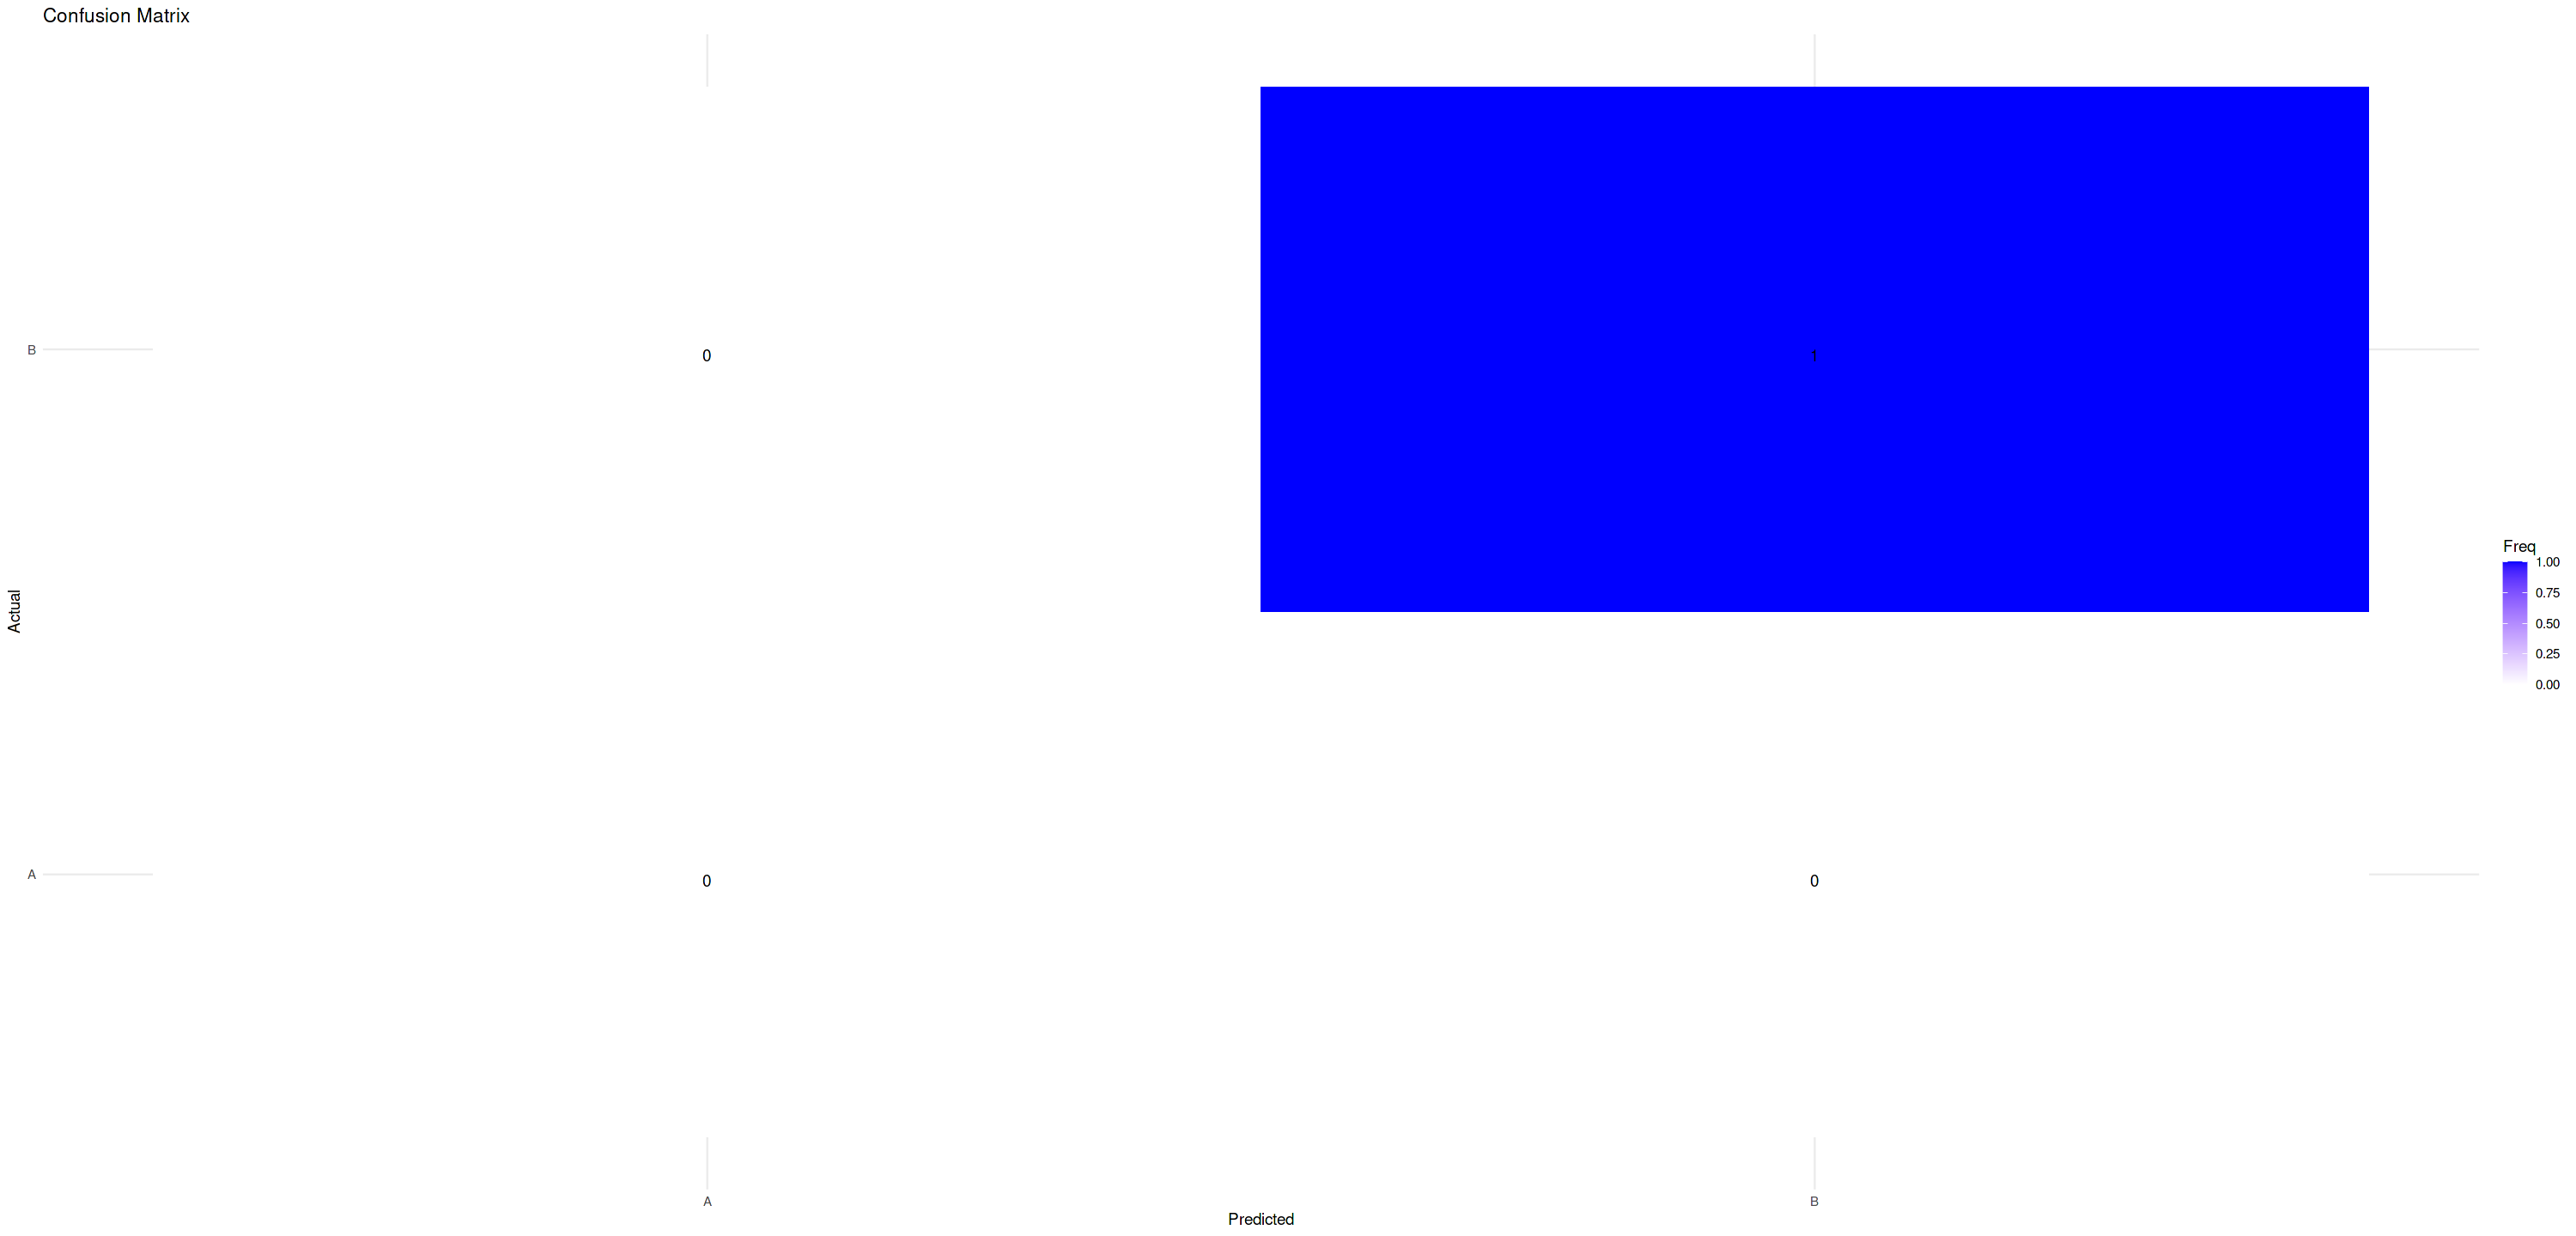

In [66]:
# Buat confusion matriks
plot_ml(x=y_valid, y=y_pred_dummy, z=y_pred_prob_dummy, ml="Imbalanced_Classification", type_plot="ConfusionMatrix")

### 7.1.2 Precision-Recall Curve

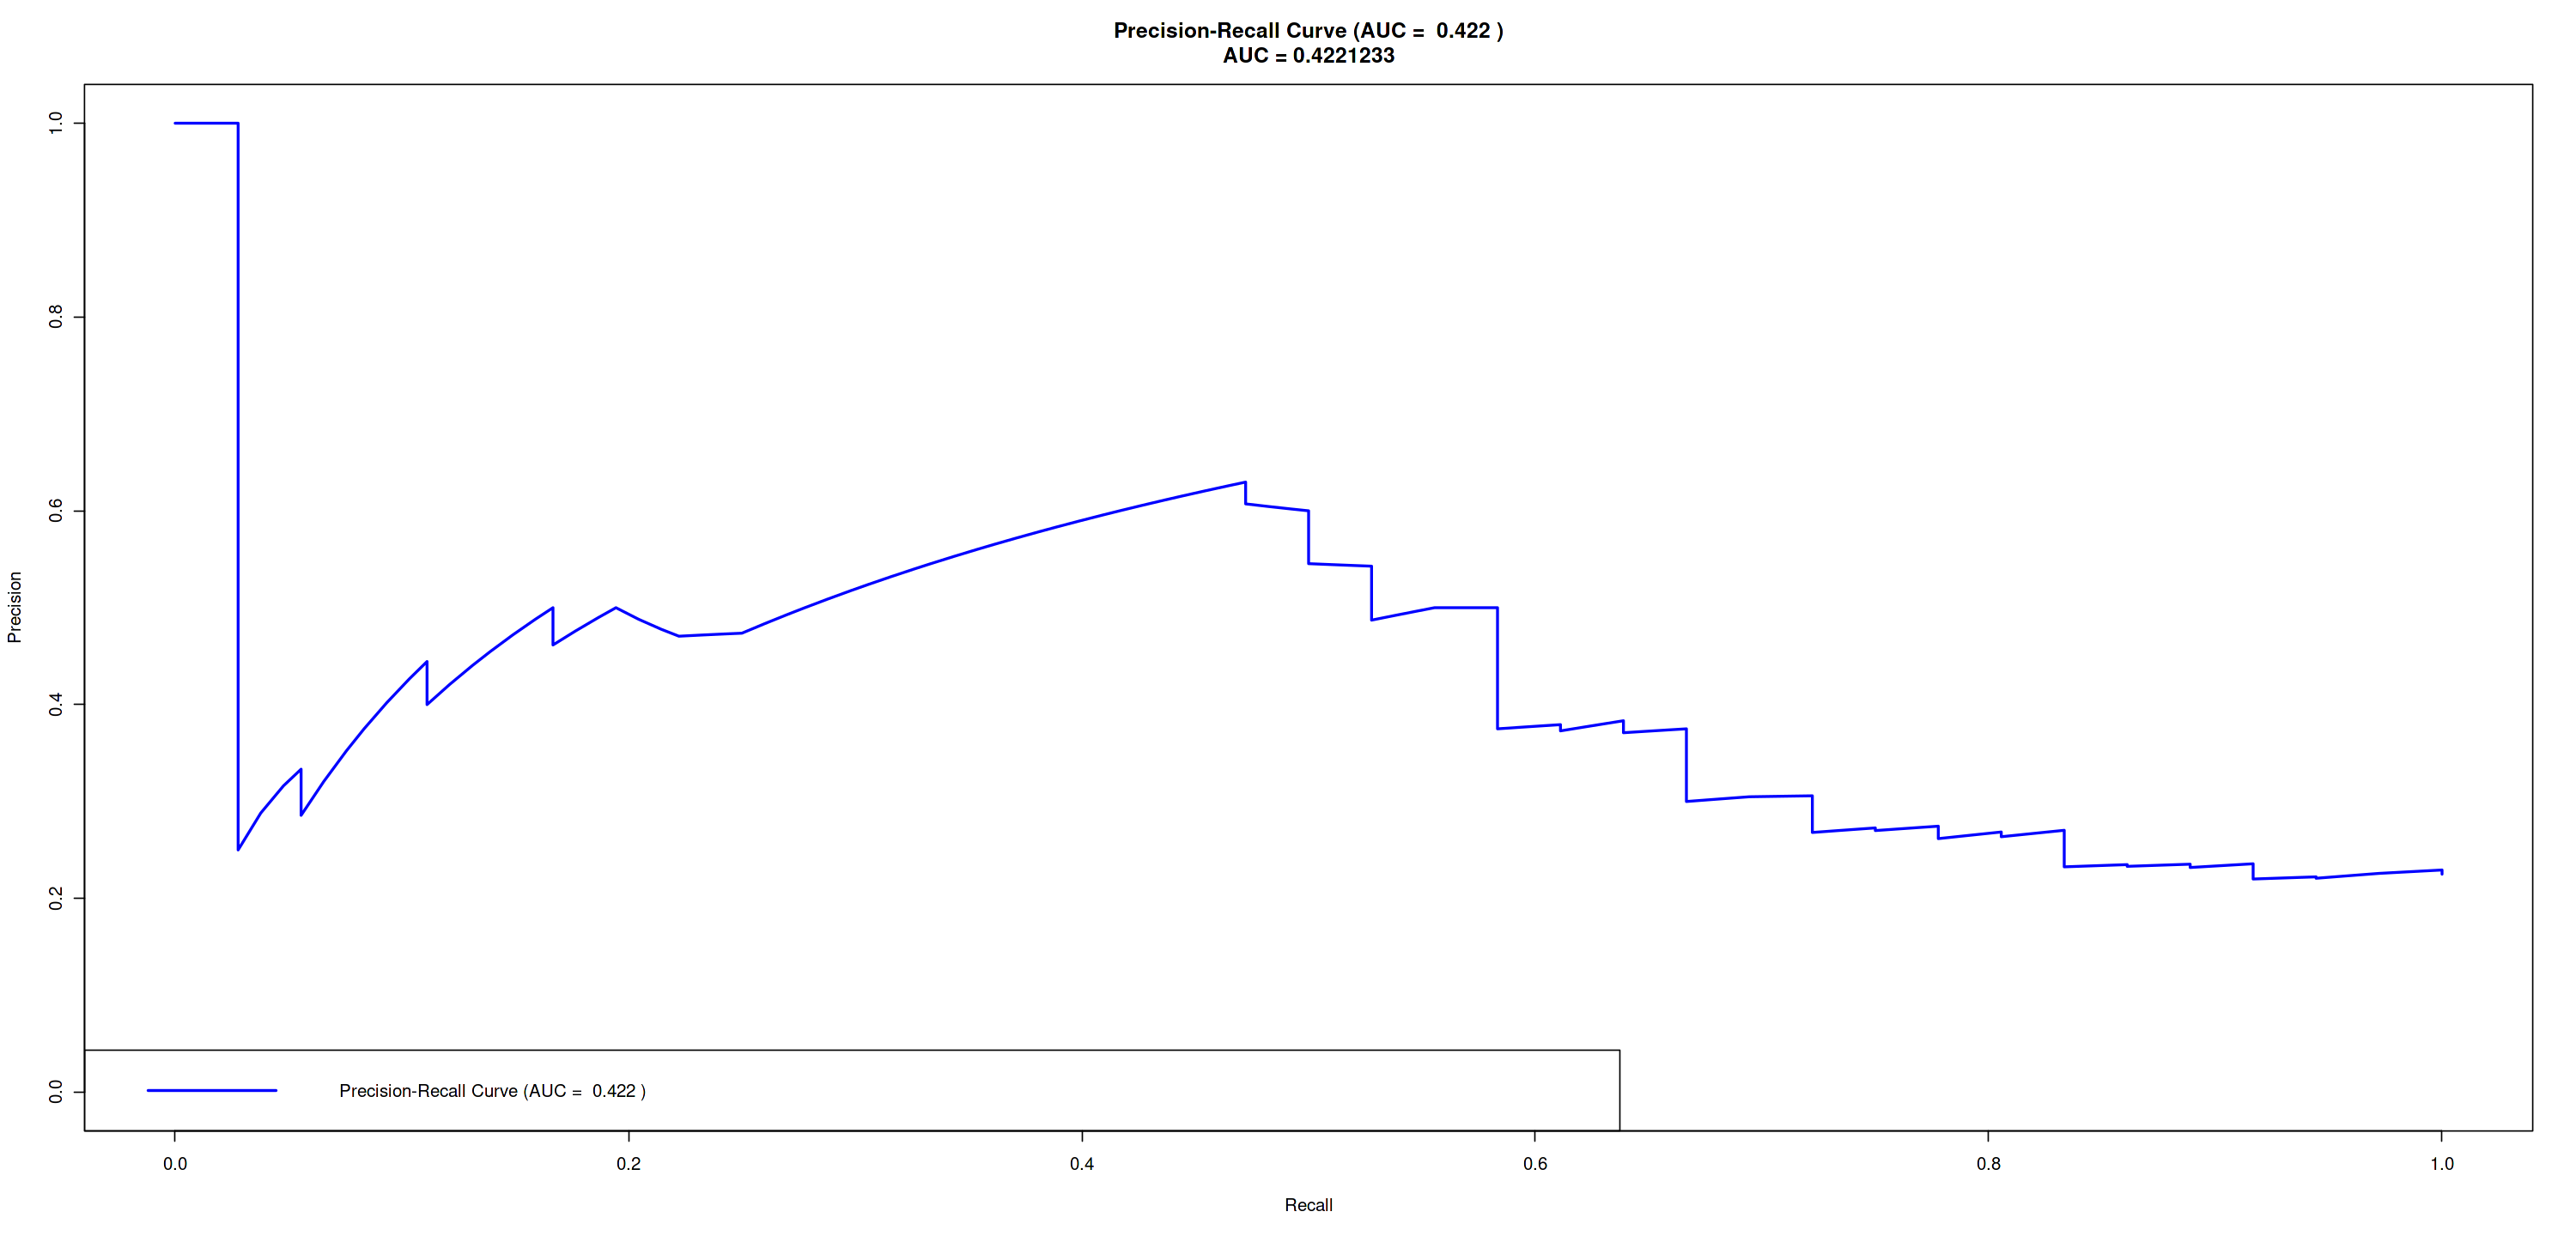

In [67]:
# Buat precision-recall curve
plot_ml(x=y_valid, y=y_pred_dummy, z=y_pred_prob_dummy, ml="Imbalanced_Classification", type_plot="Precision-Recall")

### 7.1.3 Cross Validation

In [68]:
# Lakukan cross-validation dengan model dummy
dummy_cv <- ml_cv_results(model_name="Dummy", model="dummy", ml="Imbalanced_Classification", x=X_temp_cs, y=y_temp)
print(dummy_cv)

Fold K= 1 
Fold K= 2 
Fold K= 3 
Fold K= 4 
Fold K= 5 
      Balanced.Accuracy       Precision  Recall   F1.Minorities          AUC.PR   Kappa        MCC
Dummy   0.514 +/- 0.034 0.246 +/- 0.067 1 +/- 0 0.392 +/- 0.081 0.474 +/- 0.122 0 +/- 0 NaN +/- NA


## 7.2 Logistic Regression

In [69]:
# Latih model Logistic Regression menggunakan data pelatihan
# (Assuming 'X_train_cs' is a data frame with features and 'y_train' is the target vector)
lg_model <- glm(y_train ~ ., data = X_train_cs, family = binomial)

# Prediksi kelas untuk data validasi (X_valid_cs) menggunakan model Logistic Regression
y_pred_lg <- predict(lg_model, newdata = X_valid_cs, type = "response")
y_pred_lg <- ifelse(y_pred_lg > 0.5, 1, 0)  # Prediksi kelas berdasarkan probabilitas (> 0.5 sebagai threshold)

# Prediksi probabilitas kelas positif (kelas '1') untuk data validasi (X_valid_cs)
y_pred_prob_lg <- predict(lg_model, newdata = X_valid_cs, type = "response")

In [70]:
# Panggil fungsi ml_scores untuk mengevaluasi model logistic regression
lg_results <- ml_scores(model_name = "Logistic Regression", x = y_valid, y = y_pred_lg, z=y_pred_prob_lg, ml="Imbalanced_Classification")
print(lg_results)

                    Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa   MCC
Logistic Regression            0.626     0.545  0.333               0.414  0.448 0.293 0.306


### 7.2.1 Classification Report 

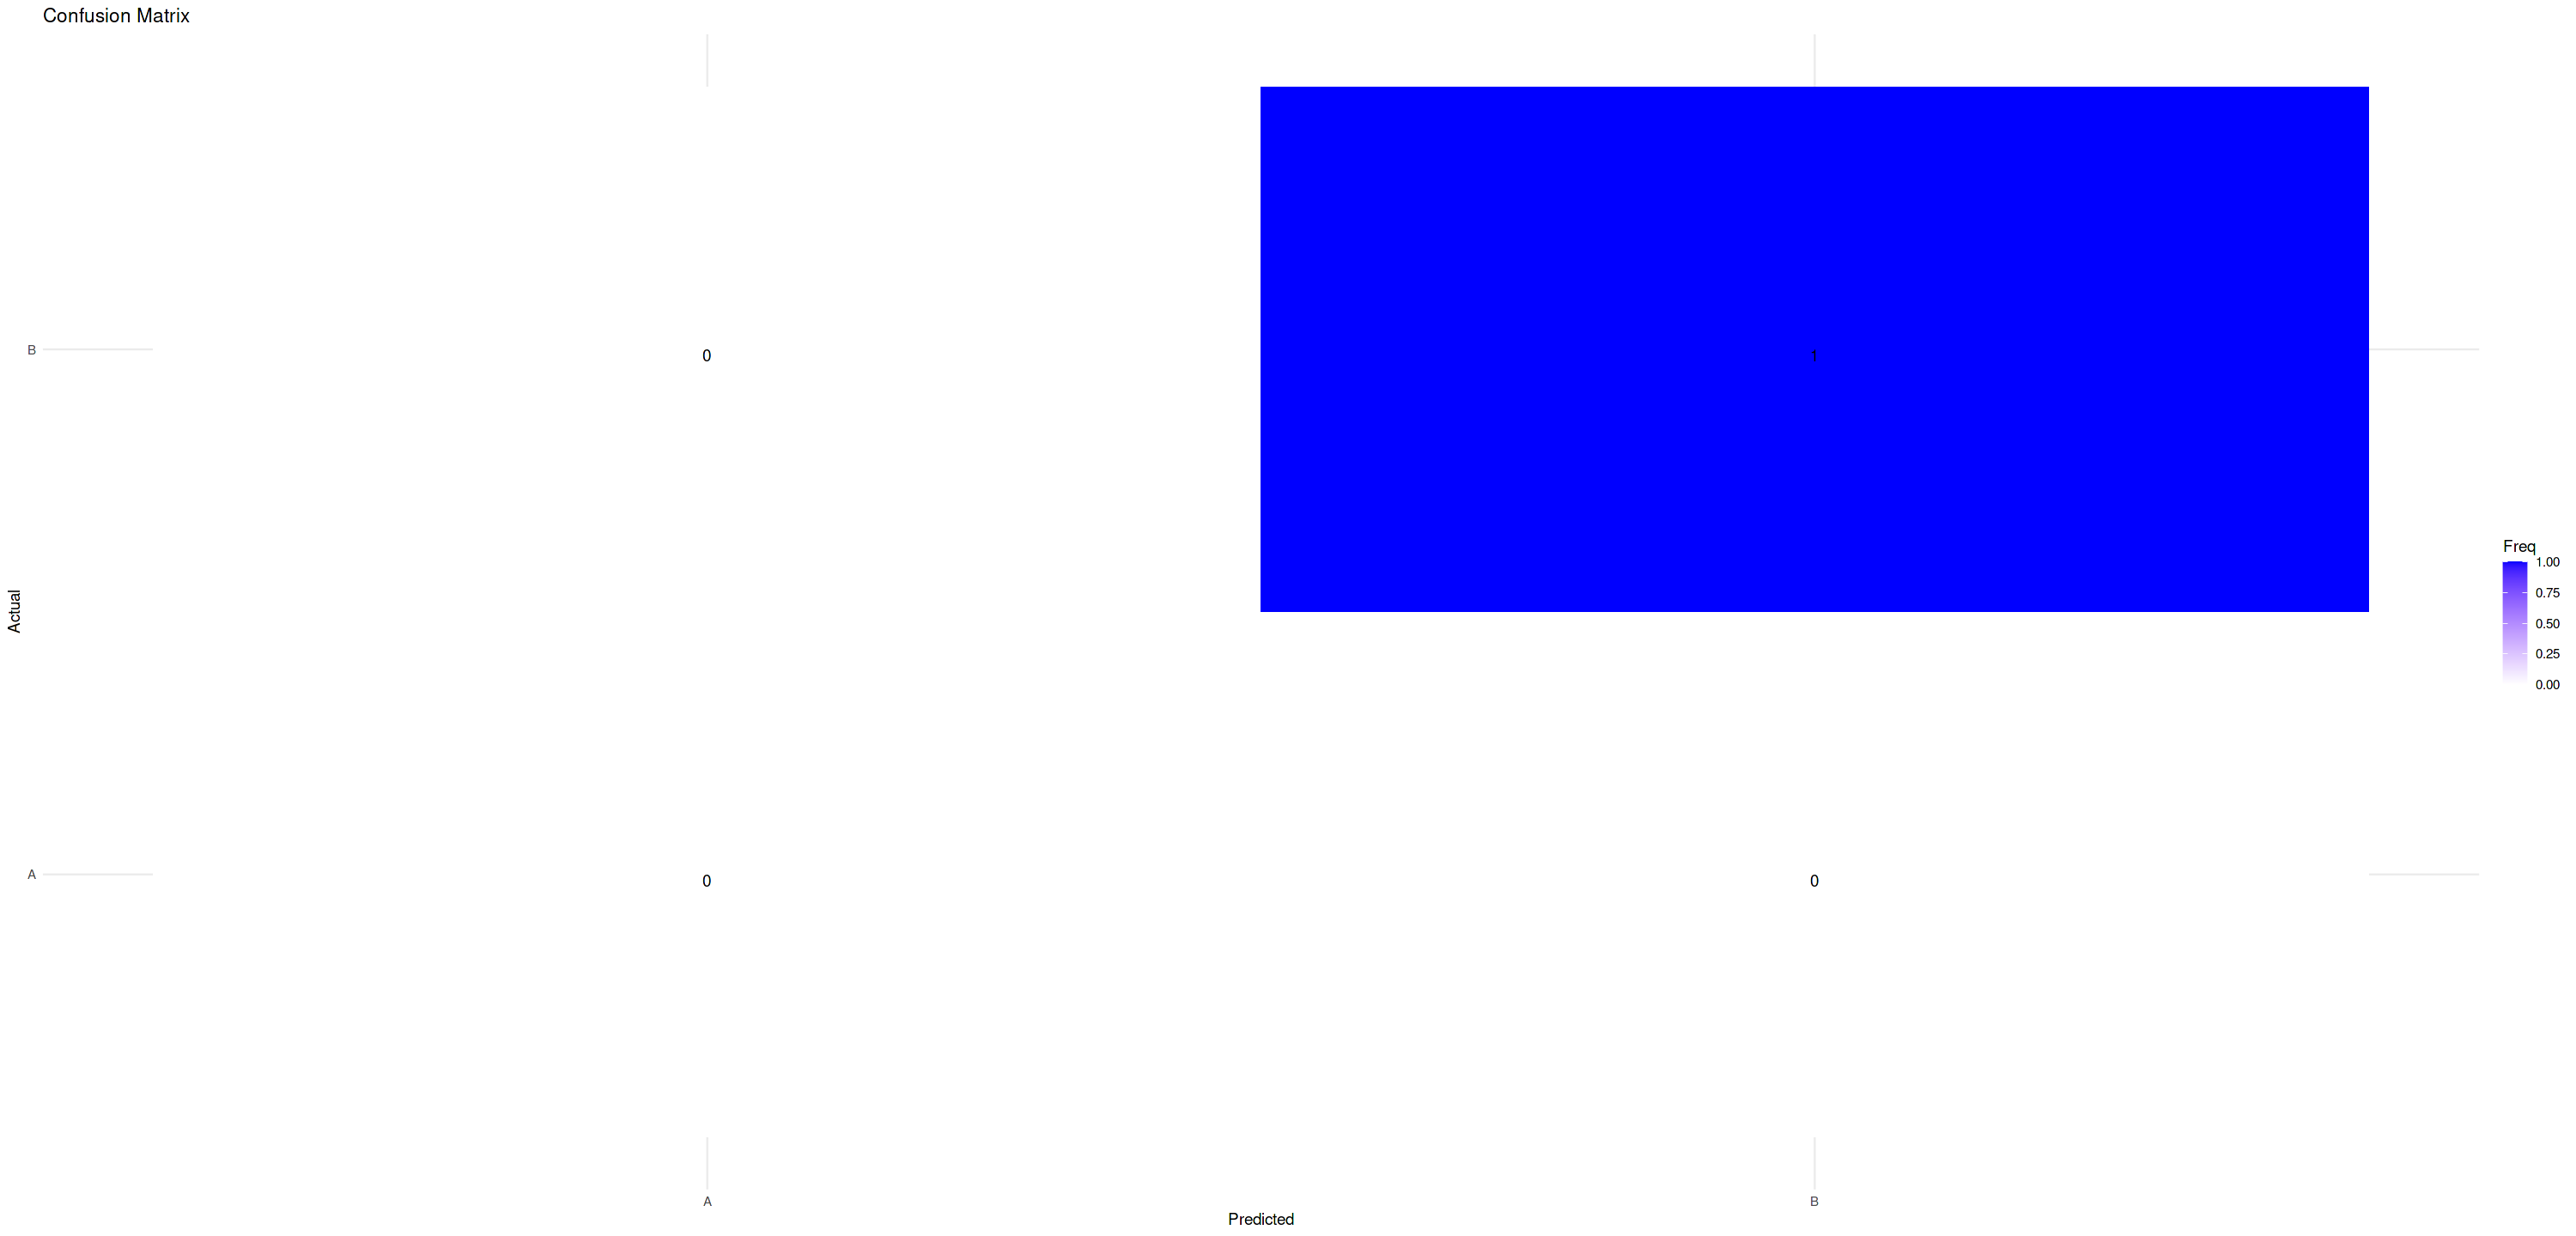

In [71]:
# Buat confusion matriks
plot_ml(x=y_valid, y=y_pred_lg, z=y_pred_prob_lg, ml="Imbalanced_Classification", type_plot="ConfusionMatrix")

### 7.2.2 Precision-Recall Curve

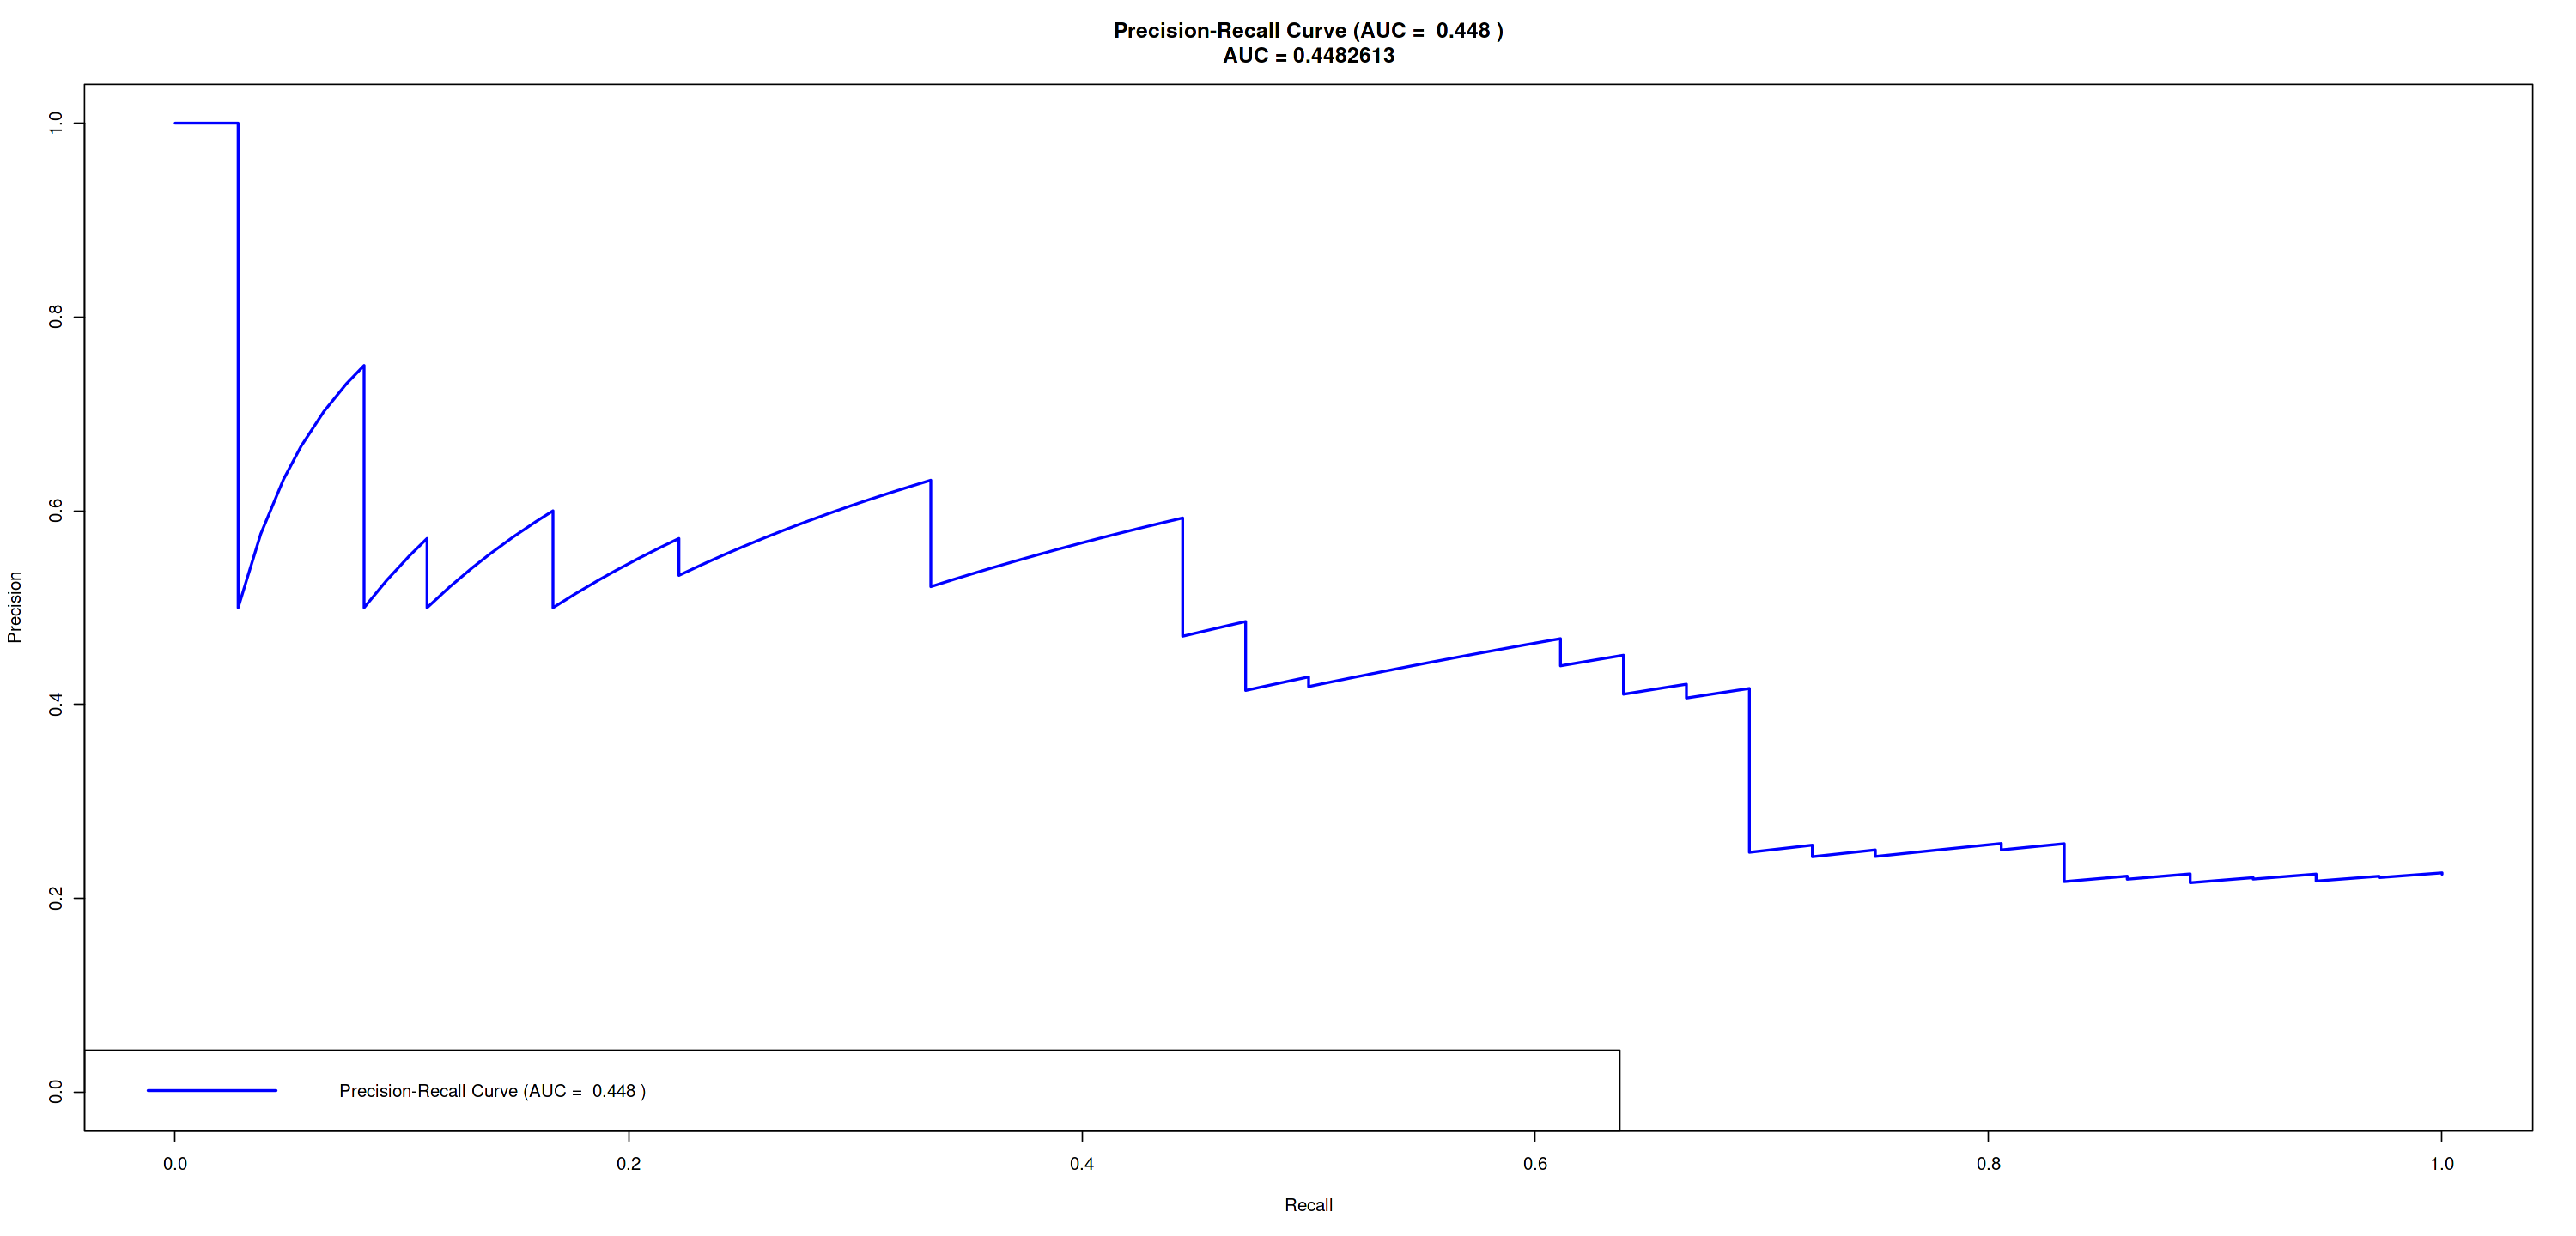

In [72]:
# Buat precision-recall curve
plot_ml(x=y_valid, y=y_pred_lg, z=y_pred_prob_lg, ml="Imbalanced_Classification", type_plot="Precision-Recall")

### 7.2.3 Cross Validation

In [73]:
# Lakukan cross-validation dengan model logistic regression
lg_cv <- ml_cv_results(model_name="Logistic Regression", model="lg", ml="Imbalanced_Classification", x=X_temp_cs, y=y_temp)
print(lg_cv)

Fold K= 1 
Fold K= 2 
Fold K= 3 
Fold K= 4 
Fold K= 5 
                    Balanced.Accuracy       Precision          Recall  F1.Minorities          AUC.PR           Kappa             MCC
Logistic Regression   0.701 +/- 0.026 0.612 +/- 0.101 0.508 +/- 0.064 0.549 +/- 0.04 0.516 +/- 0.081 0.421 +/- 0.046 0.429 +/- 0.048


## 7.3 K Nearest Neighbors

In [74]:
# Menggunakan metode SMOTE untuk melakukan oversampling pada data yang tidak seimbang
smote_data <- smotefamily::SMOTE(X_train_cs, y_train, K = 5) 

# Pisahkan kembali hasil SMOTE menjadi fitur dan target
x_res <- smote_data$data[, -ncol(smote_data$data)]  # Memisahkan data fitur (semua kolom kecuali kolom terakhir)
y_res <- smote_data$data[, ncol(smote_data$data)]   # Memisahkan label (kolom terakhir)

# Latih model K Nearest Neighbor
knn_model <- class::knn(
    train = x_res,
    test  = X_valid_cs,
    cl    = y_res,
    l     = 0,
    k     = 5,
    prob  = TRUE
)

# Prediksi kelas menggunakan model K Nearest Neighbor
y_pred_knn <- as.numeric(knn_model) - 1
      
# Prediksi probabilitas kelas positif untuk data uji
y_pred_prob_knn <- attr(knn_model, "prob")

In [75]:
# Panggil fungsi ml_scores untuk mengevaluasi model K Nearest Neighbor
knn_results <- ml_scores(model_name = "K Nearest Neighbors", x=y_valid, y=y_pred_knn, z=y_pred_prob_knn, ml= "Imbalanced_Classification")
print(knn_results)

                    Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa  MCC
K Nearest Neighbors             0.64     0.349  0.611               0.444  0.253 0.222 0.24


### 7.3.1 Classification Report

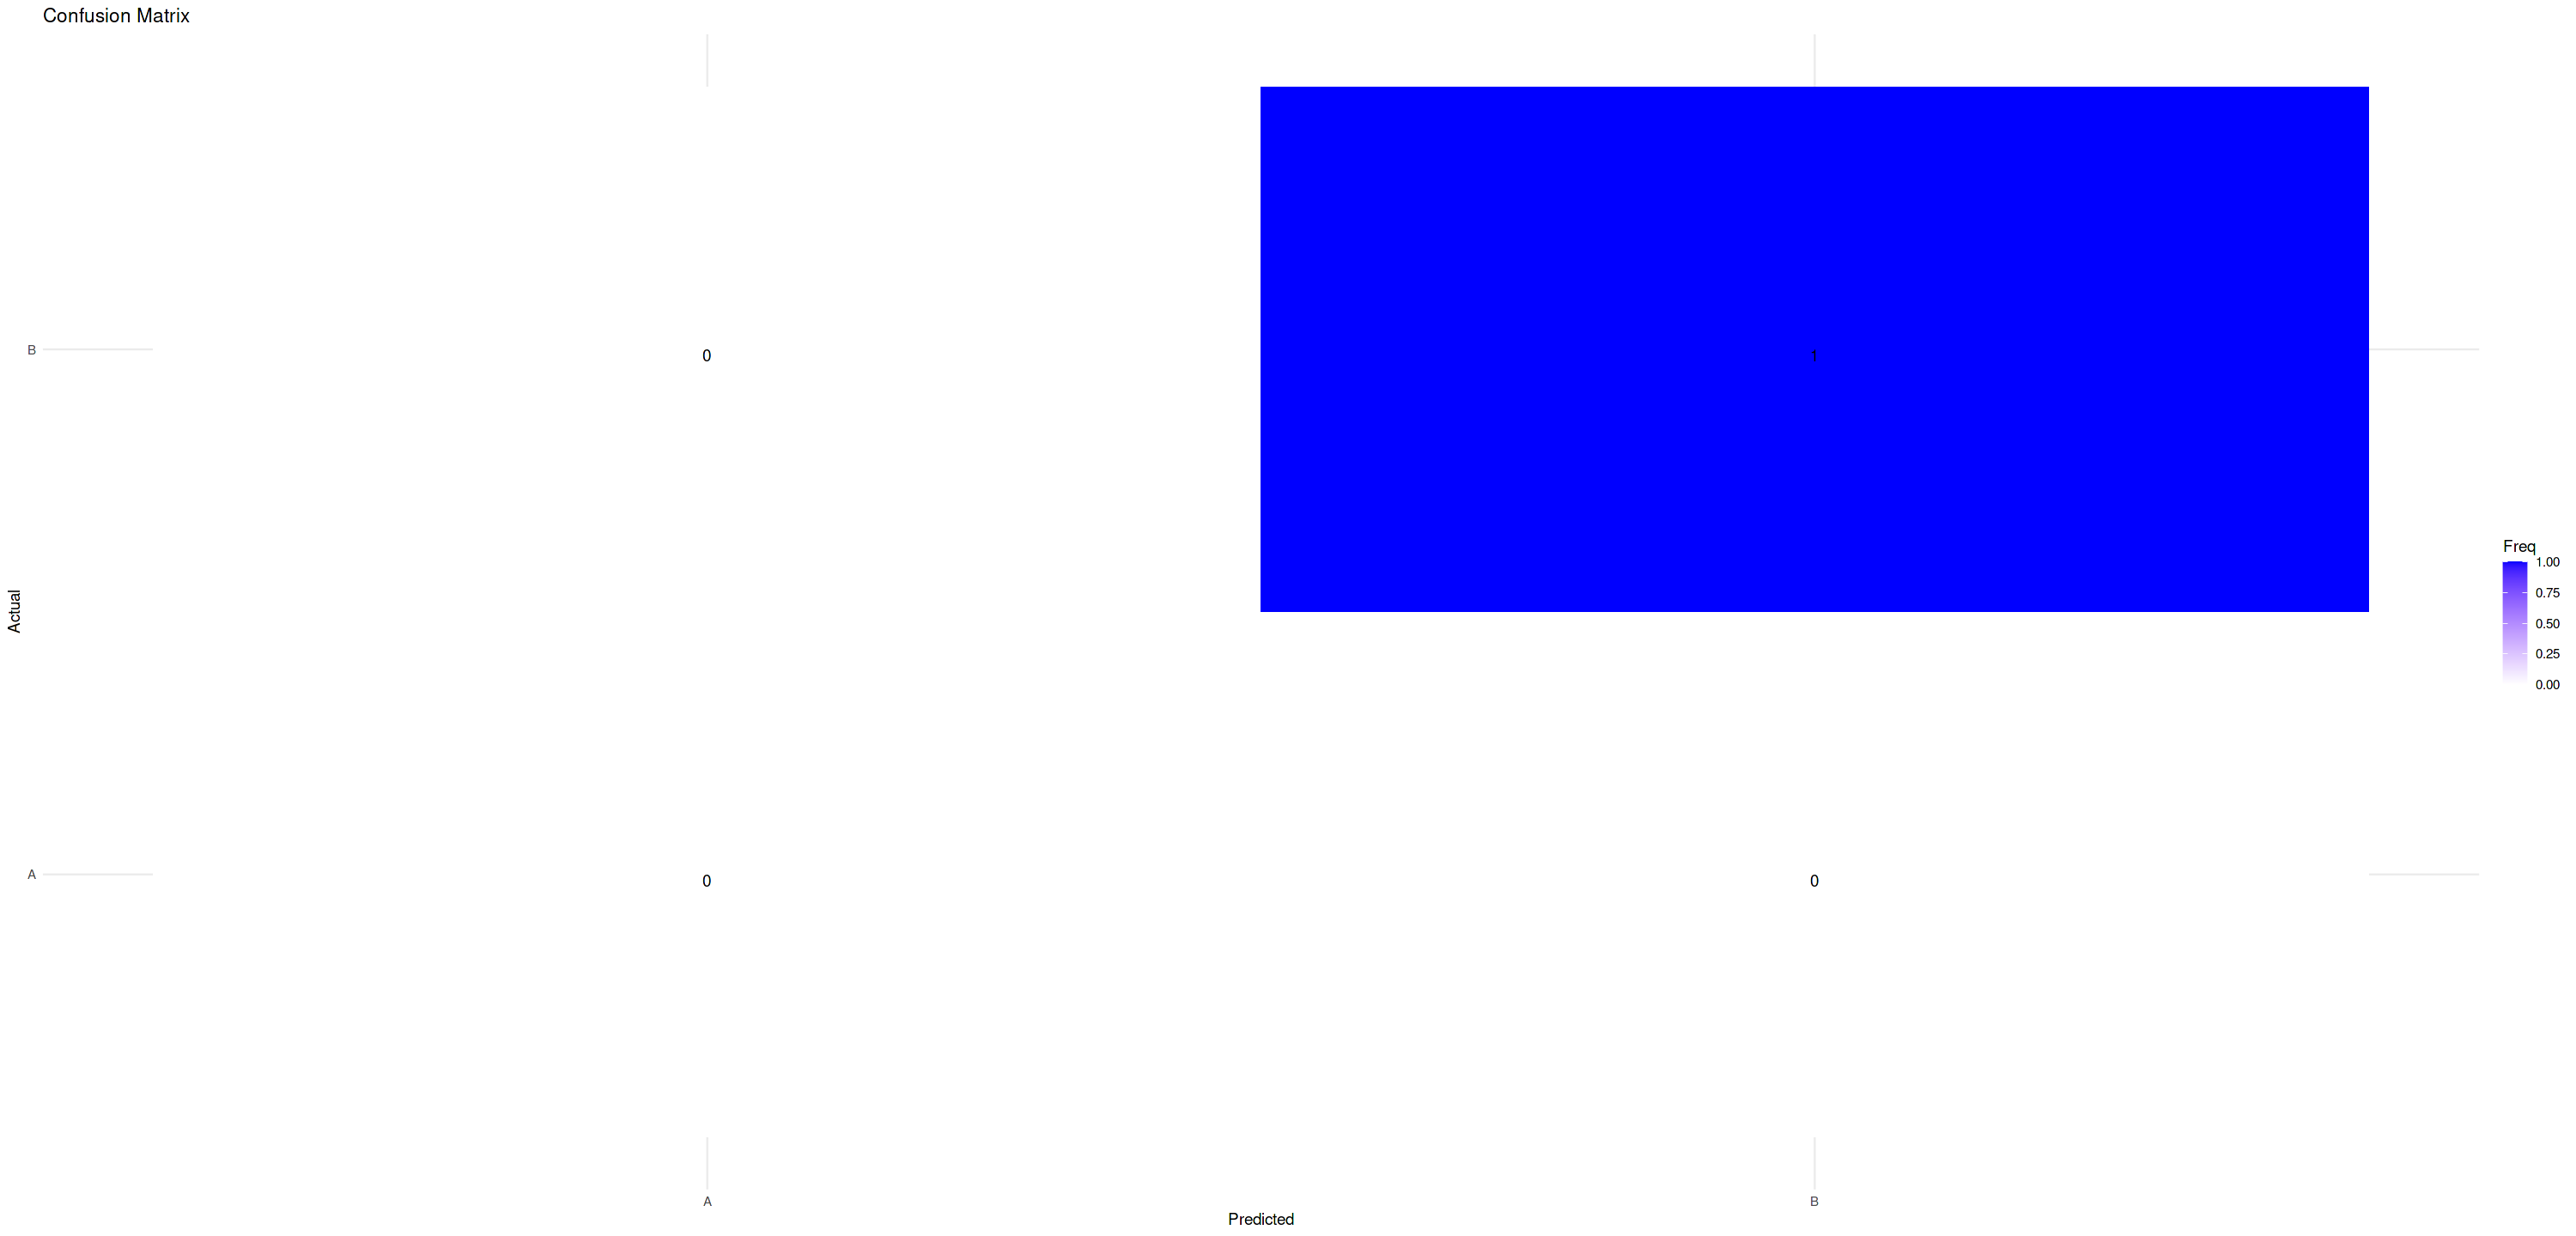

In [76]:
# Buat confusion matriks
plot_ml(x=y_valid, y=y_pred_knn, z=y_pred_prob_knn, ml="Imbalanced_Classification", type_plot="ConfusionMatrix")

### 7.3.2 Precision-Recall Curve

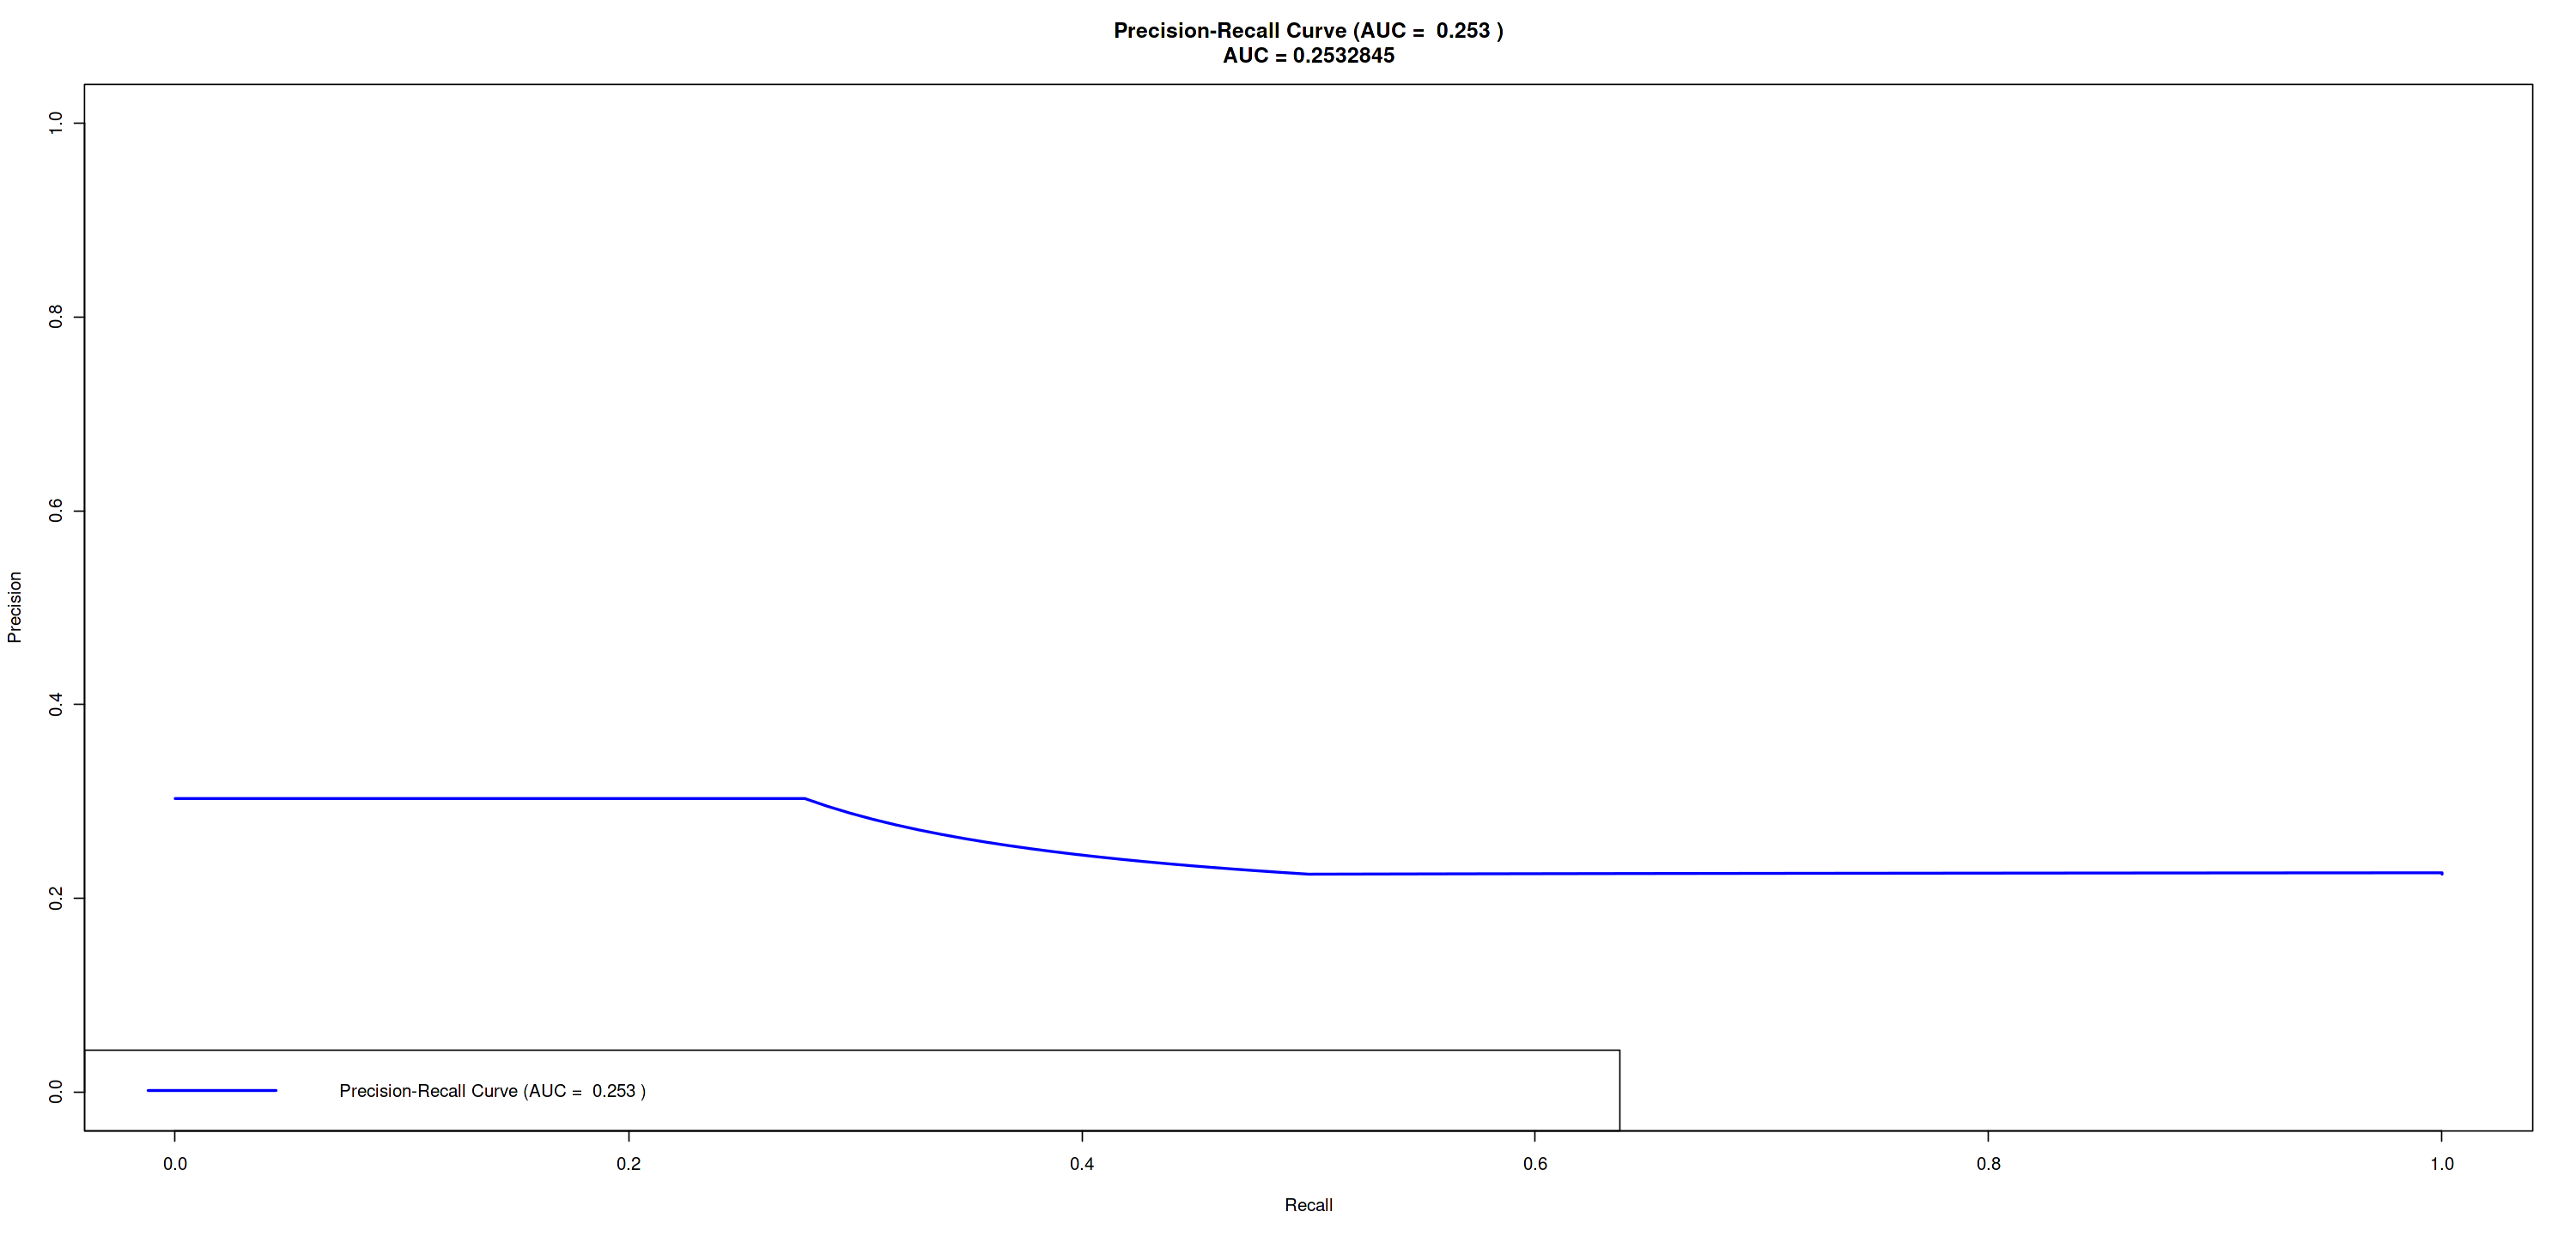

In [77]:
# Buat precision-recall curve
plot_ml(x=y_valid, y=y_pred_knn, z=y_pred_prob_knn, ml="Imbalanced_Classification", type_plot="Precision-Recall")

### 7.3.3 Cross Validation

In [78]:
# Lakukan cross-validation dengan model K Nearest Neighbors 
knn_cv <- ml_cv_results(model_name="K Nearest Neighbors", model="knn", ml="Imbalanced_Classification", x=X_temp_cs, y=y_temp)
print(knn_cv)

Fold K= 1 
Fold K= 2 
Fold K= 3 
Fold K= 4 
Fold K= 5 
                    Balanced.Accuracy       Precision          Recall   F1.Minorities        AUC.PR           Kappa            MCC
K Nearest Neighbors   0.622 +/- 0.043 0.327 +/- 0.025 0.757 +/- 0.067 0.455 +/- 0.028 0.3 +/- 0.047 0.169 +/- 0.059 0.212 +/- 0.07


## 7.4 Support Vector Machine

In [79]:
# Inisialisasi Support Vector Machine (SVM) dengan penyesuaian bobot kelas (balanced) dan probabilitas
svm_model <- e1071::svm(
    x             = X_train_cs,  # Data fitur untuk pelatihan
    y             = as.factor(y_train),  # Pastikan y_train diubah menjadi faktor untuk klasifikasi
    type          = "C-classification",  # Menentukan jenis model untuk klasifikasi
    kernel        = "radial",  # Menggunakan kernel Radial Basis Function (RBF)
    class.weights = list('1' = 1, '0' = 1),  # Menyesuaikan bobot kelas untuk penyeimbangan kelas
    probability   = TRUE  # Mengaktifkan perhitungan probabilitas untuk prediksi
    )

# Prediksi kelas menggunakan model Support Vector Machine
y_pred_svm <- predict(svm_model, newdata = X_valid_cs, decision.values = TRUE, probability = FALSE, na.action = na.omit)
y_pred_svm <- as.numeric(y_pred_svm)-1
      
# Prediksi probabilitas kelas positif untuk data uji
y_pred_prob_svm <- predict(svm_model, newdata = X_valid_cs, decision.values = TRUE, probability = TRUE, na.action = na.omit)
y_pred_prob_svm <- attr(y_pred_prob_svm, "probabilities")[, 2]

In [80]:
# Panggil fungsi ml_scores untuk mengevaluasi model support vector machine
svm_results <- ml_scores(model_name = "SVM", x=y_valid, y=y_pred_svm, z = y_pred_prob_svm ,ml= "Imbalanced_Classification")
print(svm_results) 

    Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa   MCC
SVM            0.692     0.607  0.472               0.531  0.178 0.416 0.421


### 7.4.1 Classification Report

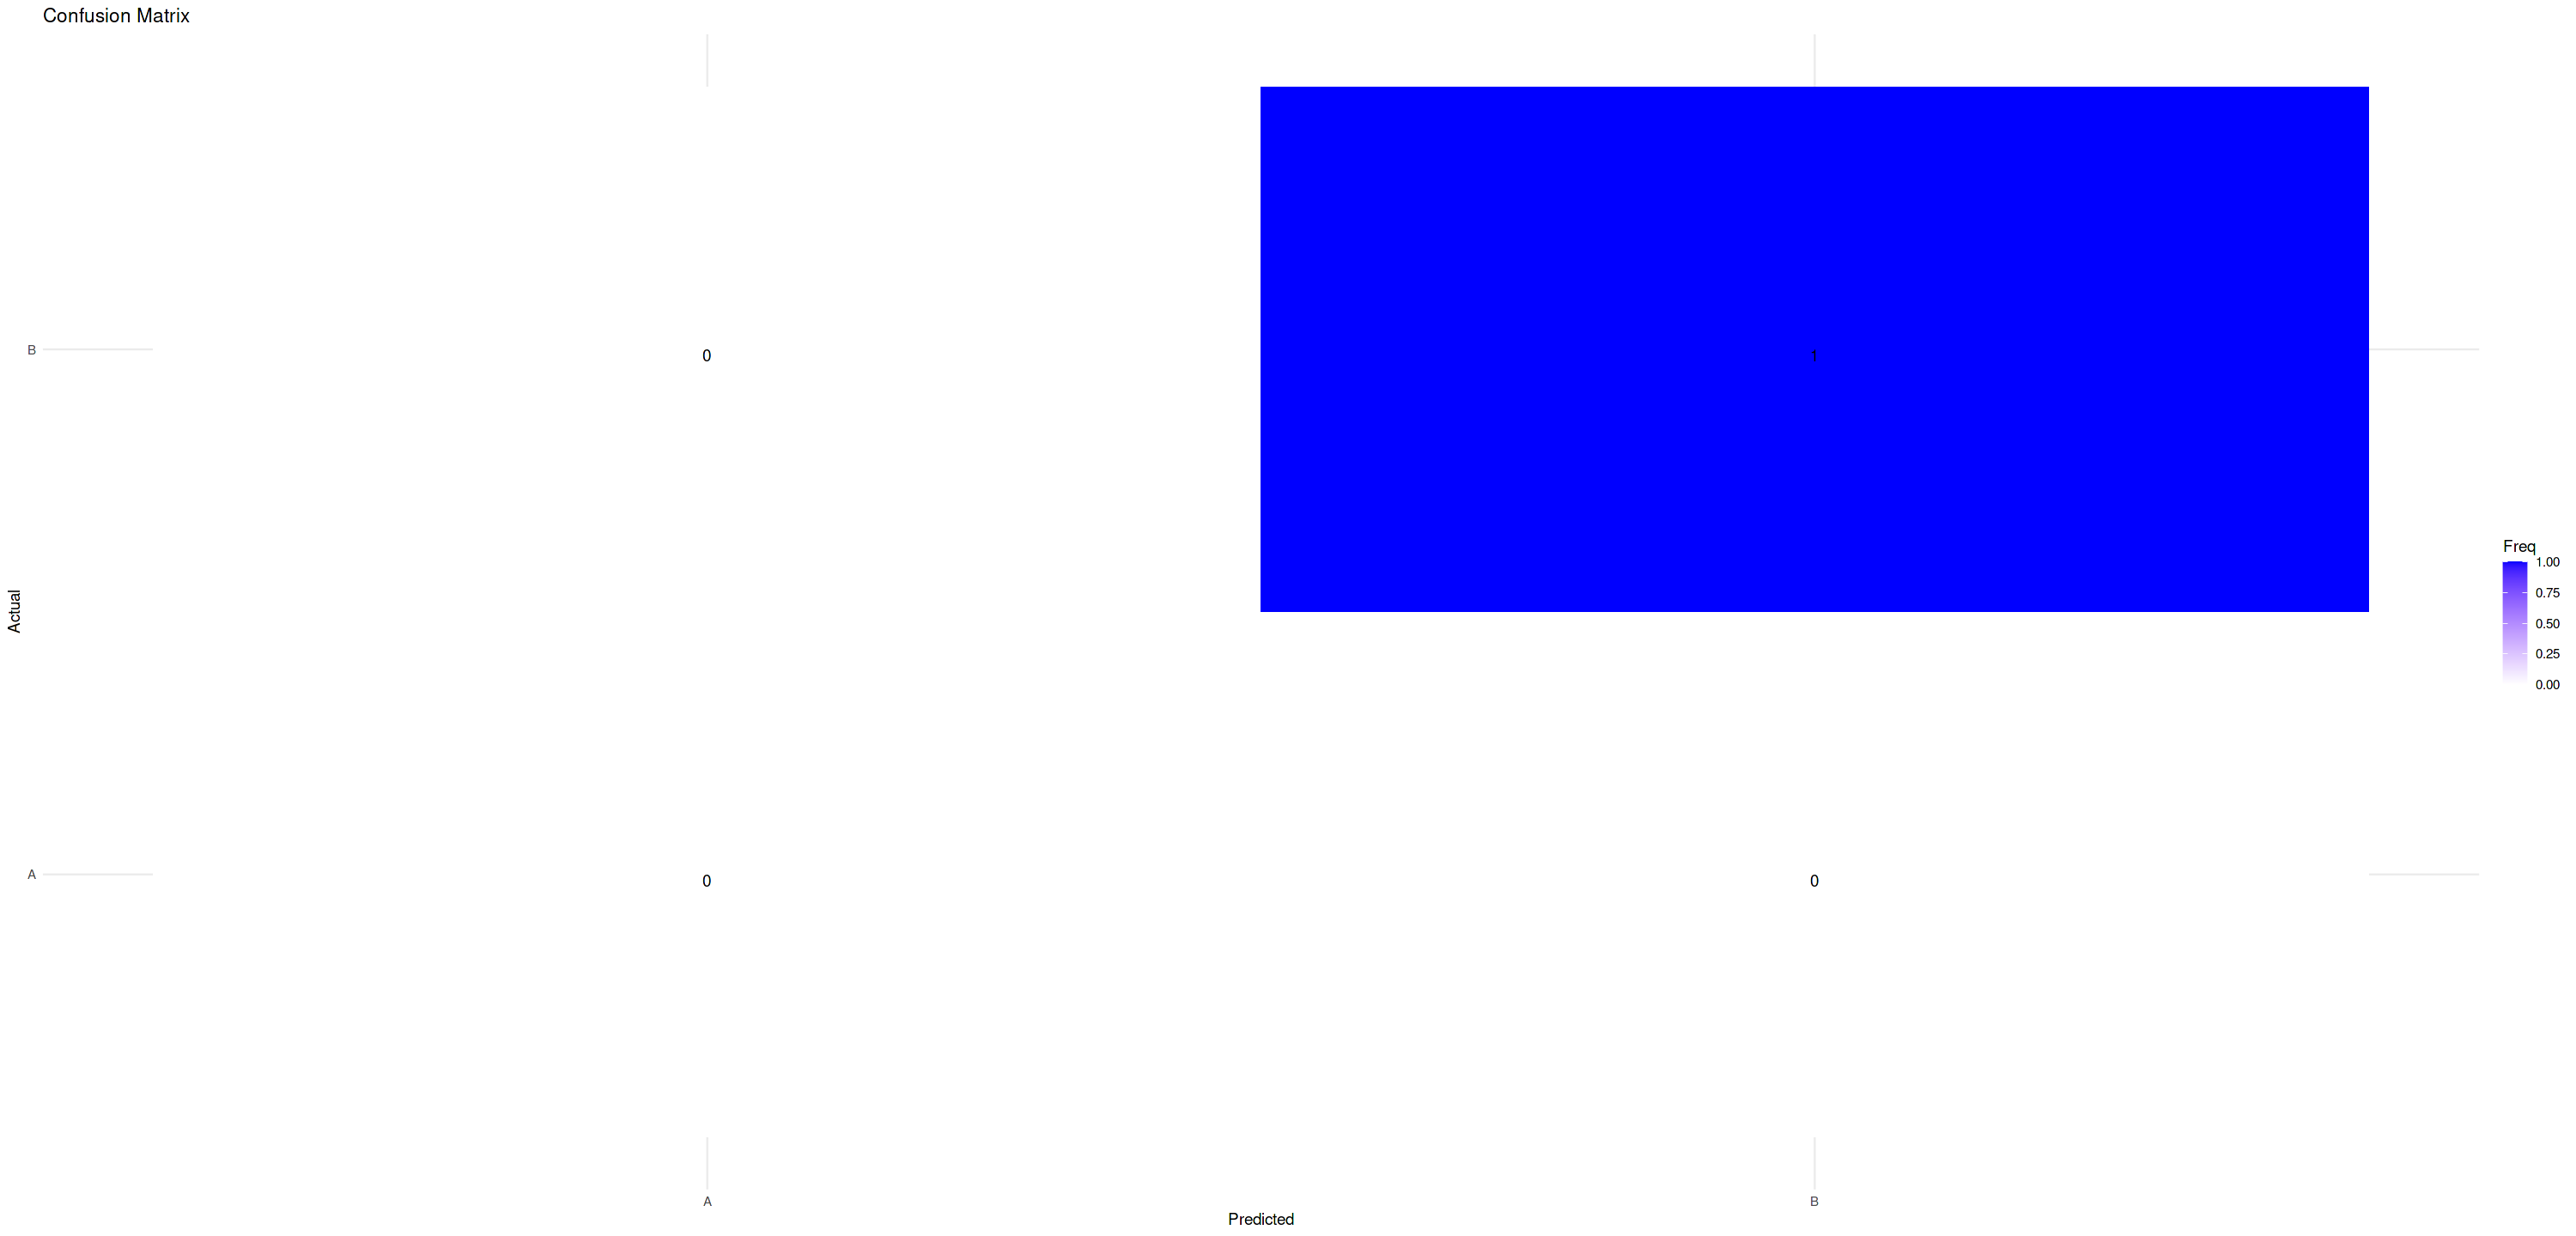

In [81]:
# Buat confusion matriks
plot_ml(x=y_valid, y=y_pred_svm, z=y_pred_prob_svm, ml="Imbalanced_Classification", type_plot="ConfusionMatrix")

### 7.4.2 Precision-Recall Curve

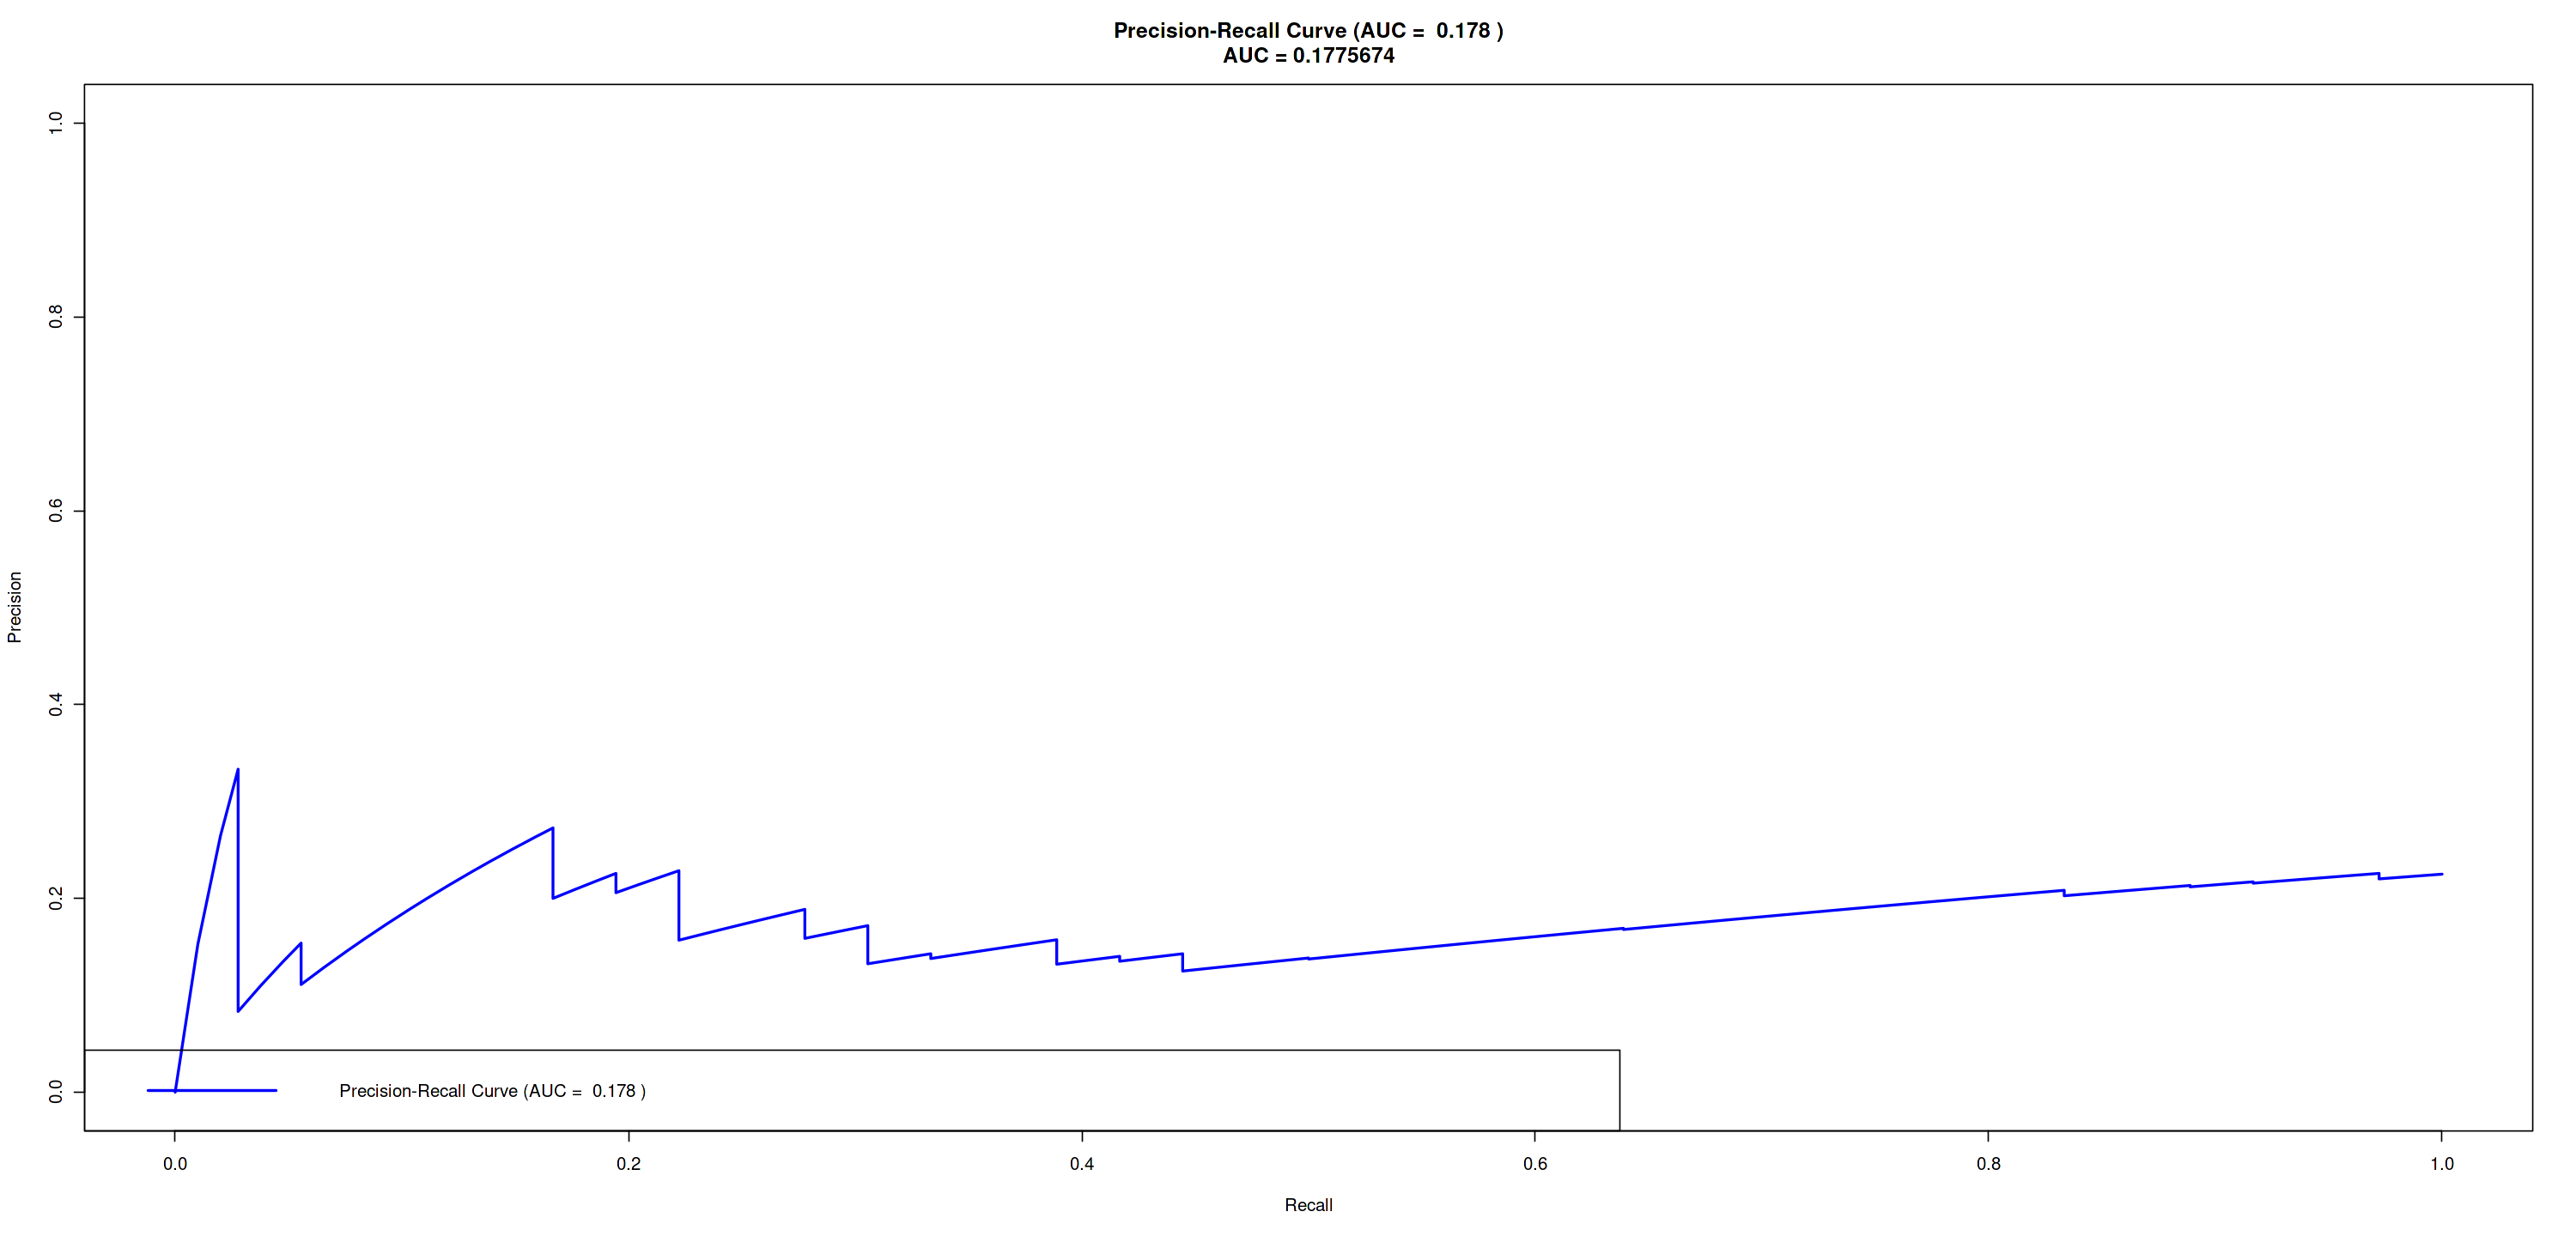

In [82]:
# Buat precision-recall curve
plot_ml(x=y_valid, y=y_pred_svm, z=y_pred_prob_svm, ml="Imbalanced_Classification", type_plot="Precision-Recall")

### 7.4.3 Cross Validation

In [83]:
# Lakukan cross-validation dengan model support vector machine
svm_cv <- ml_cv_results(model_name="SVM", model="svm", ml="Imbalanced_Classification", x=X_temp_cs, y=y_temp)
print(svm_cv)

Fold K= 1 
Fold K= 2 
Fold K= 3 
Fold K= 4 
Fold K= 5 
    Balanced.Accuracy       Precision          Recall  F1.Minorities         AUC.PR          Kappa             MCC
SVM   0.683 +/- 0.025 0.566 +/- 0.044 0.486 +/- 0.061 0.52 +/- 0.029 0.17 +/- 0.025 0.38 +/- 0.034 0.384 +/- 0.033


## 7.5 Random Forest

In [84]:
# Inisialisasi model Random Forest dengan penyesuaian bobot kelas dan pengukuran pentingnya variabel
rf_model <- randomForest::randomForest(
    x          = X_train_cs,  # Data fitur untuk pelatihan
    y          = as.factor(y_train),  # Pastikan y_train diubah menjadi faktor untuk klasifikasi
    importance = TRUE,  # Mengukur pentingnya variabel (fitur) dalam model
    classwt    = c('0' = 1, '1' = 1),  # Menyesuaikan bobot kelas untuk penyeimbangan kelas
    ntree      = 100,  # Jumlah pohon (trees) yang digunakan dalam model Random Forest
    proximity  = TRUE  # Mengaktifkan pengukuran kedekatan (proximity) antar sampel
)

# Prediksi kelas menggunakan model Random Forest
y_pred_rf <- predict(rf_model, newdata = X_valid_cs, type = "prob")[, 2]
y_pred_rf <- ifelse(y_pred_rf > 0.5, 1, 0)
      
# Prediksi probabilitas kelas positif untuk data uji
y_pred_prob_rf <- predict(rf_model, newdata = X_valid_cs, type = "prob")[, 2]

In [85]:
# Panggil fungsi ml_scores untuk mengevaluasi model random forest
rf_results <- ml_scores(model_name = "Random Forest", x=y_valid, y=y_pred_rf, z=y_pred_prob_rf, ml= "Imbalanced_Classification")
print(rf_results)

              Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa   MCC
Random Forest            0.616      0.55  0.306               0.393  0.485 0.277 0.294


### 7.5.1 Classification Report

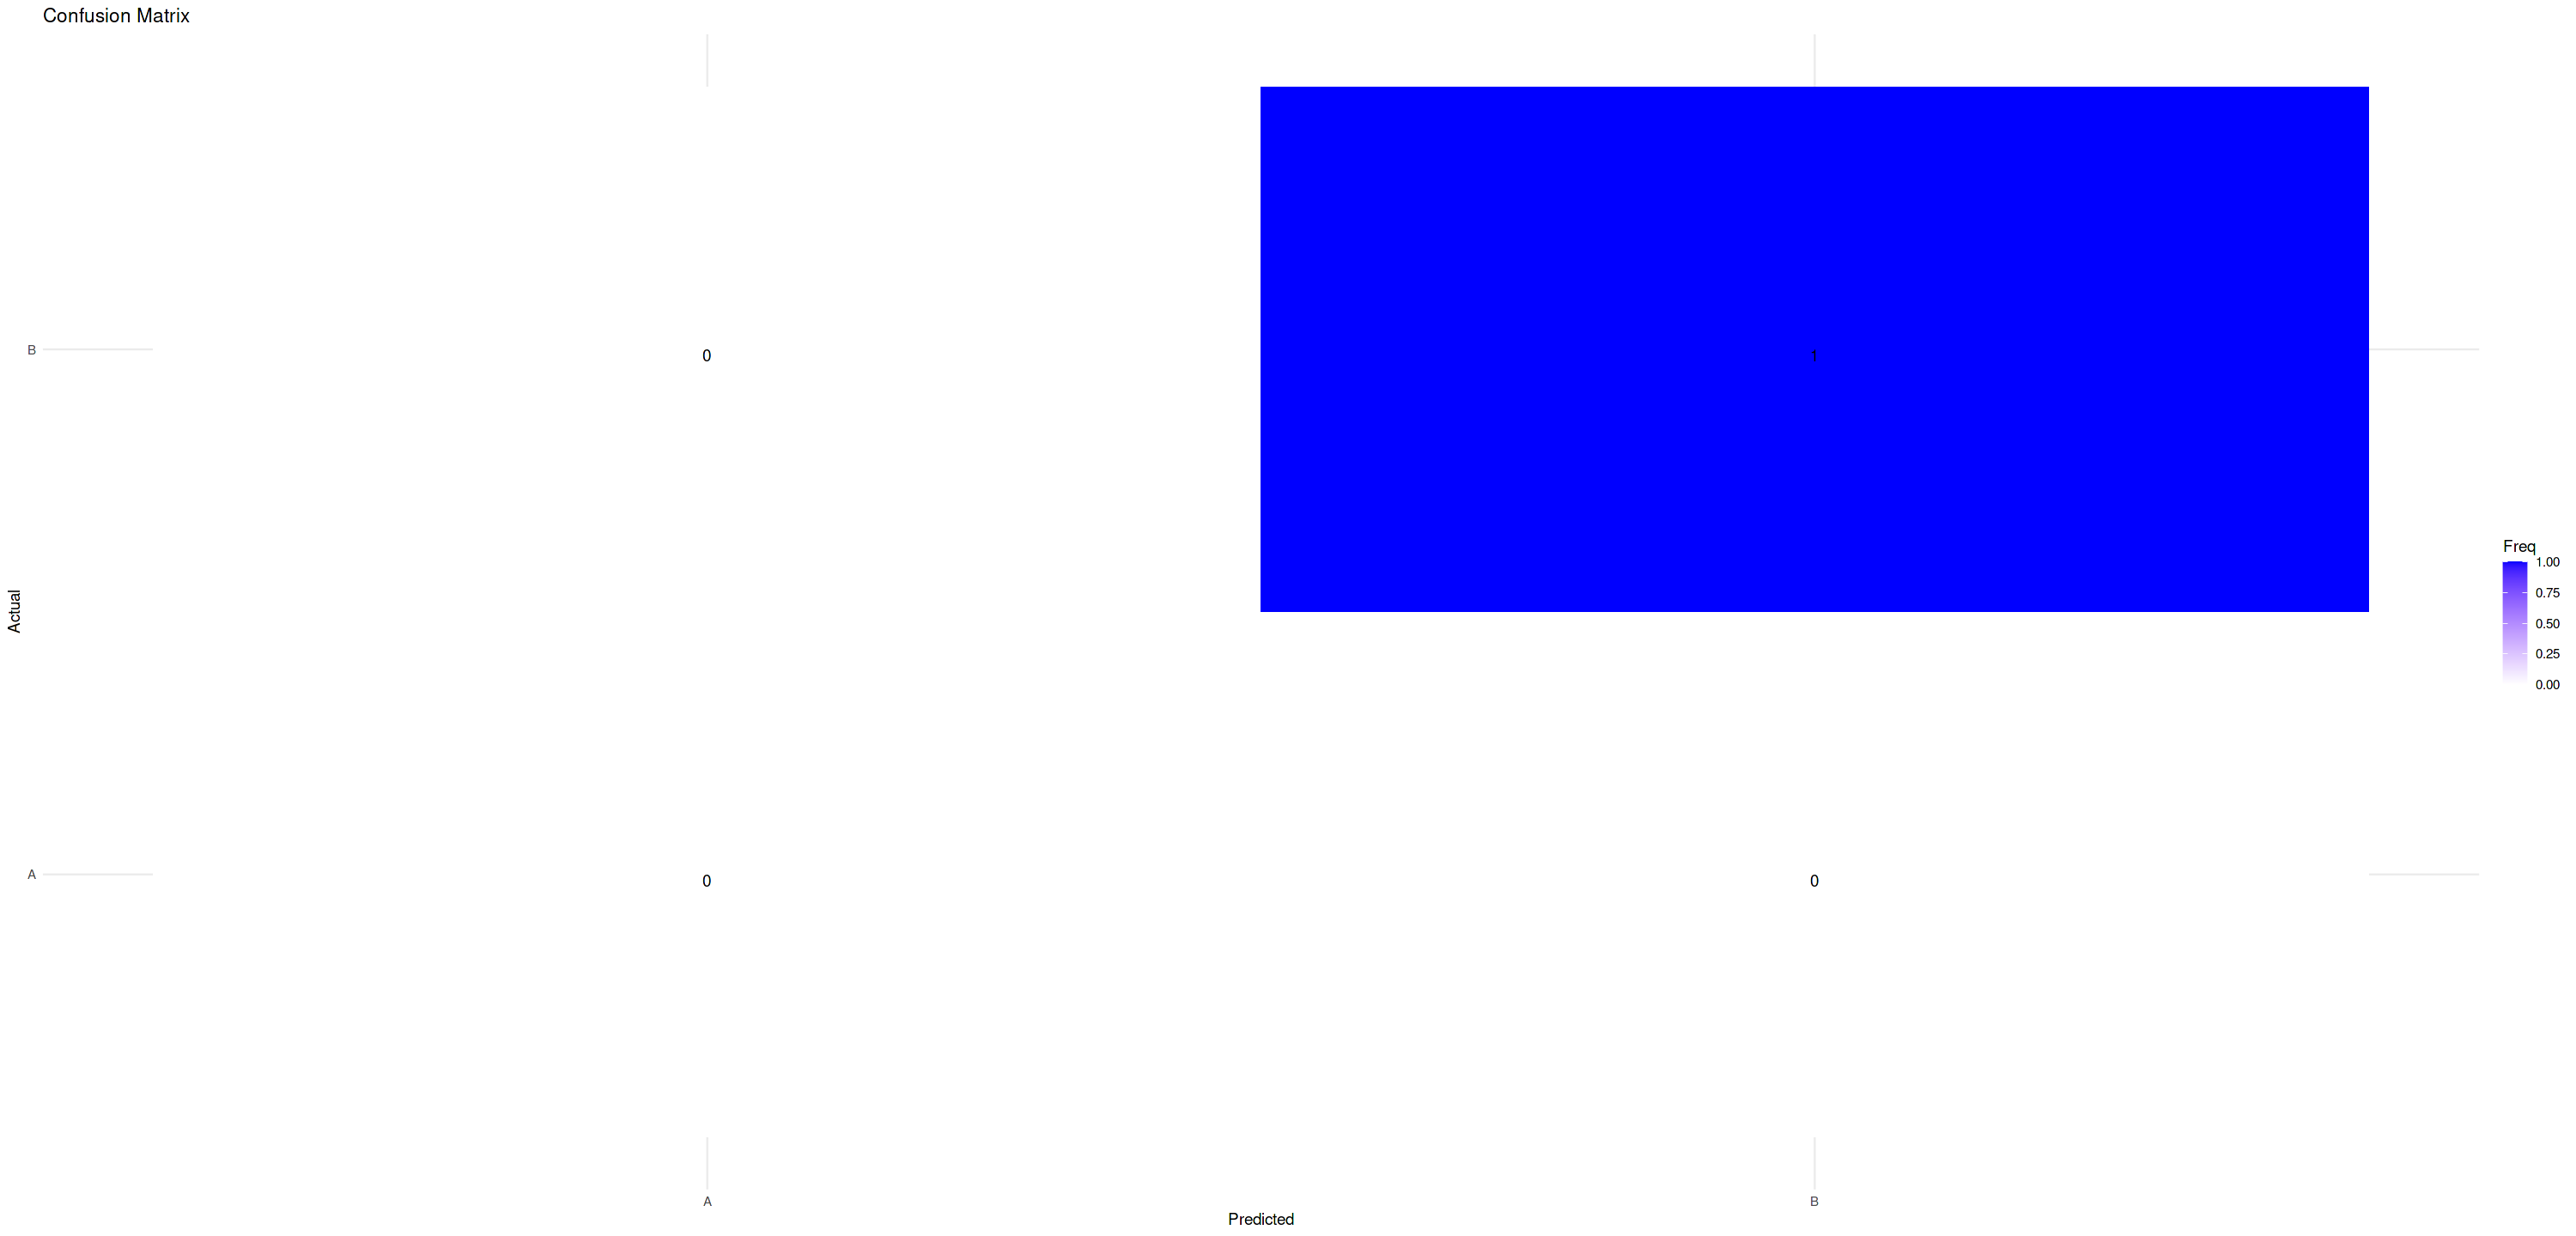

In [86]:
# Buat confusion matriks
plot_ml(x=y_valid, y=y_pred_rf, z=y_pred_prob_rf, ml="Imbalanced_Classification", type_plot="ConfusionMatrix")

### 7.5.2 Precision-Recall Curve 

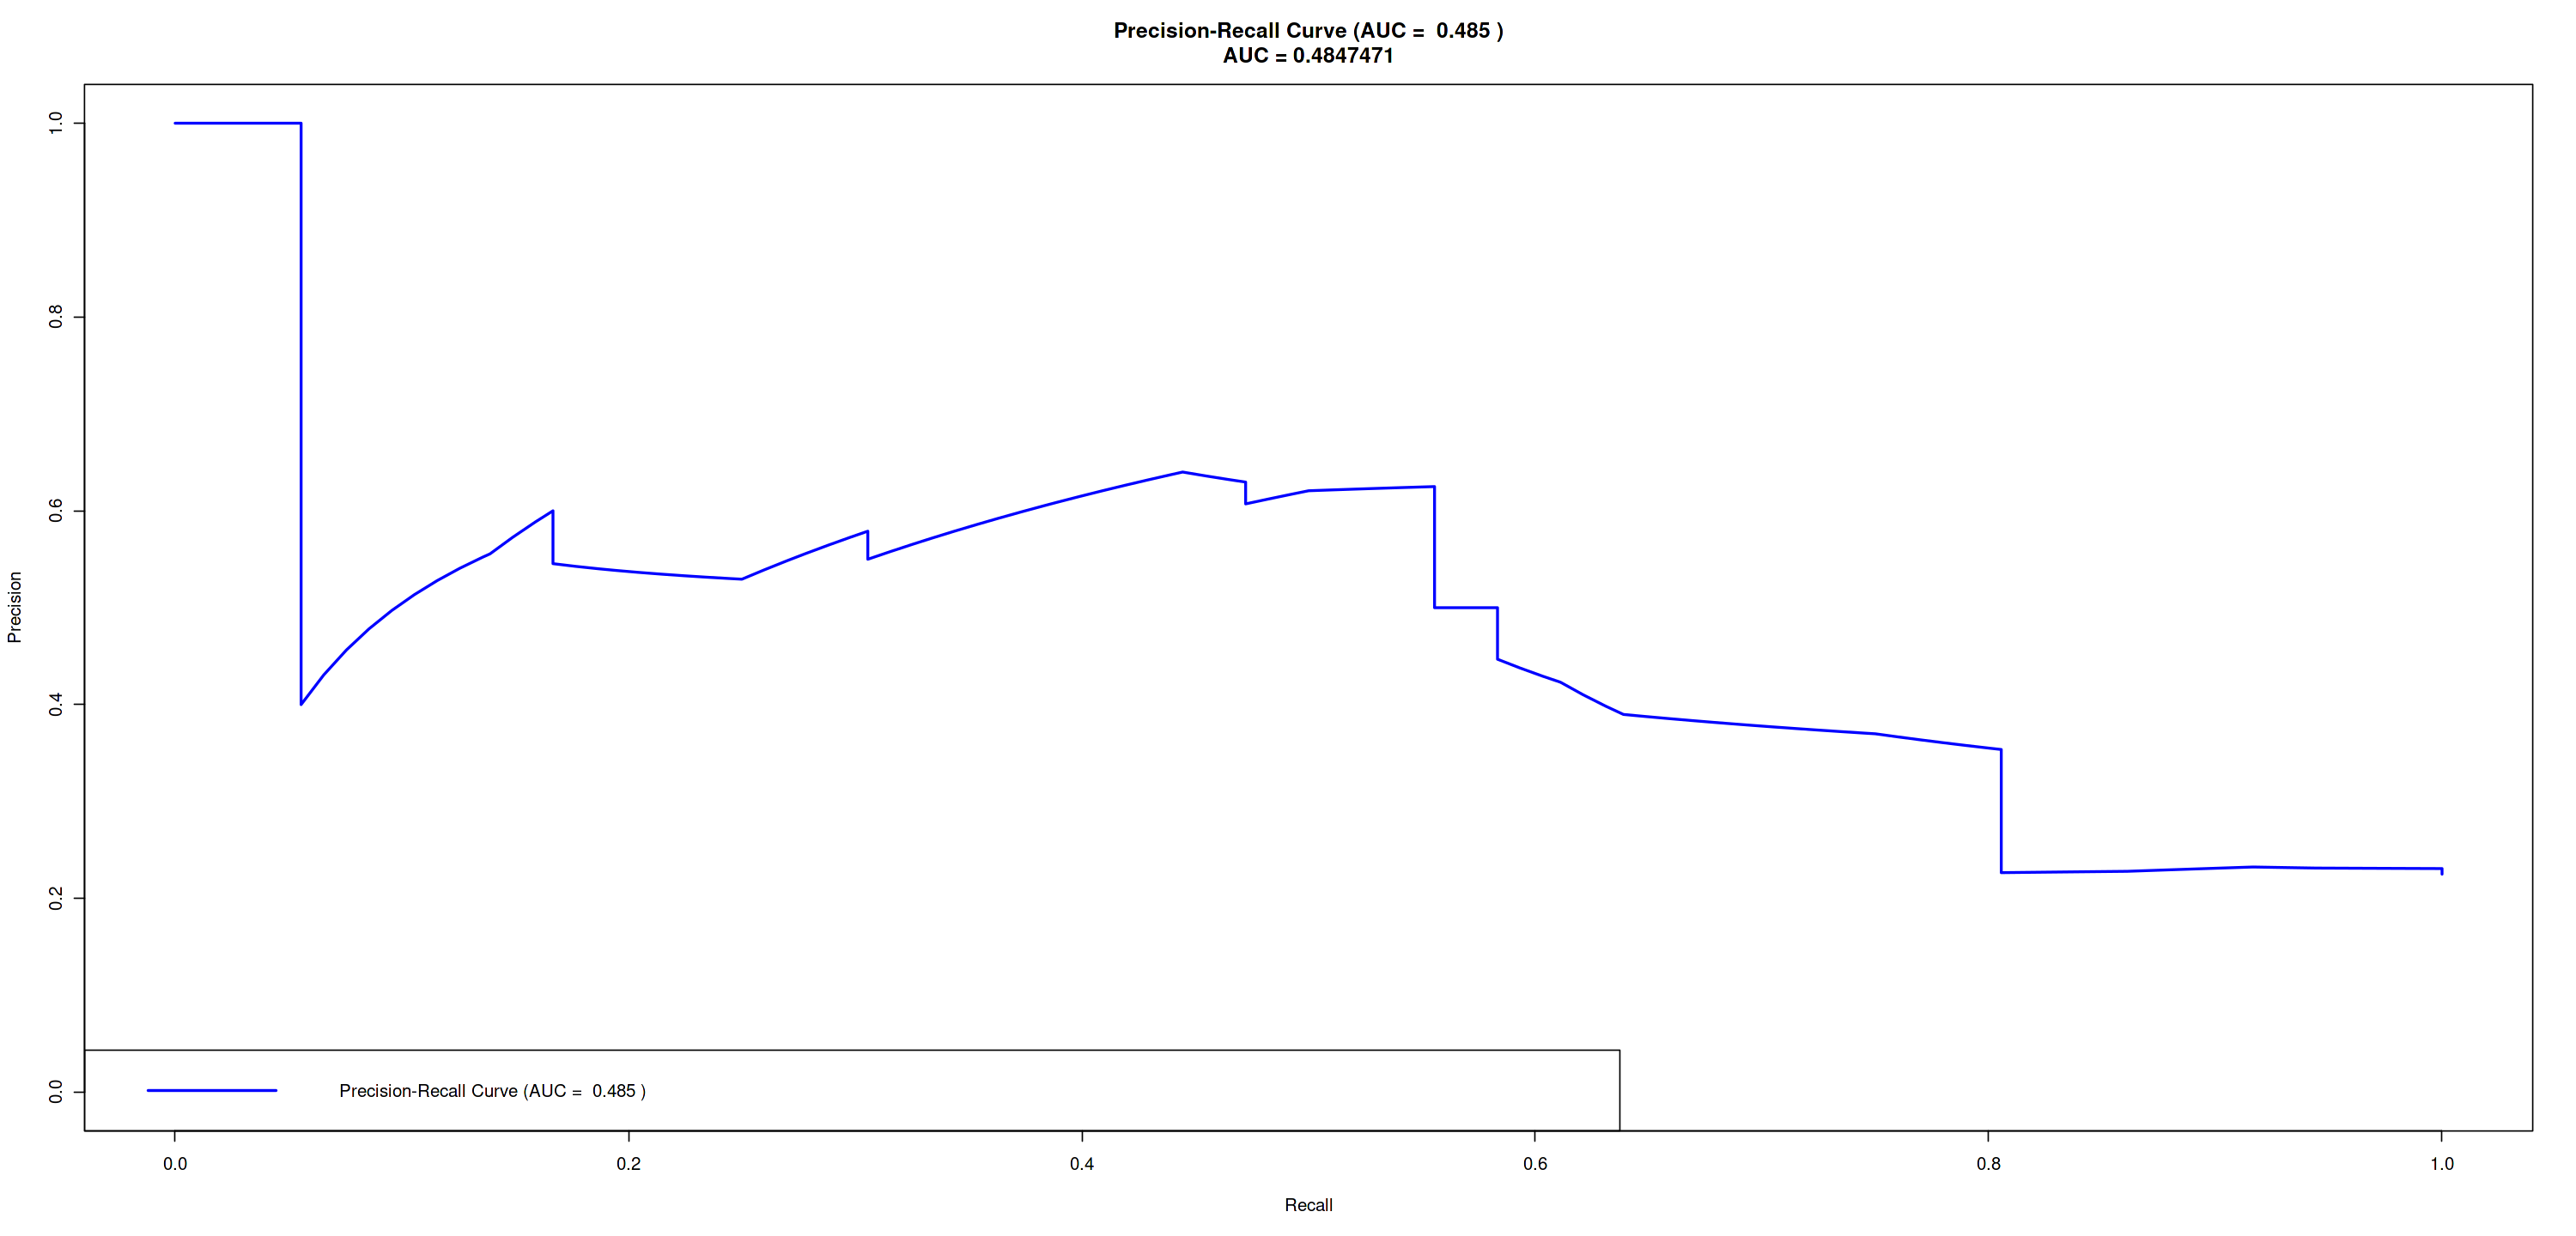

In [87]:
# Buat precision-recall curve
plot_ml(x=y_valid, y=y_pred_rf, z=y_pred_prob_rf, ml="Imbalanced_Classification", type_plot="Precision-Recall")

### 7.5.3 Cross Validation

In [88]:
# Lakukan cross-validation dengan model random forest
rf_cv <- ml_cv_results(model_name="Random Forest", model="rf", ml="Imbalanced_Classification", x=X_temp_cs, y=y_temp)
print(rf_cv)

Fold K= 1 
Fold K= 2 
Fold K= 3 
Fold K= 4 
Fold K= 5 
              Balanced.Accuracy       Precision          Recall  F1.Minorities          AUC.PR           Kappa            MCC
Random Forest    0.63 +/- 0.044 0.553 +/- 0.086 0.351 +/- 0.099 0.424 +/- 0.08 0.466 +/- 0.058 0.292 +/- 0.082 0.307 +/- 0.08


## 7.6 XGBoost

In [89]:
# Menyusun parameter untuk model XGBoost
params_xgb <- list(
    objective        = "binary:logistic",  # Menentukan tujuan klasifikasi biner dengan logistik
    eval_metric      = "auc",  # Metrik evaluasi menggunakan AUC
    max_depth        = 6,  # Kedalaman maksimum pohon
    max_delta_step   = 1,
    eta              = 0.1,  # Kecepatan pembelajaran (learning rate)
    subsample        = 0.8,
    min_child_weight = 1,
    colsample_bytree = 0.8
)

In [90]:
# Menyusun data dalam format yang diperlukan untuk XGBoost (DMatrix)
dtrain_xgb <- xgboost::xgb.DMatrix(data = as.matrix(X_train_cs), label = y_train) 
dvalid_xgb <- xgboost::xgb.DMatrix(data = as.matrix(X_valid_cs), label = y_valid)

# Melatih model XGBoost dengan parameter yang sudah ditentukan
xgb_model <- xgboost::xgb.train(
    params  = params_xgb,  # Parameter yang sudah disusun
    data    = dtrain_xgb,  # Data pelatihan dalam format DMatrix
    nrounds = 100,  # Jumlah iterasi (epoch) untuk pelatihan
)

# Prediksi menggunakan model XGBoost
y_pred_xgb <- predict(xgb_model, dvalid_xgb)
y_pred_xgb <- ifelse(y_pred_xgb > 0.5, 1, 0) # Tentukan kelas berdasarkan threshold 0.5

# Prediksi probabilitas untuk data uji
y_pred_prob_xgb <- predict(xgb_model, dvalid_xgb, type = "prob")

In [91]:
# Panggil fungsi ml_scores untuk mengevaluasi model XGBoost
xgb_results <- ml_scores(model_name = "XGBoost", x=y_valid, y=y_pred_xgb, z=y_pred_prob_xgb, ml= "Imbalanced_Classification")
print(xgb_results)

        Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa   MCC
XGBoost            0.664     0.577  0.417               0.484  0.398 0.364 0.371


### 7.6.1 Classification Report

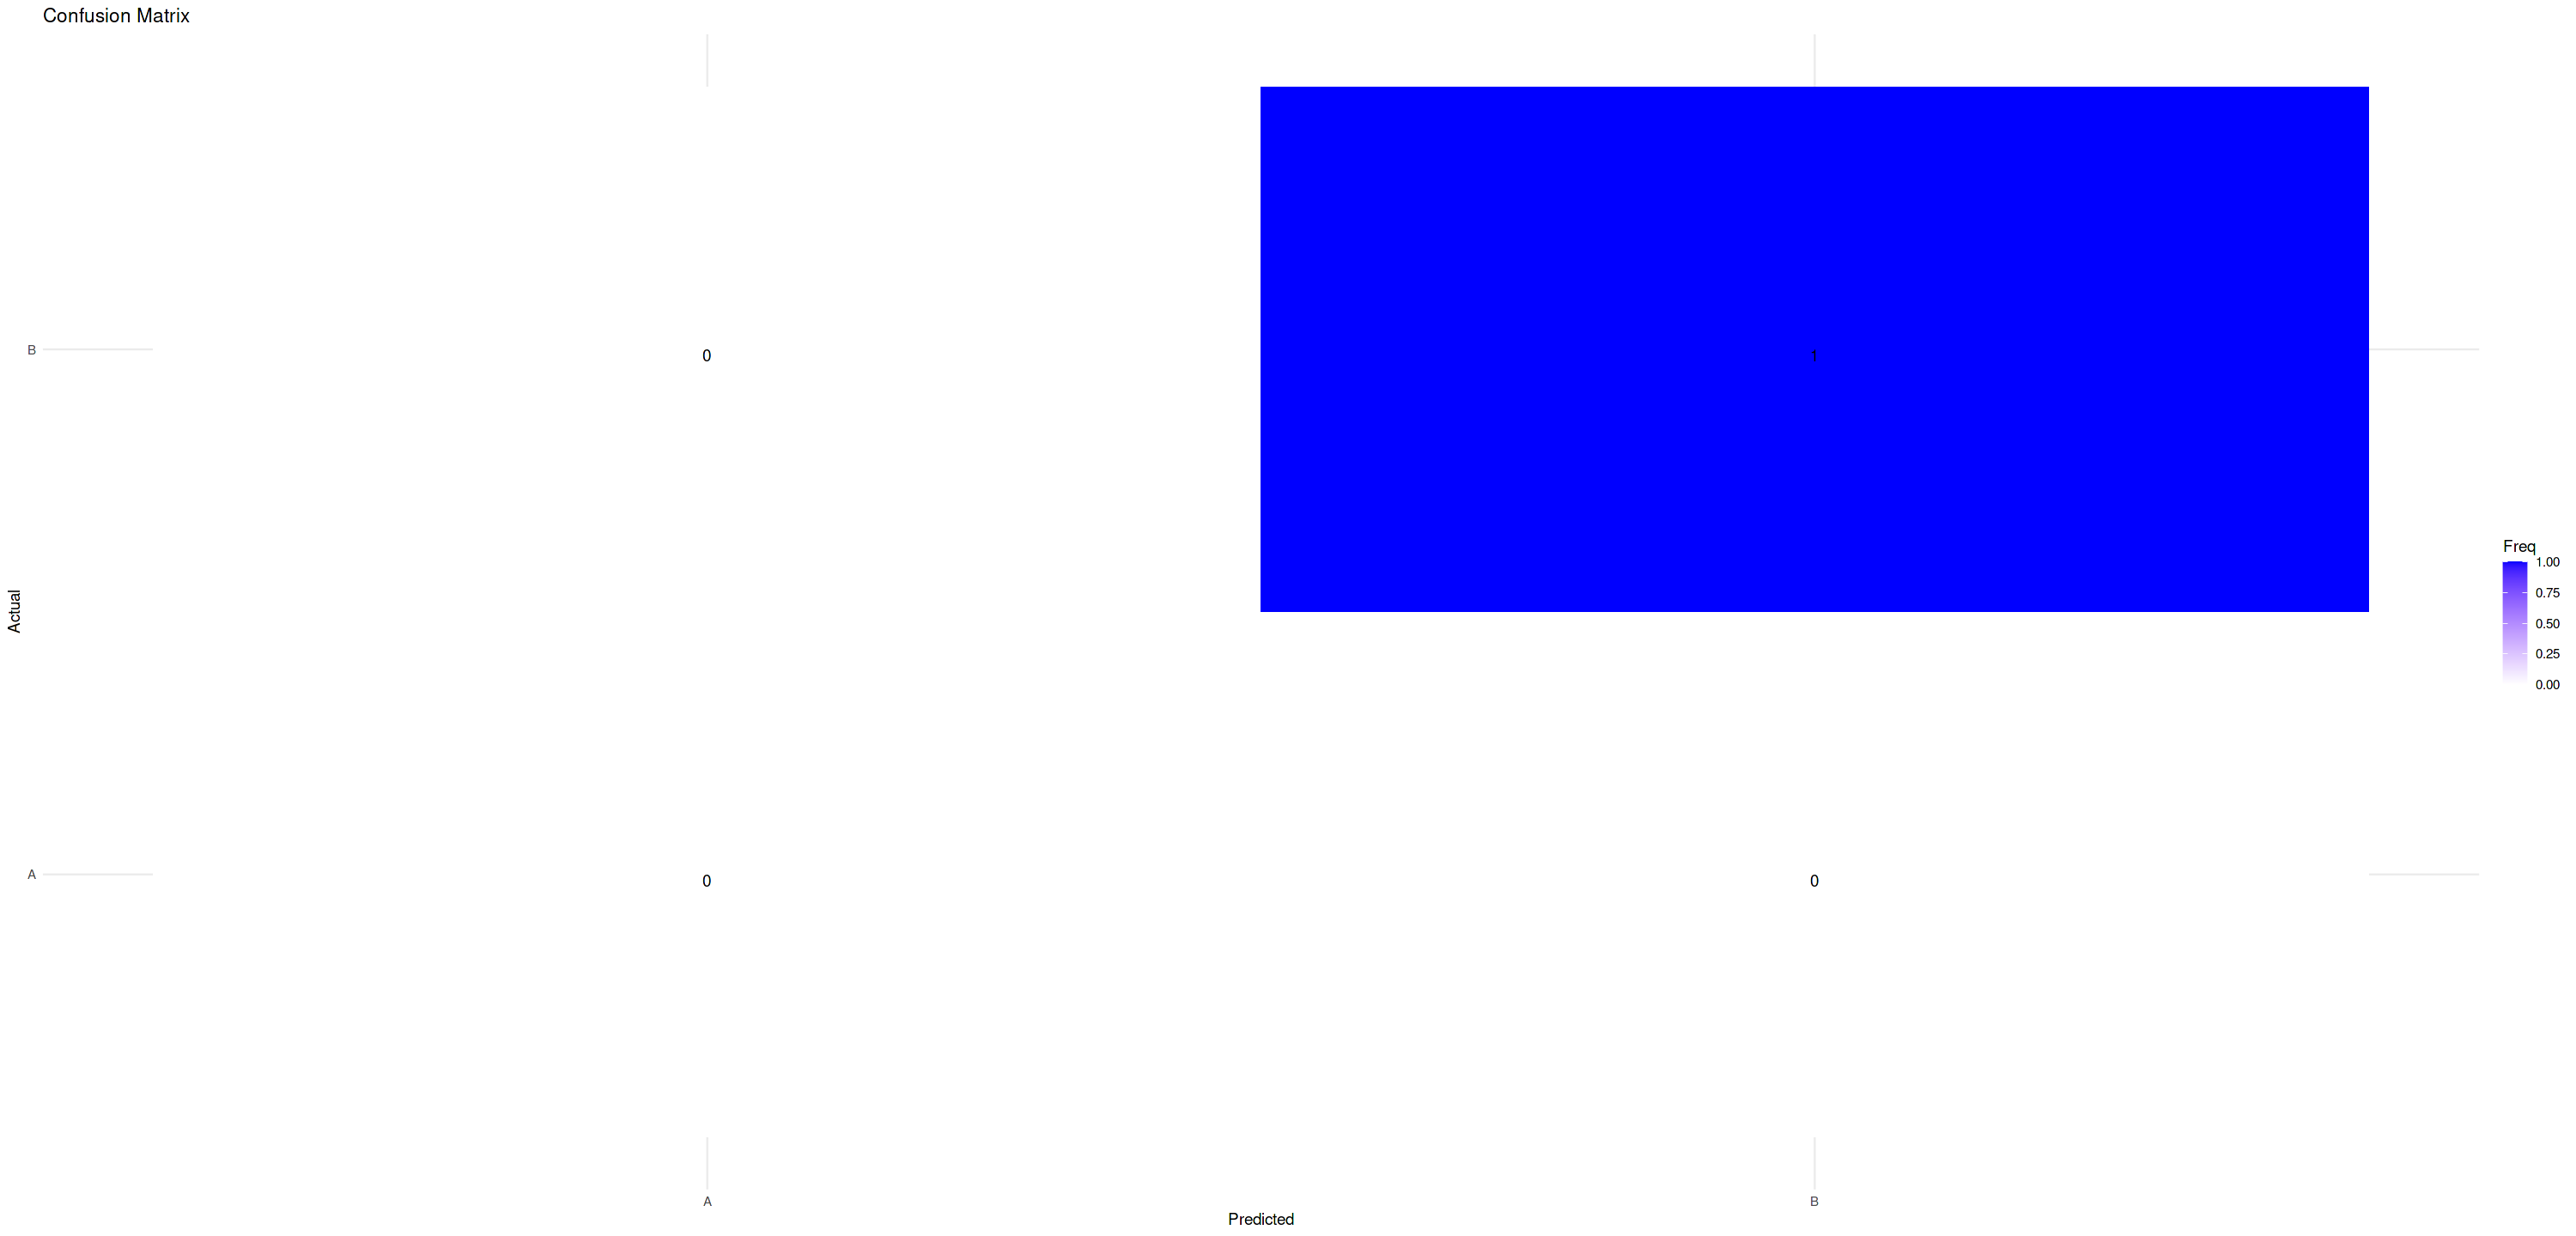

In [92]:
# Buat confusion matriks
plot_ml(x=y_valid, y=y_pred_xgb, z=y_pred_prob_xgb, ml="Imbalanced_Classification", type_plot="ConfusionMatrix")

### 7.6.2 Precision-Recall Curve 

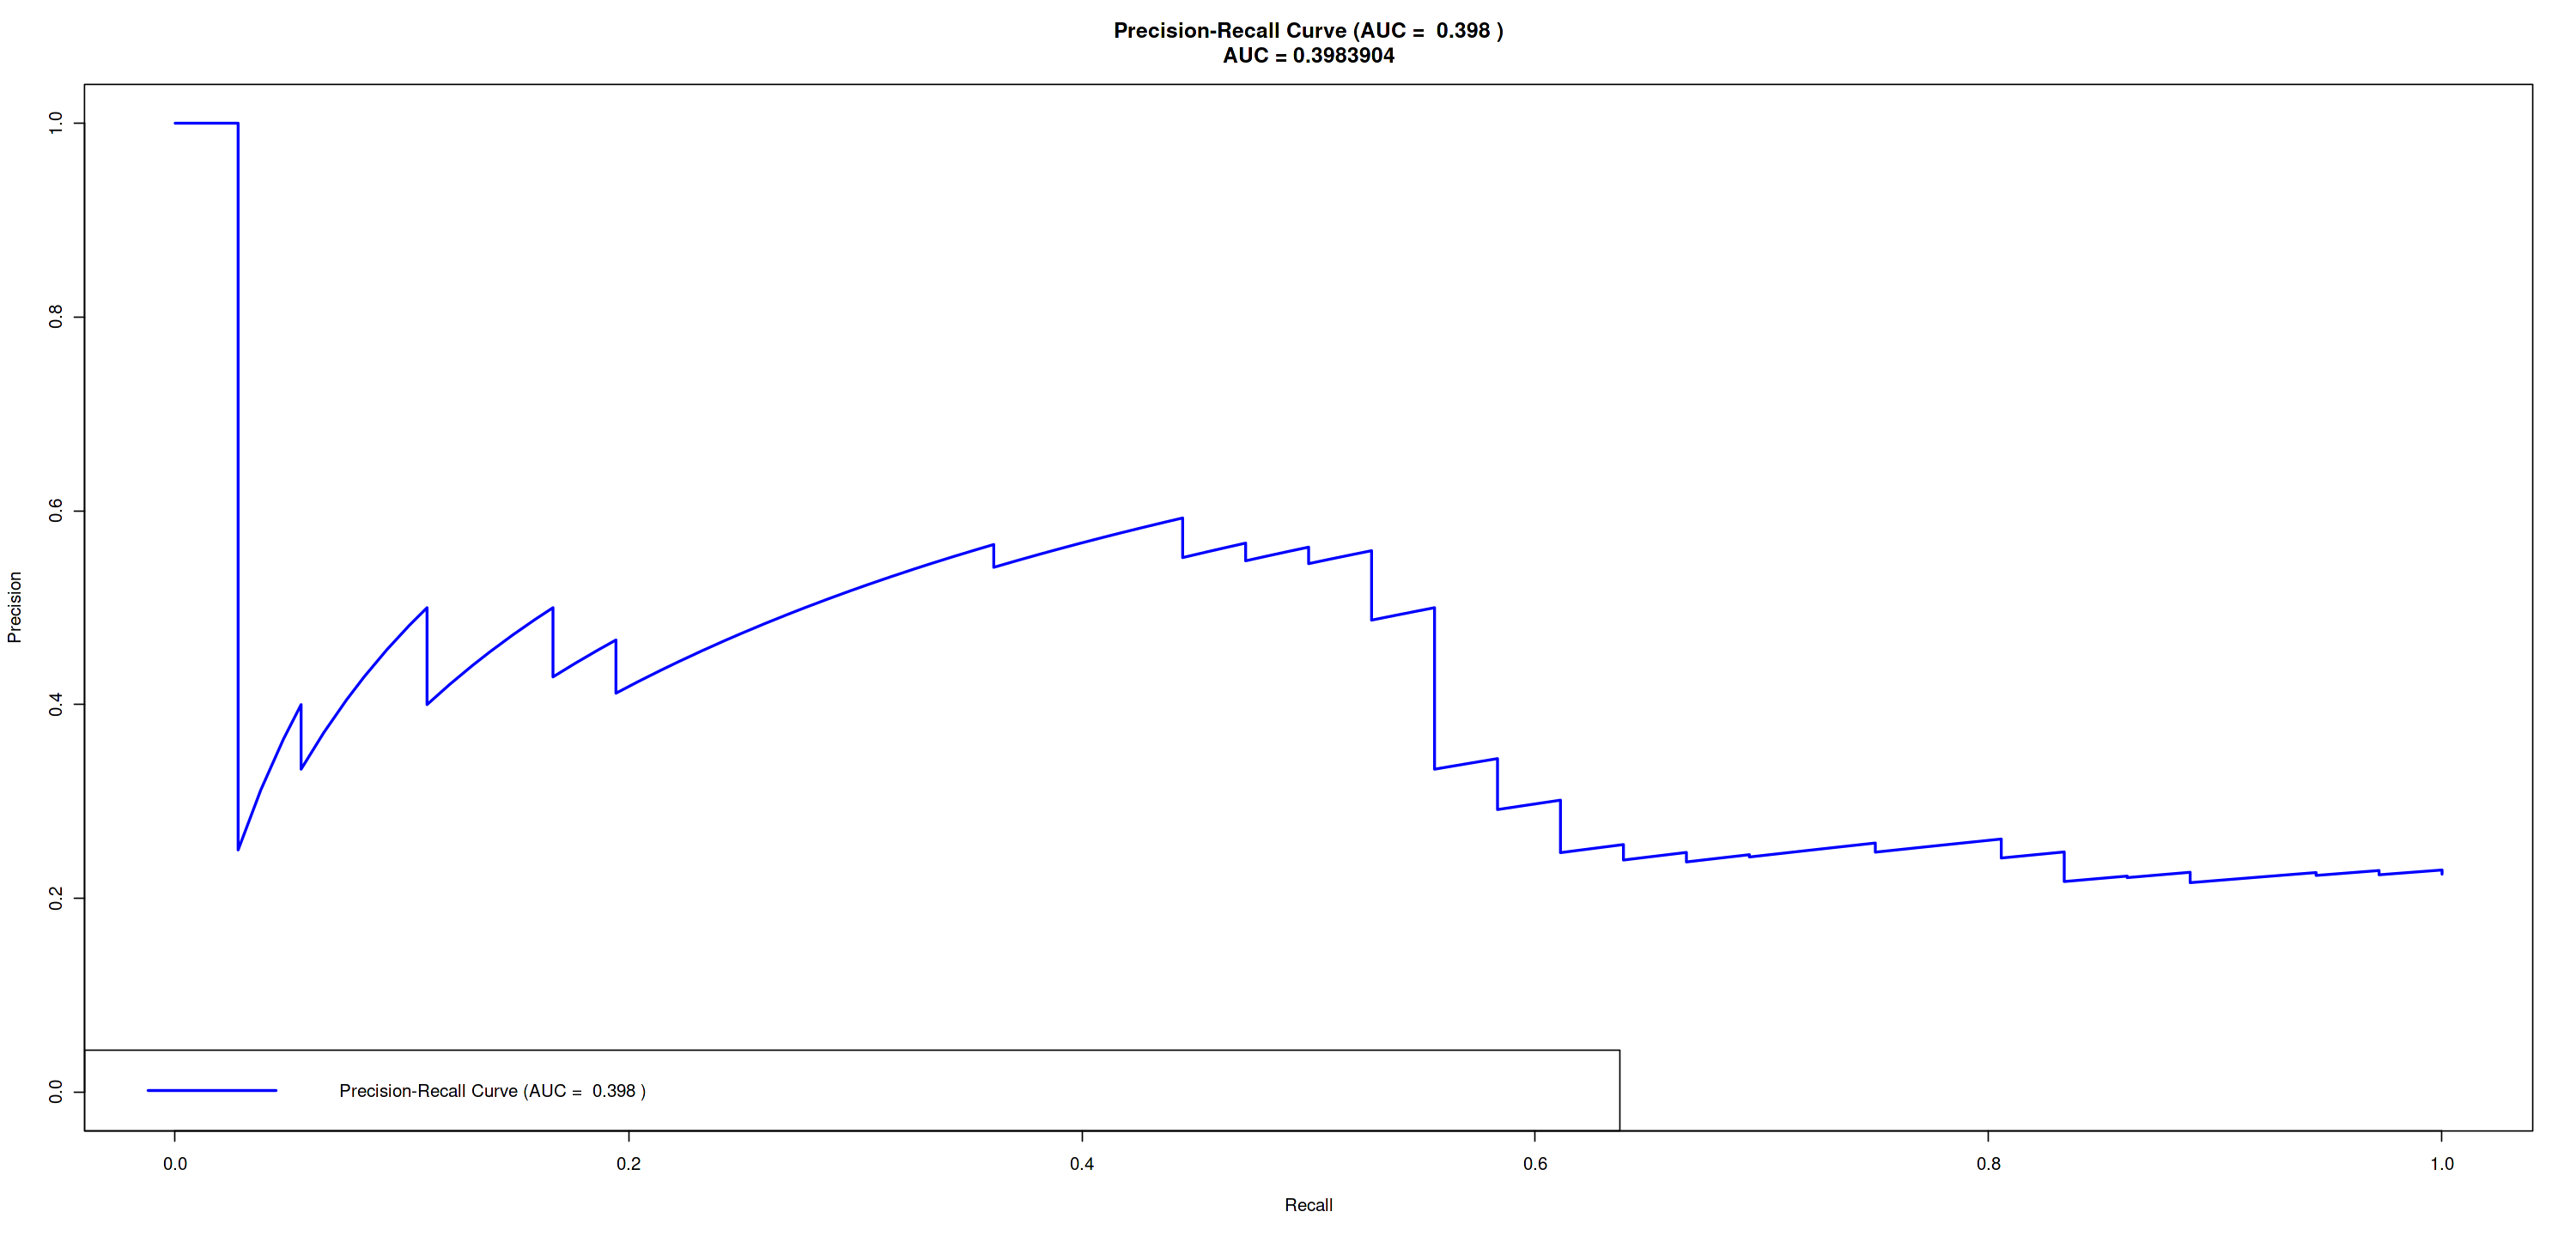

In [93]:
# Buat precision-recall curve
plot_ml(x=y_valid, y=y_pred_xgb, z=y_pred_prob_xgb, ml="Imbalanced_Classification", type_plot="Precision-Recall")

### 7.6.2 Cross Validation

In [94]:
# Lakukan cross-validation dengan model XGBoost
xgb_cv <- ml_cv_results(model_name="XGBoost", model="xgb", ml="Imbalanced_Classification", x=X_temp_cs, y=y_temp)
print(xgb_cv)

Fold K= 1 
Fold K= 2 
Fold K= 3 
Fold K= 4 
Fold K= 5 
        Balanced.Accuracy       Precision          Recall  F1.Minorities          AUC.PR          Kappa             MCC
XGBoost   0.653 +/- 0.038 0.584 +/- 0.126 0.398 +/- 0.073 0.468 +/- 0.07 0.495 +/- 0.125 0.338 +/- 0.08 0.351 +/- 0.087


## 7.7 LightGBM

In [95]:
# Menentukan parameter untuk pelatihan model LightGBM
params_lgb <- list(
    objective        = "binary",         # Klasifikasi biner (untuk dua kelas)
    metric           = "binary_error",      # Metrik evaluasi menggunakan error biner
    learning_rate    = 1,            # Kecepatan belajar yang lebih tinggi untuk pelatihan lebih cepat
    num_leaves       = 31,              # Jumlah daun pada setiap pohon dalam model
    max_depth        = -1,               # Tidak ada batas kedalaman, LightGBM akan memutuskan secara otomatis
    is_unbalance     = TRUE,          # Penanganan kelas yang tidak seimbang dalam dataset
    min_data_in_leaf = 20,        # Jumlah minimum data dalam setiap daun
    feature_fraction = 0.8,       # Proporsi fitur yang digunakan dalam setiap iterasi
    bagging_fraction = 0.8,       # Proporsi data yang digunakan dalam setiap iterasi
    bagging_freq     = 5              # Frekuensi bagging, berapa banyak iterasi yang menggunakan subsample data
)

# Menyusun data pelatihan dan validasi dalam format LightGBM (lgb.Dataset)
dtrain_lgb <- lightgbm::lgb.Dataset(data = as.matrix(X_train_cs), label = y_train)  # Data pelatihan (fitur dan label)
dvalid_lgb <- lightgbm::lgb.Dataset(data = as.matrix(X_valid_cs), label = y_valid)  # Data validasi (fitur dan label)
        
# Melatih model LightGBM dengan mekanisme early stopping untuk menghindari overfitting
lgb_model <- lightgbm::lgb.train(
    params  = params_lgb,               # Parameter yang sudah disusun sebelumnya
    data    = dtrain_lgb,                  # Data pelatihan
    valids  = list(valid = dvalid_lgb),  # Data validasi untuk memonitor performa selama pelatihan
    nrounds = 100,                     # Jumlah iterasi (epoch) untuk pelatihan
    early_stopping_rounds = 3L         # Early stopping jika tidak ada perbaikan setelah 3 iterasi
)

# Prediksi menggunakan model LightGBM
y_pred_lgb <- predict(lgb_model, as.matrix(X_valid_cs))
y_pred_lgb <- ifelse(y_pred_lgb > 0.5, 1, 0) # Tentukan kelas berdasarkan threshold 0.5

# Prediksi probabilitas untuk data uji
y_pred_prob_lgb <- predict(lgb_model, as.matrix(X_valid_cs), type = "prob")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 161, number of negative: 479
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004928 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.251563 -> initscore=-1.090296
[LightGBM] [Info] Start training from score -1.090296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]:  valid's binary_error:0.34375 
Will train until there is no improvement in 3 rounds.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]:  valid's binary_error:0.2625 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]:  valid's binary_error:0.25625 
[LightGBM] [Warning] No further splits with pos

In [96]:
# Panggil fungsi ml_scores untuk mengevaluasi model lightgbm
lgb_results <- ml_scores(model_name = "LightGBM", x=y_valid, y=y_pred_lgb, z=y_pred_prob_lgb, ml= "Imbalanced_Classification")
print(lgb_results)

         Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa   MCC
LightGBM            0.676     0.531  0.472                 0.5   0.43 0.366 0.367


### 7.7.1 Classification Report

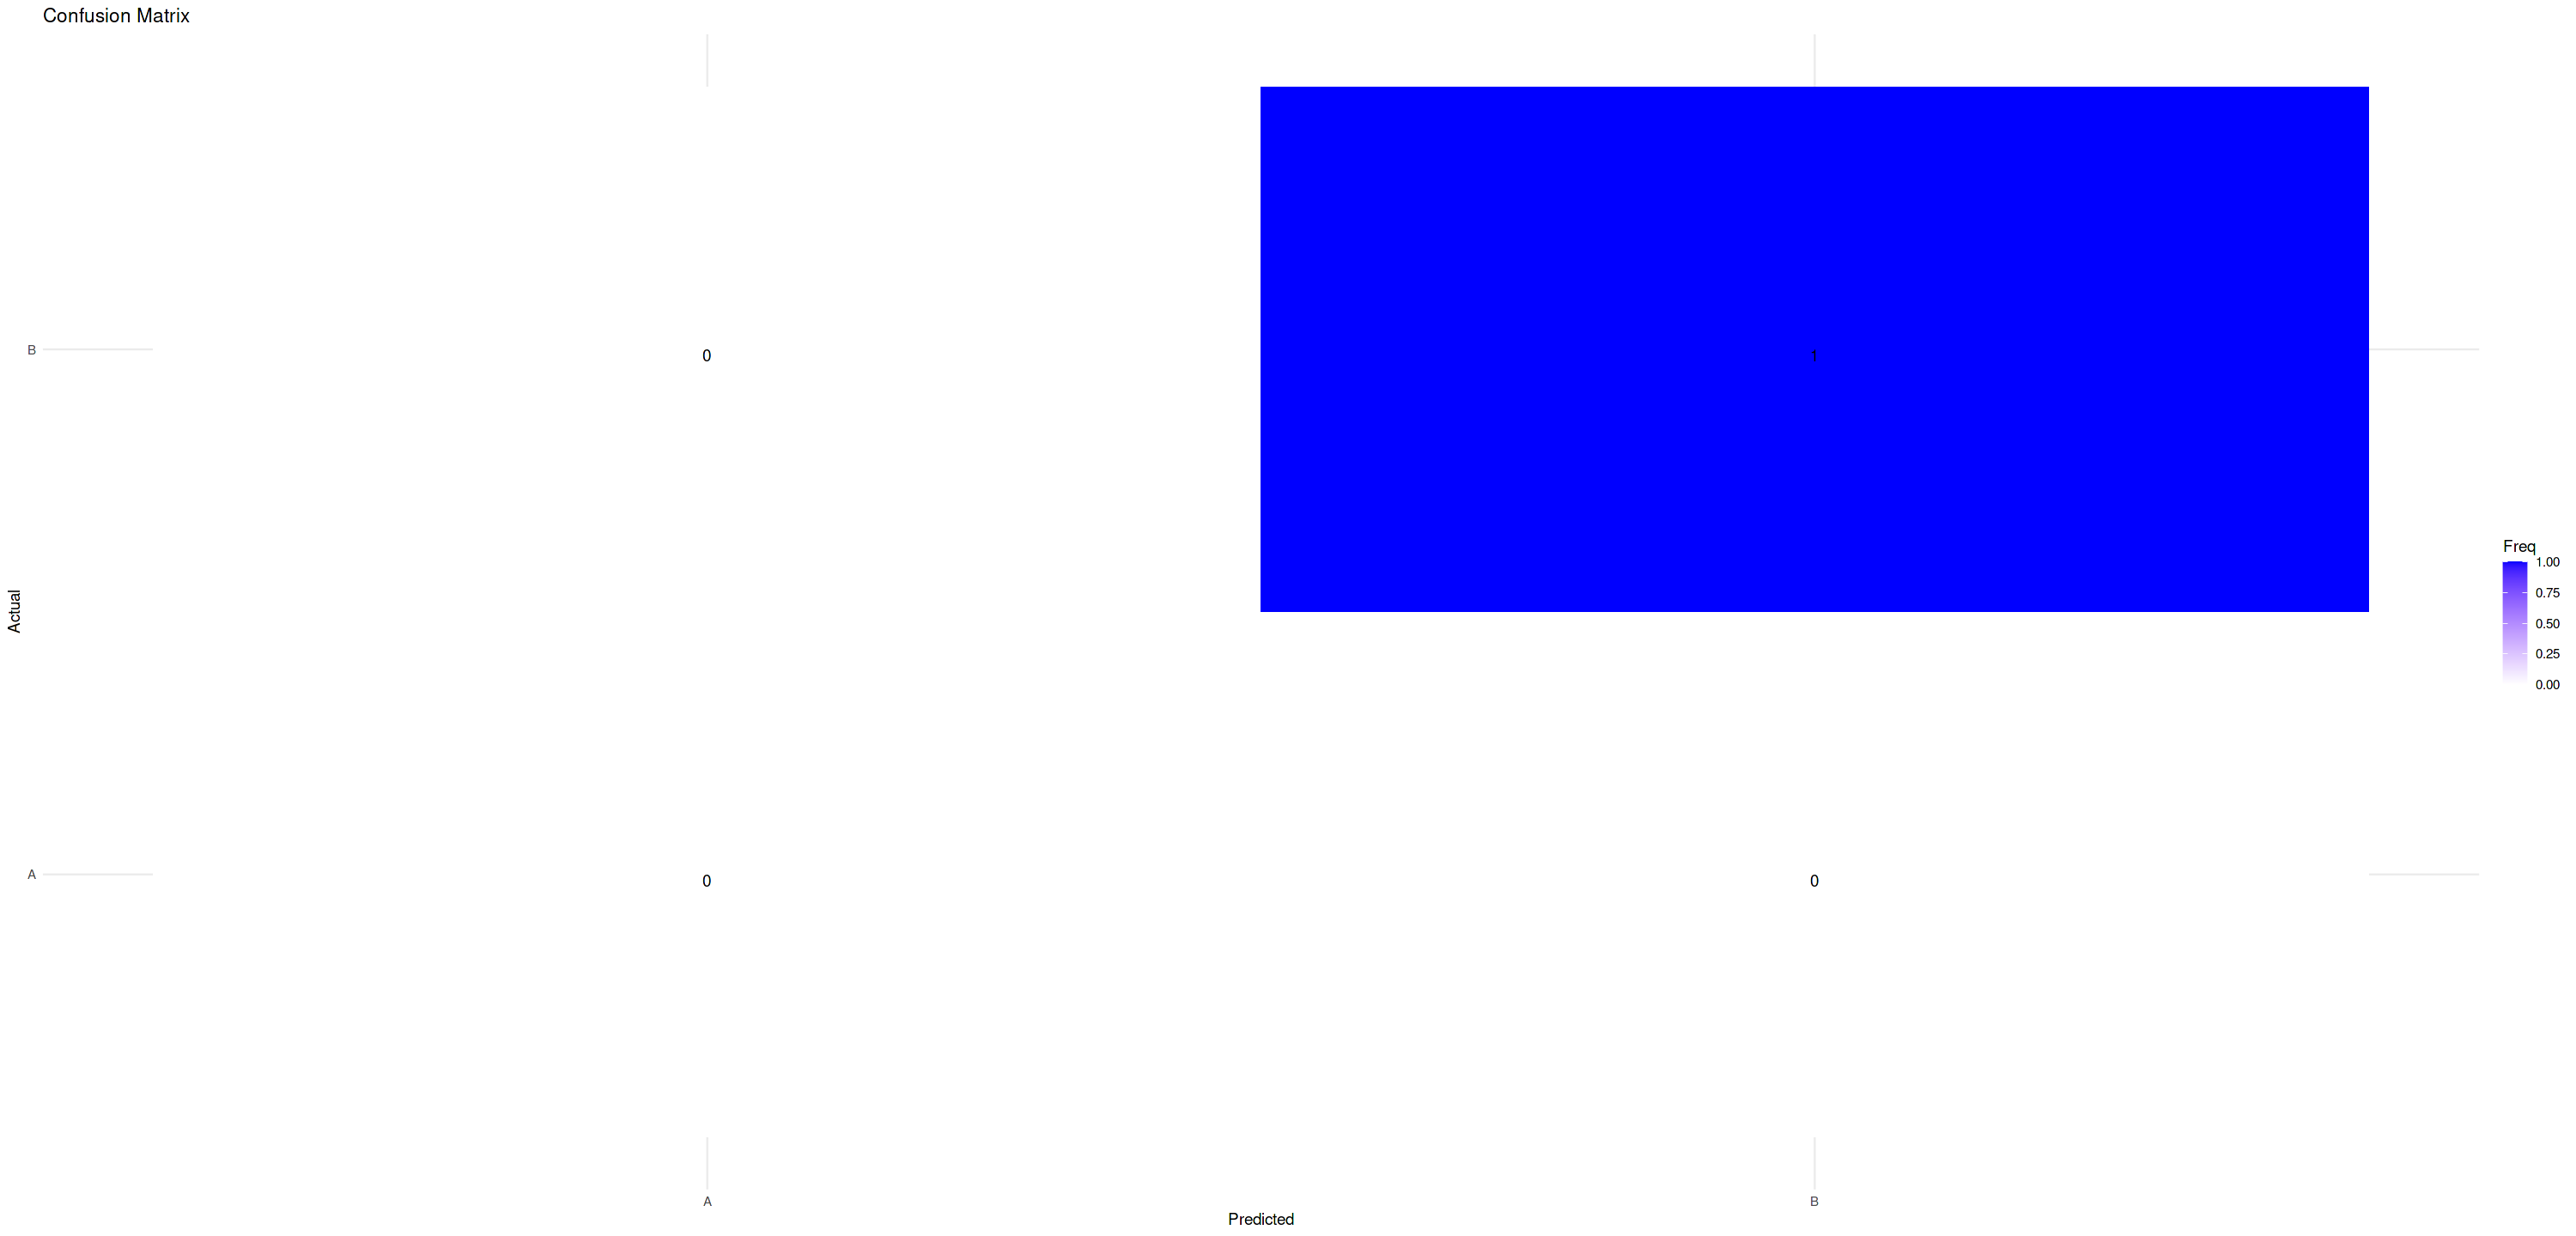

In [97]:
# Buat confusion matriks
plot_ml(x=y_valid, y=y_pred_lgb, z=y_pred_prob_lgb, ml="Imbalanced_Classification", type_plot="ConfusionMatrix")

### 7.7.2 Precision-Recall Curve 

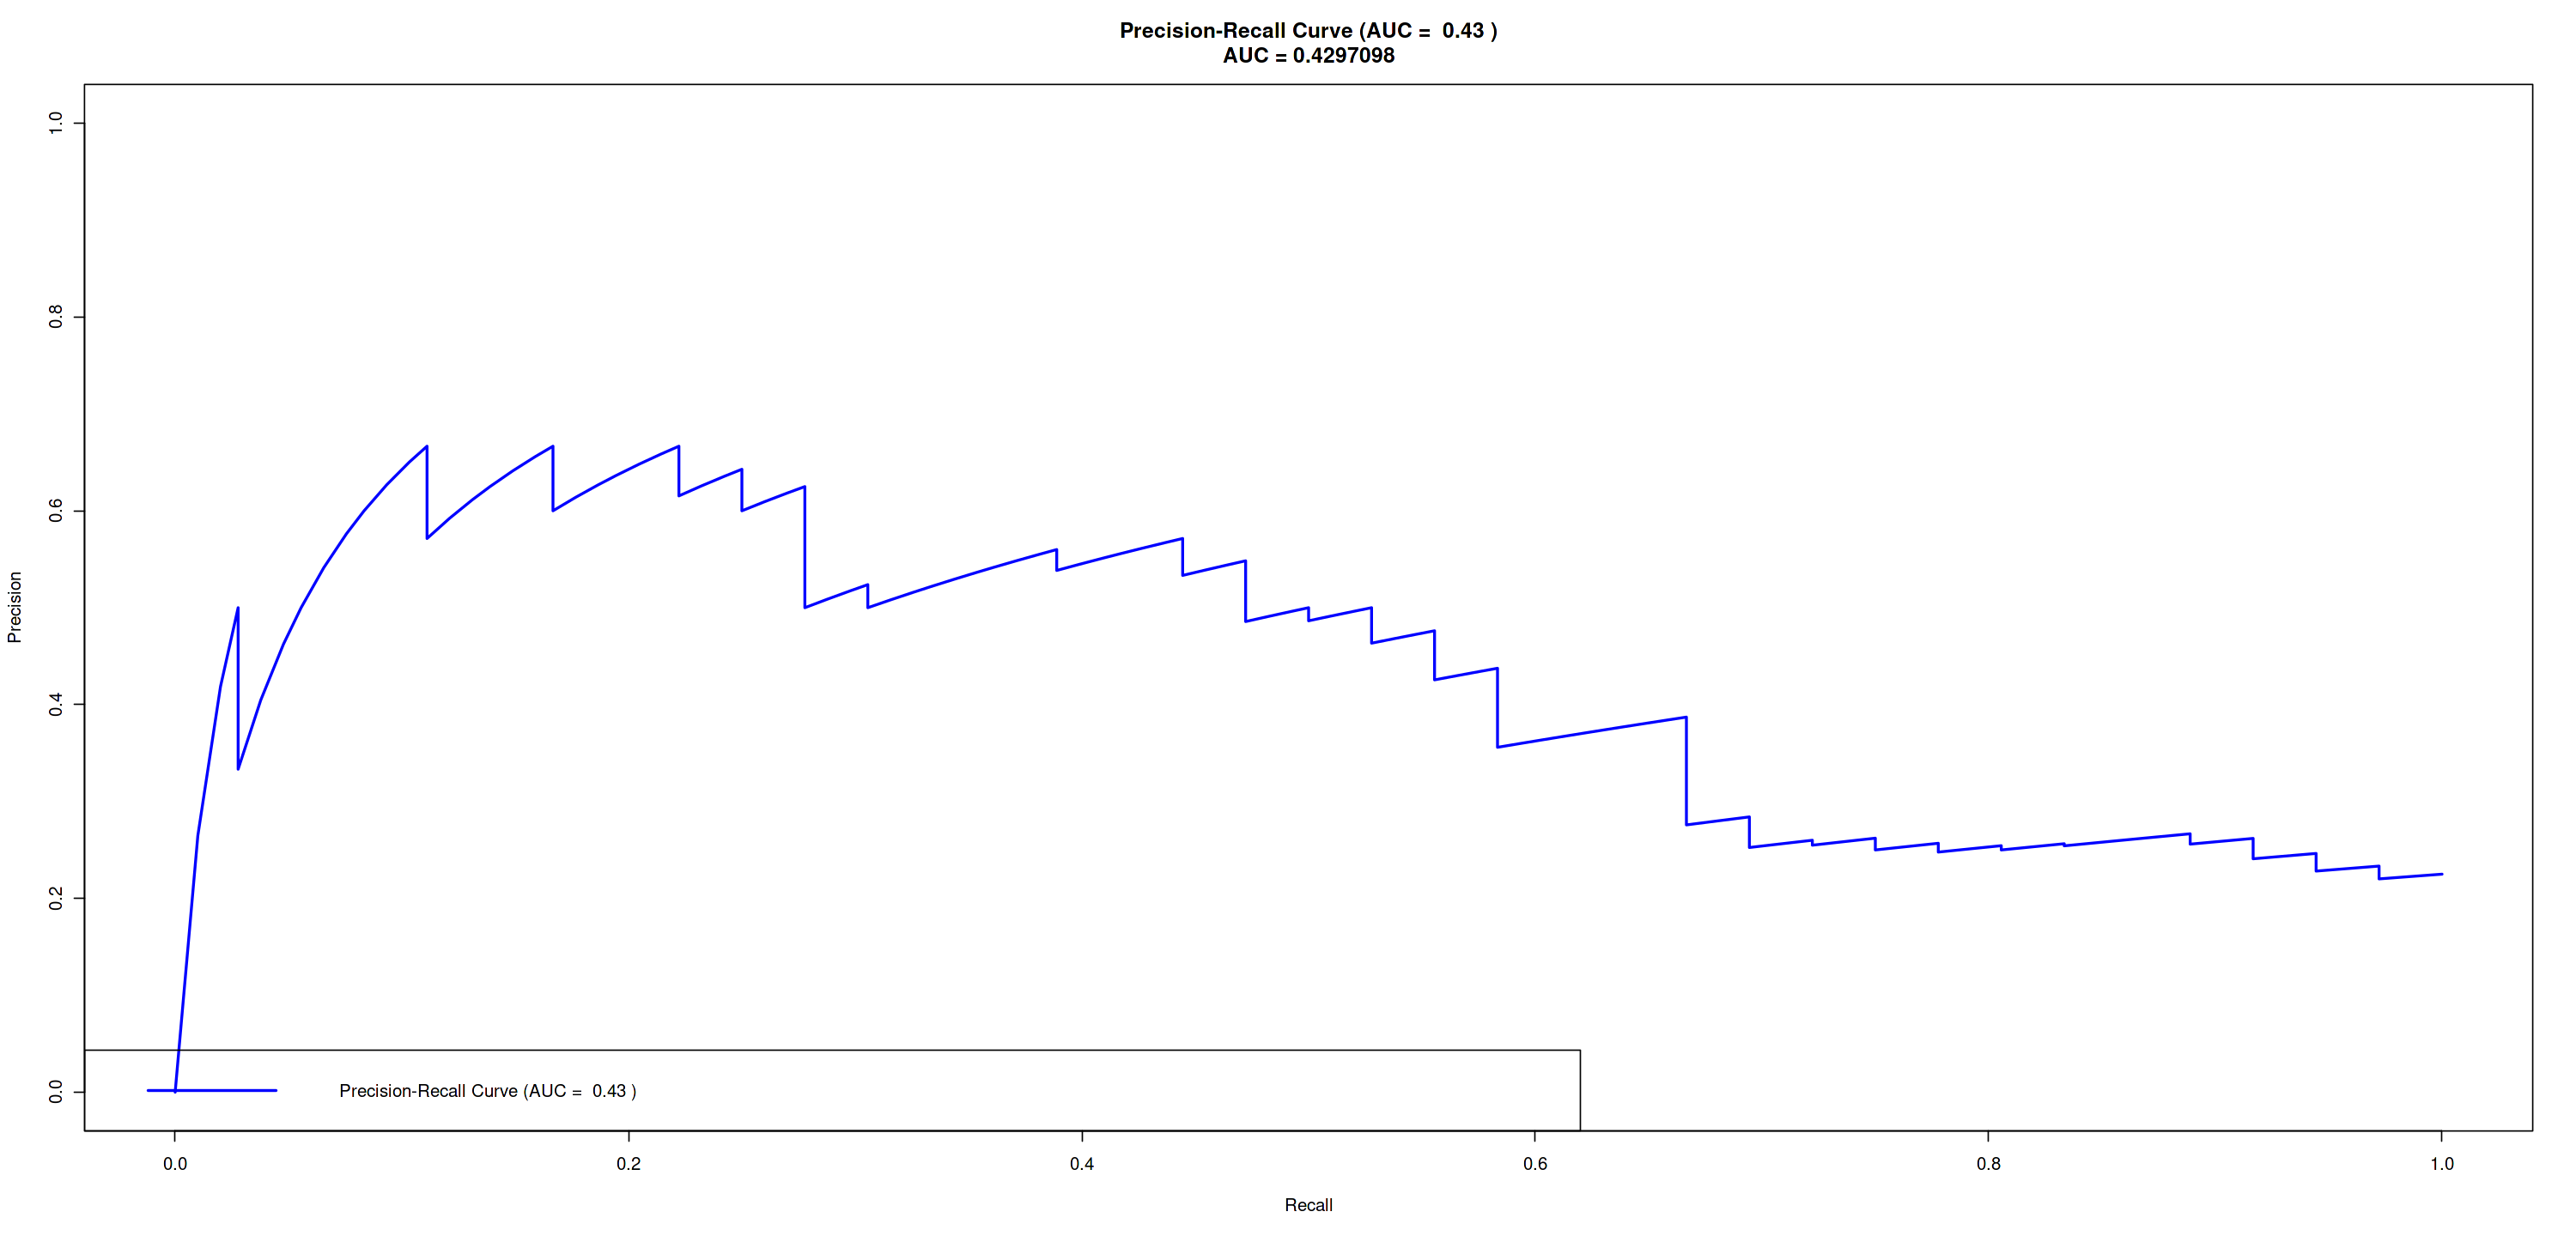

In [98]:
# Buat precision-recall curve
plot_ml(x=y_valid, y=y_pred_lgb, z=y_pred_prob_lgb, ml="Imbalanced_Classification", type_plot="Precision-Recall")

### 7.7.3 Cross Validation

In [99]:
# Lakukan cross-validation dengan model lightgbm
lgb_cv <- ml_cv_results(model_name="LightGBM", model="lgb", ml="Imbalanced_Classification", x=X_temp_cs, y=y_temp)
print(lgb_cv)

Fold K= 1 
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 151, number of negative: 489
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 806
[LightGBM] [Info] Number of data points in the train set: 640, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.235937 -> initscore=-1.175083
[LightGBM] [Info] Start training from score -1.175083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]:  valid's binary_error:0.3125 
Will train until there is no improvement in 3 rounds.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]:  valid's binary_error:0.33125 
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]:  valid's binary_error:0.325 
[LightGBM] [Warning] No further splits

## 7.8 Comparing Model's Performance

### 7.8.1 Single Performance

In [100]:
# Menggabungkan hasil model ke dalam satu data frame
modeling_performance <- bind_rows(dummy_results, lg_results, knn_results, 
                                  rf_results, xgb_results, svm_results, lgb_results)

# Mengurutkan berdasarkan F1 score secara menaik
modeling_performance_sorted <- modeling_performance %>%
  arrange(Balance.Accuracy)

# Menampilkan hasil yang sudah diurutkan
print(modeling_performance_sorted)

                    Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa   MCC
Dummy                          0.500     0.225  1.000               0.367  0.422 0.000   NaN
Random Forest                  0.616     0.550  0.306               0.393  0.485 0.277 0.294
Logistic Regression            0.626     0.545  0.333               0.414  0.448 0.293 0.306
K Nearest Neighbors            0.640     0.349  0.611               0.444  0.253 0.222 0.240
XGBoost                        0.664     0.577  0.417               0.484  0.398 0.364 0.371
LightGBM                       0.676     0.531  0.472               0.500  0.430 0.366 0.367
SVM                            0.692     0.607  0.472               0.531  0.178 0.416 0.421


### 7.8.2 Cross Validation

In [101]:
# Menggabungkan hasil cross-validation ke dalam satu data frame
modeling_performance_cv <- bind_rows(dummy_cv, lg_cv, knn_cv, rf_cv, 
                                     xgb_cv, svm_cv, lgb_cv)

# Mengurutkan berdasarkan F1 score secara menaik
modeling_performance_cv_sorted <- modeling_performance_cv %>%
  arrange(Balanced.Accuracy)

# Menampilkan hasil yang sudah diurutkan
print(modeling_performance_cv_sorted)

                    Balanced.Accuracy       Precision          Recall   F1.Minorities          AUC.PR           Kappa             MCC
Dummy                 0.514 +/- 0.034 0.246 +/- 0.067         1 +/- 0 0.392 +/- 0.081 0.474 +/- 0.122         0 +/- 0      NaN +/- NA
K Nearest Neighbors   0.622 +/- 0.043 0.327 +/- 0.025 0.757 +/- 0.067 0.455 +/- 0.028   0.3 +/- 0.047 0.169 +/- 0.059  0.212 +/- 0.07
Random Forest          0.63 +/- 0.044 0.553 +/- 0.086 0.351 +/- 0.099  0.424 +/- 0.08 0.466 +/- 0.058 0.292 +/- 0.082  0.307 +/- 0.08
XGBoost               0.653 +/- 0.038 0.584 +/- 0.126 0.398 +/- 0.073  0.468 +/- 0.07 0.495 +/- 0.125  0.338 +/- 0.08 0.351 +/- 0.087
SVM                   0.683 +/- 0.025 0.566 +/- 0.044 0.486 +/- 0.061  0.52 +/- 0.029  0.17 +/- 0.025  0.38 +/- 0.034 0.384 +/- 0.033
Logistic Regression   0.701 +/- 0.026 0.612 +/- 0.101 0.508 +/- 0.064  0.549 +/- 0.04 0.516 +/- 0.081 0.421 +/- 0.046 0.429 +/- 0.048
LightGBM              0.703 +/- 0.024 0.442 +/- 0.037 0.688 +/

# 8.0 Hyperparameter Fine Tuning

In [102]:
ranges <- list(cost = 10^(-3:3), gamma = 10^(-3:3))

# Lakukan tuning menggunakan fungsi 'tune'
tuned_model <- tune(
  svm,                     # Algoritma model (misalnya SVM)
  train.x      = X_train_cs,    # Data fitur untuk pelatihan
  train.y      = y_train,       # Label target untuk pelatihan
  validation.x = X_temp_cs, # Data fitur untuk validasi
  validation.y = y_temp,    # Label target untuk validasi
  ranges       = ranges,          # Grid untuk tuning parameter
  tunecontrol  = tune.control(sampling = "cross", cross = 5), # 5-fold cross-validation
  probability  = TRUE
)

In [103]:
# Menampilkan parameter terbaik
best_model <- tuned_model$best.model
print(best_model)


Call:
best.tune(METHOD = svm, train.x = X_train_cs, train.y = y_train, validation.x = X_temp_cs, validation.y = y_temp, ranges = ranges, 
    tunecontrol = tune.control(sampling = "cross", cross = 5), probability = TRUE)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.01 
    epsilon:  0.1 

Sigma:  0.597399 


Number of Support Vectors:  484



In [104]:
# Prediksi kelas menggunakan model Support Vector Machine
y_pred_svm_tune <- predict(best_model, newdata = X_params_cs, decision.values = TRUE, probability = FALSE, na.action = na.omit)
#y_pred_svm_tune <- as.numeric(y_pred_svm_tune) - 1
y_pred_svm_tune <- ifelse(y_pred_svm_tune > 0.5, 1, 0)

In [105]:
f1_score <- MLmetrics::F1_Score(y_temp, y_pred_svm_tune)
print(f1_score)

[1] 0.8835275


## 8.1 Results

In [106]:
# Melatih model SVM menggunakan svm() dari e1071
final_svm_model <- e1071::svm(
  x             = X_params_cs,                      # Fitur data untuk pelatihan
  y             = as.factor(y_temp),                           # Label target untuk pelatihan
  type          = "C-classification",            # Tipe klasifikasi SVM (bisa juga "nu-classification")
  kernel        = "radial",                    # Kernel radial (RBF)
  cost          = best_model$cost,               # Nilai cost dari grid
  gamma         = best_model$gamma,             # Nilai gamma dari grid
  class.weights = list('1' = 1, '0' = 1),
  probability   = TRUE                         # Menonaktifkan scaling, jika perlu (opsional)
)

# Prediksi kelas menggunakan model Support Vector Machine
y_pred_svm_gs <- predict(final_svm_model, newdata = X_params_cs, decision.values = TRUE, probability = FALSE, na.action = na.omit)

# Jika Anda ingin hasil sebagai angka (0 atau 1), Anda bisa ubah prediksi kelasnya menjadi numeric
y_pred_svm_gs <- as.numeric(y_pred_svm_gs) - 1

# Prediksi probabilitas kelas positif untuk data uji
y_pred_prob_svm_gs <- predict(final_svm_model, newdata = X_params_cs, decision.values = TRUE, probability = TRUE, na.action = na.omit)
y_pred_prob_svm_gs <- attr(y_pred_prob_svm_gs, "probabilities")[, 2]

### 8.1.2 Single Results

In [109]:
# Panggil fungsi ml_scores untuk mengevaluasi model svm gs
svms_results <- ml_scores(model_name ="SVM-GS", x=y_temp, y=y_pred_svm_gs, z=y_pred_prob_svm_gs, ml= "Imbalanced_Classification")
print(svms_results)

       Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa   MCC
SVM-GS             0.77     0.652  0.655               0.653  0.138 0.539 0.539


### 8.1.3 Cross Validation

In [110]:
# Panggil fungsi cv untuk mengevaluasi model svm gs
svms_cv_results = ml_cv_results(model_name="SVM-GS", model="tuning", ml="Imbalanced_Classification", x=X_temp_cs, y=y_temp)
svms_cv_results

Fold K= 1 
Fold K= 2 
Fold K= 3 
Fold K= 4 
Fold K= 5 


,Balanced.Accuracy,Precision,Recall,F1.Minorities,AUC.PR,Kappa,MCC
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
SVM-GS,0.737 +/- 0.019,0.595 +/- 0.045,0.61 +/- 0.056,0.601 +/- 0.038,0.171 +/- 0.036,0.468 +/- 0.035,0.47 +/- 0.034


# 9.0 Conclusions

## 9.1 Final Model

In [111]:
# Model dengan parameter terbaik
final_model <- e1071::svm(
  x             = X_params_cs,                      # Fitur data untuk pelatihan
  y             = as.factor(y_temp),                           # Label target untuk pelatihan
  type          = "C-classification",            # Tipe klasifikasi SVM (bisa juga "nu-classification")
  kernel        = "radial",                    # Kernel radial (RBF)
  cost          = best_model$cost,               # Nilai cost dari grid
  gamma         = best_model$gamma,             # Nilai gamma dari grid
  class.weights = list('1' = 1, '0' = 1),
  probability   = TRUE                         # Menonaktifkan scaling, jika perlu (opsional)
)

# Prediksi kelas menggunakan model Support Vector Machine
y_pred_unseen <- predict(final_model, newdata = X_test_cs, decision.values = TRUE, probability = FALSE, na.action = na.omit)
y_pred_unseen <- as.numeric(y_pred_unseen) - 1
        
# Prediksi probabilitas kelas positif untuk data uji
y_pred_prob_unseen <- predict(final_model, newdata = X_test_cs, decision.values = TRUE, probability = TRUE, na.action = na.omit)
y_pred_prob_unseen <- attr(y_pred_prob_unseen, "probabilities")[, 2]

### 9.1.1 Unseen Data Score

In [112]:
# Panggil fungsi ml_scores untuk mengevaluasi model unseen scores
unseen_scores <- ml_scores(model_name ="Unseen", x=y_test, y=y_pred_unseen, z=y_pred_prob_unseen, ml= "Imbalanced_Classification")
print(unseen_scores)

       Balance.Accuracy Precision Recall F1.Score.Minorities AUC.PR Kappa   MCC
Unseen            0.793     0.594   0.76               0.667  0.175 0.537 0.545


## 9.2 Blocker Fraud Company Expasion

### 9.2.1 Perusahaan menerima 15%-30% dari nilai klaim untuk setiap klaim yang terdeteksi sebagai penipuan dan benar-benar merupakan penipuan.

In [113]:
# Membuat dataframe baru 'df_test' yang berisi data uji (test data) berdasarkan indeks dari X_test
df_test <- df5[rownames(X_test), ]

# Menambahkan kolom 'predictions' ke dalam 'df_test' yang berisi hasil prediksi model pada data uji
df_test$predictions <- y_pred_unseen

In [114]:
# Membuat dataframe 'aux1' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'yes'
# dan kolom 'predictions' bernilai 1 (model memprediksi kasus tersebut sebagai fraud)
aux1 <- df_test[df_test$fraud_reported == 'yes' & df_test$predictions == 1, ]

# Menghitung persentase acak antara 0.15 dan 0.30
random_percentage_1 <- runif(1, 0.15, 0.30)

# Menghitung jumlah klaim berdasarkan persentase acak yang dihasilkan
receives1 <- sum(aux1$total_claim_amount) * random_percentage_1

In [115]:
cat(sprintf('Perusahaan dapat menerima %.2f dari transaksi penipuan yang terdeteksi dengan persentase %.2f%%.', receives1, random_percentage_1 * 100))

Perusahaan dapat menerima 212634.96 dari transaksi penipuan yang terdeteksi dengan persentase 25.00%.

###  9.2.2 Perusahaan menerima 2%-5% dari nilai klaim untuk setiap klaim yang terdeteksi sebagai penipuan, tetapi sebenarnya merupakan klaim yang sah.

In [116]:
# Membuat dataframe 'aux2' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'no'
# dan kolom 'predictions' bernilai 1 (model memprediksi kasus tersebut sebagai fraud)
aux2 <- df_test[df_test$fraud_reported == 'no' & df_test$predictions == 1, ]

# Menghitung persentase acak antara 0.02 dan 0.05
random_percentage_2 <- runif(1, 0.02, 0.05)

# Menghitung jumlah klaim berdasarkan persentase acak yang dihasilkan
receives2 <- sum(aux2$total_claim_amount) * random_percentage_2

In [117]:
# Menampilkan pesan dengan format yang sesuai
cat(sprintf('Untuk False Positive, perusahaan dapat menerima %.2f dari transaksi penipuan yang terdeteksi dengan persentase %.2f%%.\n', receives2, random_percentage_2 * 100))

Untuk False Positive, perusahaan dapat menerima 50008.83 dari transaksi penipuan yang terdeteksi dengan persentase 2.08%.


### 9.2.3 Perusahaan wajib mengembalikan 100% dari nilai klaim kepada pelanggan untuk setiap klaim yang diklasifikasikan sebagai sah, tetapi sebenarnya merupakan klaim penipuan .

In [118]:
# Membuat dataframe 'aux3' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'yes'
# dan kolom 'predictions' bernilai 0
aux3 <- df_test[df_test$fraud_reported == 'yes' & df_test$predictions == 0, ]

# Menghitung jumlah klaim berdasarkan total klaim yang ada
receives3 <- sum(aux3$total_claim_amount)

In [119]:
# Menampilkan pesan dengan format yang sesuai
cat(sprintf('Perusahaan harus mengembalikan sejumlah %.2f.\n', receives3))

Perusahaan harus mengembalikan sejumlah 2788380.00.


# 9.3 Model's Performance

#### 1. Berapa nilai Precision dan Accuracy dari model yang digunakan?

In [120]:
# Menampilkan pesan dengan format yang sesuai
cat(sprintf('Untuk unseen data, nilai balanced accuracy adalah %.2f dan precision adalah %.2f.\n', unseen_scores$`Balance.Accuracy`, unseen_scores$Precision))

Untuk unseen data, nilai balanced accuracy adalah 0.79 dan precision adalah 0.59.


#### 2.Seberapa konsisten model dalam mengklasifikasikan klaim sebagai fraudulent atau legitimate?

In [121]:
# Menentukan nilai-nilai untuk F1 Minorities
f1_minors_1 <- as.numeric(sapply(strsplit(svms_cv_results$`F1.Minorities`, " "), `[`, 1))
f1_minors_2 <- as.numeric(sapply(strsplit(svms_cv_results$`F1.Minorities`, " "), `[`, 3))

# Menampilkan pesan dengan format yang sesuai
cat(sprintf('Model dapat mendeteksi %.2f +/ %.2f fraud. Namun terdeteksi %.2f fraud dari unseen data.\n', f1_minors_1, f1_minors_2, unseen_scores$`F1.Score.Minorities`))

Model dapat mendeteksi 0.60 +/ 0.04 fraud. Namun terdeteksi 0.67 fraud dari unseen data.


#### 3.a. Berapa pendapatan yang diharapkan perusahaan?

In [122]:
# Membuat dataframe 'aux1' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'yes'
# dan kolom 'predictions' bernilai 1
aux1 <- df_test[df_test$fraud_reported == 'yes' & df_test$predictions == 1, ]
receives_1 <- sum(aux1$total_claim_amount) * random_percentage_1

# Membuat dataframe 'aux2' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'no'
# dan kolom 'predictions' bernilai 1
aux2 <- df_test[df_test$fraud_reported == 'no' & df_test$predictions == 1, ]
receives_2 <- sum(aux2$total_claim_amount) * random_percentage_2

# Menampilkan hasil dengan format yang sesuai
cat(sprintf('Dengan menggunakan model, perusahaan mendapatkan %.2f.\n', receives_1 + receives_2))


Dengan menggunakan model, perusahaan mendapatkan 262643.79.


In [123]:
# Membuat dataframe 'aux3' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'yes'
aux3 <- df_test[df_test$fraud_reported == 'yes', ]
curr_receives1 <- sum(aux3$total_claim_amount) * random_percentage_1

# Membuat dataframe 'aux4' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'no'
aux4 <- df_test[df_test$fraud_reported == 'no', ]
curr_receives2 <- sum(aux4$total_claim_amount) * random_percentage_2

# Menampilkan hasil dengan format yang sesuai
cat(sprintf('Dengan metode ini perusahaan mendapatkan %.2f.\n', curr_receives1 + curr_receives2))


Dengan metode ini perusahaan mendapatkan 1055459.64.


#### 3.b. Berapa kerugian yang mungkin dialami perusahaan?

In [124]:
# Membuat dataframe 'aux1' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'yes'
# dan kolom 'predictions' bernilai 0
aux1 <- df_test[df_test$fraud_reported == 'yes' & df_test$predictions == 0, ]
loss <- sum(aux1$total_claim_amount)

# Menampilkan hasil dengan format yang sesuai
cat(sprintf('Untuk kesalahan dalam klasifikasi perusahaan harus mengembalikan sekitar %.2f.\n', loss))


Untuk kesalahan dalam klasifikasi perusahaan harus mengembalikan sekitar 2788380.00.


In [125]:
# Membuat dataframe 'aux1' yang hanya berisi baris di mana kolom 'fraud_reported' bernilai 'yes'
aux1 <- df_test[df_test$fraud_reported == 'yes', ]
curr_loss <- sum(aux1$total_claim_amount)

# Menampilkan hasil dengan format yang sesuai
cat(sprintf('Untuk kesalahan dalam klasifikasi pada metode ini, perusahaan harus mengembalikan sekitar %.2f.\n', curr_loss))


Untuk kesalahan dalam klasifikasi pada metode ini, perusahaan harus mengembalikan sekitar 3638970.00.


#### 3.c. Berapa keuntungan bersih perusahaan?

In [126]:
# Menampilkan hasil dengan format yang sesuai
cat(sprintf('Perusahaan mendapatkan keuntungan sekitar %.2f.\n', receives_1 + receives_2 - loss))

Perusahaan mendapatkan keuntungan sekitar -2525736.21.


In [127]:
# Menampilkan hasil dengan format yang sesuai
cat(sprintf('Dengan menggunakan metode ini, keuntungan nya sekitar %.2f.\n', curr_receives1 + curr_receives2 - curr_loss))

Dengan menggunakan metode ini, keuntungan nya sekitar -2583510.36.


#### 4.a. Bagaimana optimalisasi model dapat meningkatkan keuntungan perusahaan dan mengurangi risiko kerugian?

In [128]:
# Menampilkan pesan
cat('Optimalisasi model dalam insurance fraud detection dapat meningkatkan keuntungan perusahaan dengan mengurangi jumlah klaim palsu yang disetujui.\n')

Optimalisasi model dalam insurance fraud detection dapat meningkatkan keuntungan perusahaan dengan mengurangi jumlah klaim palsu yang disetujui.


#### 4.b. Apakah diperlukan kebijakan tambahan untuk meningkatkan tingkat deteksi yang lebih baik?

In [129]:
# Menampilkan pesan
cat('Ya, kebijakan tambahan mungkin diperlukan untuk meningkatkan tingkat deteksi yang lebih baik dalam insurance fraud detection. Kebijakan seperti penerapan auditor independen untuk memverifikasi klaim mencurigakan, atau pembaruan regulasi yang lebih ketat terkait pengajuan klaim, dapat memperkuat hasil deteksi model.\n')

Ya, kebijakan tambahan mungkin diperlukan untuk meningkatkan tingkat deteksi yang lebih baik dalam insurance fraud detection. Kebijakan seperti penerapan auditor independen untuk memverifikasi klaim mencurigakan, atau pembaruan regulasi yang lebih ketat terkait pengajuan klaim, dapat memperkuat hasil deteksi model.
